In [1]:
import pandas as pd
import numpy as np
import os
import re   
import time
import math
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random

from linearmodels.panel import PanelOLS, RandomEffects, compare
from scipy import stats
from scipy.stats import chi2_contingency, norm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from lime.lime_tabular import LimeTabularExplainer

from loader import *
from plot import *
from analysis import *
from preprocessing import *

# 1. 데이터 로드 및 준비

## 1.1. 데이터 로드

In [2]:
sas_files = set_dataset_path()
data_dict = join_sas_by_code(sas_files)

# 데이터프레임들을 딕셔너리로 통합
all_dfs = {
    'cd': concat_by_code(data_dict, 'cd'),
    'ind': concat_by_code(data_dict, 'ind'),
    'hh': concat_by_code(data_dict, 'hh'),
    'er': concat_by_code(data_dict, 'er'),
    'in': concat_by_code(data_dict, 'in'),
    'ou': concat_by_code(data_dict, 'ou'),
    'appen': concat_by_code(data_dict, 'appen'),
}

cd코드 로드 완료! 

ind코드 로드 완료! 

hh코드 로드 완료! 

er코드 로드 완료! 

in코드 로드 완료! 

ou코드 로드 완료! 

appen코드 로드 완료! 



## 1.2. 데이터 범위 필터링

- 당뇨병 진단 받은 환자 수로 필터링 = 총 1,865명.

### 1.2.1. CD (만성질환)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|--------|------|------|---|-----|
| CD3_1 | num_years_since_diagnosis | 진단 이후 소요 연수 | | |int|
| CD4 | visited_facility_this_year | 해당 질병으로 인한 <br> 금년 의료 시설 방문 여부 | | 0 = 미방문 <br> 1 = 방문 | categorical |
| CD5 | intake_medication_this_year | 금년 의약품 복용 여부 |  | 0 = 미복용 <br> 1 = 복용 | categorical | 
| CD6 | reason_no_intake  | 의약품 미복용 이유; <br>CD5 = 1인 환자만이 대상 | 1 = 약 먹을만큼 심각하지 않아서 <br> 2 = 효과가 별로 없어서 <br> 3 = 약을 먹어서 부작용이 생기거나 몸에 해로울까봐 <br> 4 = 경제적 이유로 (약값 비싸서) <br> 5 = 기타 <br> 6 = 약 이외의 치료 중 (혈액투석, 물리치료 등) <br> <br> 7 = 의사가 약을 처방하지 않음 <br> -1 = 해당사항 없음 <br> -9 = 모름 / 무응답 | unknown = 미확인/ 해당 없음 <br> voluntary = 자발적  <br> involuntary = 비자발적  | categorical |
| CD9 | followed_prescription  | 처방전 준수 여부 | | 0 = 미준수  <br> 1 = 준수 <br> -1 = 확인 안됨, 해당사항 없음  | categorical | 
| CD11 | had_medication_side_effects | 복용약으로 인한 <br> 부작용 발생 여부 | | 0 = 미발생 <br> 1 = 발생 <br> -1 = 확인 안됨, 해당사항 없음 | categorical | 
| CD19 | medication_satisfaction  | 복용약 만족 여부 |   - 1 = 매우 만족 <br> 2 = 만족 <br> 3 = 보통 <br> 4 = 불만족 <br> 5 = 매우 불만족 <br> -1, -9 = 모름, 해당사항 없음 | 0 = 불만족  <br> 1 = 만족 <br> -1 = 확인 안됨, <br>해당사항 없음  | categorical | 


In [3]:
# STEP 1: 행 필터링
filtered_df_cd, unique_hhid, unique_pid  = filter_cd(all_dfs['cd'])
filtered_df_cd.head()

CD3_2(의사진단여부) 컬럼 내 unique 값 = [1.]
CDNUM(만성질환번호) 컬럼 내 unique 값 = [2.]
필터링 된 데이터셋 내의 unique 가구 ID의 수 = 1672
필터링 된 데이터셋 내의 unique 가구원 ID의 수 = 1865
필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.0101
필터링 이전 대비 이후 환자 ID 비율 = 0.0917


HHIDWON    M1   M2         HHID  PID     PIDWON          HPID  CDNUM  \
0  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10    2.0   
1  10006.0  11.0  1.0  100060111.0  1.0  1000601.0  1.000601e+10    2.0   
2  10006.0  11.0  1.0  100060111.0  2.0  1000602.0  1.000601e+10    2.0   
3  10030.0  11.0  1.0  100300111.0  2.0  1003002.0  1.003001e+10    2.0   
4  10033.0  11.0  1.0  100330111.0  1.0  1003301.0  1.003301e+10    2.0   

    cd1_1  CD2  ...  CD5  CD6  CD9  CD10  CD11  CD12_0  CD12  CD19  YEAR  \
0  b'E11'  1.0  ...  2.0  3.0 -1.0  -1.0  -1.0    -1.0  -1.0  -1.0  2017   
1  b'E11'  1.0  ...  1.0 -1.0  1.0  -1.0   2.0    -1.0  -1.0   2.0  2017   
2  b'E11'  1.0  ...  1.0 -1.0  1.0  -1.0   2.0    -1.0  -1.0   2.0  2017   
3  b'E11'  3.0  ...  1.0 -1.0  1.0  -1.0   2.0    -1.0  -1.0   2.0  2017   
4  b'E11'  1.0  ...  1.0 -1.0  1.0  -1.0   2.0    -1.0  -1.0   2.0  2017   

   CD1_1  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

[5 rows x 24 columns]

In [4]:
# STEP 2: 컬럼 필터링
filtered_df_cd = filtered_df_cd.drop(['CDNUM', 'M1', 'M2','cd1_1', 'CD1_1', 'CD12_0', 'CD3_2', 'CD12', 'CD1_1', 'CD2'], axis = 1)
# filtered_df_cd.head()

In [5]:
# STEP 3: 컬럼 인코딩 및 리네이밍
columns_cd = id_columns + ['CD3_1','CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19', 'YEAR']
df_cd = filtered_df_cd[columns_cd]

final_df_cd = df_cd.copy()

cd_4_map = {1: 1, 2:0, -9: -1}
cd_5_map = {1: 1, 2:0, -9: -1}
cd_6_map = {-1: "unknown", -9: 'unknown', 1:'voluntary', 1: 'voluntary', 2: 'voluntary', 3: 'involuntary',
            4: 'involuntary', 5: 'voluntary', 6: 'involuntary', 7:'involuntary'}
cd_9_map = {1: 1, 2:0, -9: -1, -1: -1}
cd_11_map = {1: 1, 2:0, -9: -1, -1: -1}
cd_19_map = {1: 'satisfied', 2: 'satisfied', 3: 'dissatisfied', 4: 'dissatisfied', 5:'dissatisfied', -1: 'unknown', -9: 'unknown'}

map_cols = ['CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19']
mappers = [cd_4_map, cd_5_map, cd_6_map, cd_9_map, cd_11_map, cd_19_map]

rename_cols_code = ['CD3_1', 'CD4', 'CD5', 'CD6', 'CD9', 'CD11', 'CD19']
rename_cols_text = ['num_years_since_diagnosis', 'visited_facility_this_year', 'intake_medication_this_year', 
                    'reason_no_intake', 'followed_prescription', 'had_medication_side_effects', 'medication_satisfaction']

mapping_dict_cd = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_cd = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_cd = map_df(final_df_cd, mapping_dict_cd)
final_df_cd = rename_df(final_df_cd, rename_dict_cd)

final_df_cd.head()

HHIDWON     PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0  10004.0  1000402.0                     2016.0                           0   
1  10006.0  1000601.0                     2011.0                           1   
2  10006.0  1000602.0                     2013.0                           1   
3  10030.0  1003002.0                     2017.0                           1   
4  10033.0  1003301.0                     2012.0                           1   

   intake_medication_this_year reason_no_intake  followed_prescription  \
0                            0      involuntary                     -1   
1                            1          unknown                      1   
2                            1          unknown                      1   
3                            1          unknown                      1   
4                            1          unknown                      1   

   had_medication_side_effects medication_satisfaction  YEAR  
0                           -1                 unknown  2017  
1                            0               satisfied  2017  
2                            0               satisfied  2017  
3                            0               satisfied  2017  
4                            0               satisfied  2017

In [6]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_cd = calculate_num_years(final_df_cd, ['num_years_since_diagnosis'])

In [7]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_cd.select_dtypes(include=['category']).columns
final_df_cd = onehot_df(final_df_cd, onehot_columns)

# print(onehot_columns)
# final_df_cd.head()

In [8]:
# STEP 6: 모든 컬럼을 int 형으로 변환
final_df_cd = convert_into_int(final_df_cd)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_cd = move_year_column(final_df_cd).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)   

print(final_df_cd.columns)
final_df_cd.head()

Index(['HHIDWON', 'PIDWON', 'num_years_since_diagnosis',
       'visited_facility_this_year', 'intake_medication_this_year',
       'followed_prescription', 'had_medication_side_effects',
       'reason_no_intake_involuntary', 'reason_no_intake_unknown',
       'reason_no_intake_voluntary', 'medication_satisfaction_dissatisfied',
       'medication_satisfaction_satisfied', 'medication_satisfaction_unknown',
       'YEAR'],
      dtype='object')


HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0    10004  1000402                          4                           0   
1    10004  1000402                          0                           1   
2    10004  1000402                          1                           0   
3    10004  1000402                          2                           0   
4    10006  1000601                          3                           1   

   intake_medication_this_year  followed_prescription  \
0                            0                     -1   
1                            1                      1   
2                            0                     -1   
3                            0                     -1   
4                            1                      0   

   had_medication_side_effects  reason_no_intake_involuntary  \
0                           -1                             0   
1                            0                             0   
2                           -1                             1   
3                           -1                             1   
4                            0                             0   

   reason_no_intake_unknown  reason_no_intake_voluntary  \
0                         0                           1   
1                         1                           0   
2                         0                           0   
3                         0                           0   
4                         1                           0   

   medication_satisfaction_dissatisfied  medication_satisfaction_satisfied  \
0                                     0                                  0   
1                                     0                                  1   
2                                     0                                  0   
3                                     0                                  0   
4                                     1                                  0   

   medication_satisfaction_unknown  YEAR  
0                                1  2014  
1                                0  2016  
2                                1  2017  
3                                1  2018  
4                                0  2014

### 1.2.2. IND (가구원정보)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| C4_0 | age | 출생 연도를 나이로 변환 | 1945, 1960, ... | 올해 연도 - 출생 연도 | int |
| C8 | education_level | 교육 수준 | - | - | categorical |
| C12_1 | num_years_since_med_pension | 의료급여개시 연도 | - | 의료급여개시 부터 소요 연도; <br> 올해 연도 - 개시 연도 | int |
| C15 | pension_receipt_status | 국민연금가입 | 1 = 납부중<br>2 = 납부안함<br>3 = 수령중<br>-9 = 해당사항 없음 | 'paying' = 납부중<br>'unpaying' = 납부안함<br>'receiving' = 수령중<br>'unknown' = 해당사항 없음 | categorical |
| C33 | is_full_timer | 종사상 지위 | 0 = 정규직<br>1 = 상용직<br>2 = 임시직<br>3 = 일용직<br>4 = 자활근로, 공공근로, 노인 일자리<br>5 = 자영업자<br>-6, -1 = 해당사항 없음 | 1 = 정규직<br>0 = 비정규직<br>-1 = 해당사항 없음 | categorical |
| C24 | employed | 경제활동유무 | 1 = YES<br>2 = NO<br>-1, -6 = 해당사항 없음 | 1 = YES<br>0 = NO<br>-1 = 해당사항 없음 | categorical |
| C35 | work_availability | 근무지속가능여부 | 1 = 예<br>2 = 아니오<br>-1, -6, -9 = 해당사항 없음 | 1 = 예<br>0 = 아니오<br>-1 = 해당사항 없음 | categorical |
| C14 | has_disability | 장애등급 | -1 = 해당사항 없음<br>1~6 = 장애 등급 | -1 = 해당사항 없음<br>1~6 = 장애 등급 | categorical |
| C26 | employment_type | 일자리유형 | 1 = 임금근로자<br>2 = 고용주, 자영업자<br>3 = 무급가족종사자<br>-1, -6 = 해당사항 없음 | 'employee' = 임금근로자<br>'employer' = 고용주, 자영업자<br>'family_unpaid' = 무급가족종사자<br>'unknown' = 해당사항 없음 | categorical |
| C18 | private | 민간연금/종신보험 가입 | 1 = 개인연금만<br>2 = 종신보험만<br>3 = 둘다 가입<br>4 = 둘다 미가입 | 'pension' = 개인연금만<br>'whole_insurance' = 종신보험만<br>'pension_and_insurance' = 둘다 가입<br>'non_registered' = 둘다 미가입 | categorical |
| C16_1 | worker_comp_insurance | 산재보험 가입 | 1 = 납부중<br>2 = 납부안함<br>3 = 수령중<br>-1, -9 = 해당사항 없음 | 'paying' = 납부중<br>'unpaying' = 납부안함<br>'receiving' = 수령중<br>'unknown' = 해당사항 없음 | categorical |
| C7 | married | 혼인상태 | 1 = 혼인중<br>2 = 별거<br>3 = 사별 또는 실종<br>4 = 이혼<br>5 = 없음 | 1 = 혼인중<br>0 = 기타 | categorical |
| C25 | reason_no_work | 비경제활동이유 | 1,3,4,11,12,13,14 = 자발적<br>2,5,6,7,8,9,10 = 비자발적<br>-1, -6 = 해당사항 없음 | 'voluntary' = 자발적<br>'involuntary' = 비자발적<br>'unknown' = 해당사항 없음 | categorical |
| C11 | type_medical_support | 의료보장형태 | 1,2,3 = 일반<br>4,5,10 = 의료급여<br>6,7 = 특례<br>8,9 = 제외 | 'standard' = 일반<br>'public' = 의료급여<br>'special' = 특례<br>'excluded' = 제외 | categorical |
| I_MEDICALEXP1 | medical_expense | 의료비용 | - | - | float |

In [9]:
# STEP 1: 행 필터링
filtered_df_ind = filter_rest(all_dfs['ind'], unique_hhid, unique_pid)
print(filtered_df_ind.columns)
filtered_df_ind.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.0955
필터링 이전 대비 이후 환자 ID 비율 = 0.0917
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'I_WGC_08',
       'I_WGC_TOT', 'WGL_08', 'WGL_TOT', 'WGL_M_08', 'WGL_M_TOT', 'A2', 'A2_0',
       'A2_1', 'A2_2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9_4', 'A10',
       'A11', 'A12', 'C2', 'C3', 'C4_0', 'C5', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C13_1', 'C13_2', 'C14', 'C15', 'C16_1', 'C17', 'C18',
       'C24', 'C25', 'C26', 'C27', 'C28', 'C32_0', 'C32', 'C33', 'C34', 'C35',
       'C36', 'C37', 'C37_1', 'C41', 'C42', 'C43', 'C44', 'C45', 'PR1', 'PR2',
       'PR3', 'PR4', 'PR5', 'PR6', 'PR6_1', 'PR12', 'PR13', 'PR14', 'PR15',
       'PR16', 'PR17', 'PR18', 'PR19', 'PR20', 'PR19_1', 'PR20_1', 'PR19_2',
       'PR20_2', 'I_MEDICALEXP1', 'I_MEDICALEXP2', 'TOTAL_Q5_08',
       'TOTAL_Q10_08', 'W_TOTAL_Q5_08', 'W_TOTAL_Q10_08', 'TOTAL_Q5_TOT',
       'TOTAL_Q10_TOT', 'W_TOTAL_Q5_TOT', 'W_TOTAL_Q10_TOT', 'YEAR', 'C12_1',
       'C12_2'],
   

HHIDWON    M1   M2         HHID  PID     PIDWON          HPID  \
1   10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   
4   10006.0  11.0  1.0  100060111.0  1.0  1000601.0  1.000601e+10   
5   10006.0  11.0  1.0  100060111.0  2.0  1000602.0  1.000601e+10   
24  10030.0  11.0  1.0  100300111.0  2.0  1003002.0  1.003001e+10   
29  10033.0  11.0  1.0  100330111.0  1.0  1003301.0  1.003301e+10   

       I_WGC_08    I_WGC_TOT       WGL_08  ...  TOTAL_Q10_08  W_TOTAL_Q5_08  \
1   5116.224912  3768.792843     0.000000  ...           4.0            2.0   
4   6037.822879  4451.959464  6365.821586  ...           8.0            4.0   
5   7605.154585  5605.618816  8193.433264  ...           8.0            4.0   
24  2493.356339  1837.524298  2717.281960  ...           3.0            1.0   
29  6346.984168  4680.089119  6708.793160  ...           9.0            4.0   

    W_TOTAL_Q10_08  TOTAL_Q5_TOT  TOTAL_Q10_TOT  W_TOTAL_Q5_TOT  \
1              4.0           2.0            4.0             2.0   
4              8.0           4.0            8.0             4.0   
5              8.0           4.0            8.0             4.0   
24             2.0           2.0            3.0             1.0   
29             8.0           5.0            9.0             4.0   

    W_TOTAL_Q10_TOT  YEAR  C12_1  C12_2  
1               4.0  2017    NaN    NaN  
4               8.0  2017    NaN    NaN  
5               8.0  2017    NaN    NaN  
24              2.0  2017    NaN    NaN  
29              8.0  2017    NaN    NaN  

[5 rows x 96 columns]

In [10]:
# STEP 2: 컬럼 필터링
columns_ind = id_columns + ['C8','C4_0', 'C12_1', 'C15', 'C33', 'C24', 'C35', 'C14',
                            'C26','C18', 'C16_1', 'C7', 'C25', 'C11', 'I_MEDICALEXP1','YEAR']
df_ind = filtered_df_ind[columns_ind]

In [11]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_ind = df_ind.copy()

c_15_map = {1: 'paying', 2: 'unpaying', 3: 'receiving', -9: 'unknown'}
c_33_map = {0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: -1, -6: -1}
c_24_map = {1: 1, 2: 0, -1: -1, -6: -1}
c_35_map = {1: 1, 2: 0, -1: -1, -6: -1, -9: -1}
# c_14_map = {-1: 0, 1: 1, 2: 1,  3: 1, 4: 1, 5:1, 6:1} # 장애 등급
c_26_map = {3:'family_unpaid', 1:'employee', 2:'employer', -1: 'unknown', -6: 'unknown'}
c_18_map = {1: 'pension', 2: 'whole_insurance', 3: 'pension_and_insurance', 4: 'non_registered'}
c_16_map = {1: 'paying', 2: 'unpaying', 3: 'receiving', -9: 'unknown'}
c_7_map = {1: 1, 2: 0, 3: 0, 4:0, 5:0}
c_25_map = {
    1: 'voluntary', 3: 'voluntary', 4: 'voluntary', 12: 'voluntary', 13: 'voluntary', 14: 'voluntary', 11: 'voluntary',  # 자발적
    2: 'involuntary', 5: 'involuntary', 6: 'involuntary', 7: 'involuntary', 8: 'involuntary', 9: 'involuntary', 10: 'involuntary',      # 비자발적
    -1: 'unknown', -6: 'unknown'
}
c_11_map = {
    1: 'standard', 2: 'standard', 3: 'standard',
    4: 'public', 5: 'public', 10: 'public',
    6: 'special', 7: 'special', 8: 'excluded', 9: 'excluded'}

map_cols = ['C15', 'C33', 'C24', 'C35', 'C26', 'C18', 'C7', 'C25', 'C11']
mappers = [c_15_map, c_33_map, c_24_map, c_35_map, c_26_map, c_18_map, c_7_map, c_25_map, c_11_map]

rename_cols_code = ['C16_1', 'C4_0', 'C8', 'C12_1', 'C15', 'C33', 'C24', 'C35', 'C14', 'C26', 'C18', 'C7', 'C25', 'C11', 'I_MEDICALEXP1']
rename_cols_text = ['worker_comp_insurance', 'age', 'education_level', 'num_years_since_med_pension', 'pension_receipt_status', 'is_full_timer', 'employed', 'work_availability', 'has_disability', 'employment_type', 'private',  'married', 'reason_no_work', 'type_medical_support', 'medical_expense']

mapping_dict_ind = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_ind = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_ind

final_df_ind = map_df(final_df_ind, mapping_dict_ind)
final_df_ind = rename_df(final_df_ind, rename_dict_ind)
# final_df_ind.head()

In [12]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_ind['education_level'] = (final_df_ind['education_level'] // 10).astype('int') # 0 = 미취학, 무학 / 1 = 초졸 / 2 = 중졸 / 3 = 고졸 / 4 = 대졸 / 5 = 대학원 졸
final_df_ind['medical_expense'] = final_df_ind['medical_expense'].astype('int')
final_df_ind['has_disability'] = final_df_ind['has_disability'].apply(lambda x: 0 if x < 0 else x) # 장애 없을 경우 = 0, 있을 경우 장애 등급
final_df_ind['worker_comp_insurance'] = final_df_ind['worker_comp_insurance'].apply(lambda x: -1 if x < 0 else x)
final_df_ind = calculate_num_years(final_df_ind, ['age', 'num_years_since_med_pension'])
final_df_ind['age'] = final_df_ind['age'].apply(lambda x: -1 if x < 0 else x)
final_df_ind['is_above_45yrs'] = final_df_ind['age'].apply(lambda x: 1 if x >= 45 else 0)
final_df_ind['num_years_since_med_pension'] = final_df_ind['num_years_since_med_pension'].apply(lambda x: -1 if x < 0 else x)
# final_df_ind.head()

In [13]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_ind.select_dtypes(include=['category']).columns
final_df_ind = onehot_df(final_df_ind, onehot_columns)
# final_df_ind.head()

In [14]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_ind = convert_into_int(final_df_ind)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_ind = move_year_column(final_df_ind).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)

print(final_df_ind.columns)
final_df_ind#.head()

Index(['HHIDWON', 'PIDWON', 'education_level', 'age',
       'num_years_since_med_pension', 'is_full_timer', 'employed',
       'work_availability', 'has_disability', 'worker_comp_insurance',
       'married', 'medical_expense', 'is_above_45yrs',
       'pension_receipt_status_paying', 'pension_receipt_status_receiving',
       'pension_receipt_status_unknown', 'pension_receipt_status_unpaying',
       'employment_type_employee', 'employment_type_employer',
       'employment_type_family_unpaid', 'employment_type_unknown',
       'private_non_registered', 'private_pension',
       'private_pension_and_insurance', 'private_whole_insurance',
       'reason_no_work_involuntary', 'reason_no_work_unknown',
       'reason_no_work_voluntary', 'type_medical_support_public',
       'type_medical_support_special', 'type_medical_support_standard',
       'YEAR'],
      dtype='object')


HHIDWON   PIDWON  education_level  age  num_years_since_med_pension  \
0       10004  1000402                5   61                            0   
1       10004  1000402                5   62                            0   
2       10004  1000402                5   63                            0   
3       10004  1000402                5   64                            0   
4       10004  1000402                5   65                            0   
...       ...      ...              ...  ...                          ...   
8490    33006  3300603                1   68                            0   
8491    33006  3300603                0   69                            0   
8492    33006  3300603                0   70                            0   
8493    33006  3300603                0   71                            0   
8494    33006  3300603                0   72                            0   

      is_full_timer  employed  work_availability  has_disability  \
0                 1         1                  1               0   
1                 0         1                  1               0   
2                 0         1                  1               0   
3                 0         1                  1               0   
4                 0         1                  1               0   
...             ...       ...                ...             ...   
8490             -1         0                 -1               0   
8491             -1         0                 -1               0   
8492             -1         0                 -1               0   
8493             -1         0                 -1               0   
8494             -1         0                 -1               0   

      worker_comp_insurance  ...  private_pension  \
0                         2  ...                0   
1                         2  ...                0   
2                         2  ...                0   
3                         2  ...                0   
4                         2  ...                0   
...                     ...  ...              ...   
8490                      2  ...                0   
8491                      2  ...                0   
8492                      2  ...                0   
8493                      2  ...                0   
8494                      2  ...                0   

      private_pension_and_insurance  private_whole_insurance  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   
...                             ...                      ...   
8490                              0                        0   
8491                              0                        0   
8492                              0                        0   
8493                              0                        0   
8494                              0                        0   

      reason_no_work_involuntary  reason_no_work_unknown  \
0                              0                       1   
1                              0                       1   
2                              0                       1   
3                              0                       1   
4                              0                       1   
...                          ...                     ...   
8490                           0                       0   
8491                           0                       0   
8492                           0                       0   
8493                           1                       0   
8494                           0                       0   

      reason_no_work_voluntary  type_medical_support_public  \
0                            0                            0   
1          

### 1.2.3. HH (가구정보)


| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| B1 | num_household_members | 총 가구원 수 |  |  | int |
| B6 | housing_type | 주거형태 | 1 = 단독<br>2 = 다세대<br>3 = 연립<br>4 = 일반(임대)아파트<br>5 = 영구임대아파트<br>6 = 영업용건물<br>7 = 오피스텔<br>8 = 기타 | 'single' = 단독<br>'multi' = 다세대/연립<br>'apt' = 아파트<br>'office' = 영업용/오피스텔/기타 | categorical |
| B7 | housing_ownership | 주택소유여부 | 1 = 자가<br>2 = 전세<br>3 = 월세<br>4 = 무상<br>5 = 기타(부모 명의 거주) | 'owned' = 자가<br>'half_rent' = 전세<br>'rent' = 월세<br>'provided' = 무상<br>'parent' = 부모 명의 | categorical |
| B13 | housing_floor | 주거위치 | 1 = 지상층<br>2 = 반지하층<br>3 = 지하층<br>4 = 옥탑 | 'above' = 지상층<br>'half' = 반지하층<br>'below' = 지하층<br>'roof' = 옥탑 | categorical |
| TOT_H | home_labor_income | 가구 총 근로소득 | - | - | int |
| TOT_INC | home_asset_income | 총 자산소득 | - | - | int |
| TOTAL | home_total_income | 총 소득 | - | - | int |
| H_MEDICALEXP1 | home_medical_expense | 가구지출 의료비 | - | - | int |


In [15]:
# 주의: 가구정보 테이블에는 개인 식별 고유 코드 미존재. 가구 코드만 존재.
print('PIDWON' in all_dfs['hh'].columns)
print('HHIDWON' in all_dfs['hh'].columns)

False
True


In [16]:
# STEP 1: 행 필터링
filtered_df_hh= filter_hh(all_dfs['hh'], unique_hhid)
print(filtered_df_hh.columns)
filtered_df_hh.head()

필터링 된 데이터셋 내의 unique 가구 ID의 수 = 1672
필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.2622
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'H_WGC_08', 'H_WGC_TOT', 'M6', 'M7',
       'M8', 'P', 'P2', 'B1', 'B2', 'B3', 'B4_0', 'B41', 'B42', 'B43', 'B44',
       'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B13', 'TOT_H', 'INC1',
       'INC2', 'INC3', 'INC4', 'INC5', 'INC6', 'INC7', 'TOT_INC', 'TOTAL',
       'TOTAL_Q5_08', 'TOTAL_Q10_08', 'W_TOTAL_Q5_08', 'W_TOTAL_Q10_08',
       'TOTAL_Q5_TOT', 'TOTAL_Q10_TOT', 'W_TOTAL_Q5_TOT', 'W_TOTAL_Q10_TOT',
       'SAV', 'LIV', 'LIV2', 'LIV3', 'H1', 'H2', 'H3', 'H3_1', 'H4_1', 'H5',
       'H6_21', 'H6_22', 'H6_23', 'H6_24', 'H6_25', 'H78', 'H11', 'H12',
       'H_MEDICALEXP1', 'H_MEDICALEXP2', 'H_MEDICALEXP3', 'H_MEDICALEXP4',
       'H_MEDICALEXP5', 'YEAR', 'h_wgc_08', 'B4', 'B4_1', 'total_q5_tot',
       'total_q10_tot', 'w_total_q5_tot', 'w_total_q10_tot', 'B12', 'H4',
       'H6_11', 'H6_12', 'H6_13', 'H6_14', 'H6_15', 'H10'],
      dtype='object')


HHIDWON    M1   M2         HHID     H_WGC_08    H_WGC_TOT      M6   M7  \
1   10004.0  11.0  1.0  100040111.0  5173.019804  3933.451643  2018.0  3.0   
2   10006.0  11.0  1.0  100060111.0  7510.411313  5191.513271  2018.0  3.0   
11  10030.0  11.0  1.0  100300111.0  3291.609614  2137.657438  2018.0  2.0   
14  10033.0  11.0  1.0  100330111.0  6230.191427  4665.427541  2018.0  5.0   
16  10036.0  11.0  1.0  100360111.0  7367.230483  5602.853523  2018.0  2.0   

      M8     P  ...  w_total_q5_tot  w_total_q10_tot  B12  H4  H6_11  H6_12  \
1    5.0  41.0  ...             NaN              NaN  NaN NaN    NaN    NaN   
2    7.0  11.0  ...             NaN              NaN  NaN NaN    NaN    NaN   
11  12.0  41.0  ...             NaN              NaN  NaN NaN    NaN    NaN   
14  16.0  11.0  ...             NaN              NaN  NaN NaN    NaN    NaN   
16  15.0  41.0  ...             NaN              NaN  NaN NaN    NaN    NaN   

    H6_13  H6_14  H6_15  H10  
1     NaN    NaN    NaN  NaN  
2     NaN    NaN    NaN  NaN  
11    NaN    NaN    NaN  NaN  
14    NaN    NaN    NaN  NaN  
16    NaN    NaN    NaN  NaN  

[5 rows x 84 columns]

In [17]:
'''
B1 = 총 가구원 수
B6 = 주거형태: 1 = 단독, 2 = 다세대, 3 = 연립, 4 = 일반 (임대) 아파트, 5 = 영구임대아파트, 6 = 영업용건물, 7 = 오피스텔, 8 = 기타
B7 = 주택소유여부: 1 = 자가, 2 = 전세, 3 = 월세, 4 = 무상, 5 = 기타 (부모 명의 거주)
B13 = 주거위치: 1 = 지상층, 2 = 반지하층, 3 = 지하층, 4 = 옥탑
TOT_H = 가구 총 근로소득 (만원)
TOT_INC = 총 자산소득 (만원)
TOTAL = TOT_H + TOT_INC (만원)
H_MEDICALEXP1 = 가구지출 의료비 (원)
'''
# STEP 2: 컬럼 필터링
columns_hh =  ['HHIDWON', 'B1', 'B6', 'B7', 'B13', 'TOT_H', 'TOT_INC', 'TOTAL', 'H_MEDICALEXP1', 'YEAR']
df_hh = filtered_df_hh[columns_hh]
df_hh.head()

HHIDWON   B1   B6   B7  B13    TOT_H  TOT_INC    TOTAL  H_MEDICALEXP1  \
1   10004.0  3.0  1.0  4.0  1.0   3700.0    314.0   4014.0      1997380.0   
2   10006.0  3.0  4.0  1.0  1.0   2760.0   1308.0   4068.0      2990460.0   
11  10030.0  2.0  1.0  1.0  1.0    200.0   1414.0   1614.0       878110.0   
14  10033.0  4.0  5.0  2.0  1.0  10200.0   2580.0  12780.0      2197215.0   
16  10036.0  3.0  1.0  1.0  1.0      0.0   1494.0   1494.0      2733165.0   

    YEAR  
1   2018  
2   2018  
11  2018  
14  2018  
16  2018

In [18]:
# TOTAL = TOT_H + TOT_INC 으로 추정.
all_dfs['hh'][all_dfs['hh']['HHIDWON'] == 32519.0][['HHIDWON', 'HHID', 'H_MEDICALEXP1', 'TOT_H','TOT_INC', 'TOTAL', 'SAV','LIV','YEAR']]

HHIDWON         HHID  H_MEDICALEXP1   TOT_H  TOT_INC   TOTAL    SAV  \
6374   32519.0  325190511.0       736690.0  4000.0    720.0  4720.0  200.0   
6375   32519.0  325191011.0            0.0  5500.0      0.0  5500.0   50.0   
12979  32519.0  325190511.0       412120.0  6800.0   1121.0  7921.0  330.0   
19389  32519.0  325190511.0       126790.0  2550.0   1724.0  4274.0  100.0   
19390  32519.0  325191011.0            0.0  4500.0      0.0  4500.0   80.0   
26248  32519.0  325190511.0       303700.0  3800.0      3.0  3803.0  100.0   
32689  32519.0  325190511.0       213400.0  5800.0      0.0  5800.0   50.0   

         LIV  YEAR  
6374   167.0  2018  
6375    94.0  2018  
12979  250.0  2015  
19389  240.0  2017  
19390  155.0  2017  
26248  200.0  2014  
32689  300.0  2016

In [ ]:
final_df_hh = df_hh.copy()
final_df_hh.head()

HHIDWON   B1   B6   B7  B13    TOT_H  TOT_INC    TOTAL  H_MEDICALEXP1  \
1   10004.0  3.0  1.0  4.0  1.0   3700.0    314.0   4014.0      1997380.0   
2   10006.0  3.0  4.0  1.0  1.0   2760.0   1308.0   4068.0      2990460.0   
11  10030.0  2.0  1.0  1.0  1.0    200.0   1414.0   1614.0       878110.0   
14  10033.0  4.0  5.0  2.0  1.0  10200.0   2580.0  12780.0      2197215.0   
16  10036.0  3.0  1.0  1.0  1.0      0.0   1494.0   1494.0      2733165.0   

    YEAR  
1   2018  
2   2018  
11  2018  
14  2018  
16  2018

In [20]:
# STEP 3: 컬럼 인코딩 및 리네이밍
# 1 = 납부중 / 2 = 납부안함 / 3 = 수령중 / -9 = 해당사항 없음
b_6_map = {1: "single", 2: 'multi', 3: 'multi', 4: 'apt', 5: 'apt', 6: 'office', 7: 'office', 8: 'office'}
b_7_map = {1: "owned", 2: 'half_rent', 3: 'rent', 4: 'provided', 5: 'parent'}
b_13_map = {1: 'above', 2: 'half', 3: 'below', 4: 'roof'}

map_cols = ['B6', 'B7', 'B13'] # 해당 컬럼들 전체, 무응답 / 해당없음 행 무존재.
mappers = [b_6_map, b_7_map, b_13_map]

rename_cols_code = ['B1', 'B6', 'B7', 'B13', 'TOT_H', 'TOT_INC', 'TOTAL', 'H_MEDICALEXP1']
rename_cols_text = ['num_household_members', 'housing_type', 'housing_ownership', 'housing_floor', 'home_labor_income', 'home_asset_income', 'home_total_income', 'home_medical_expense']

mapping_dict_hh = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_hh = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_hh = map_df(final_df_hh, mapping_dict_hh)
final_df_hh = rename_df(final_df_hh, rename_dict_hh)
final_df_hh.head()

HHIDWON  num_household_members housing_type housing_ownership  \
1   10004.0                    3.0       single          provided   
2   10006.0                    3.0          apt             owned   
11  10030.0                    2.0       single             owned   
14  10033.0                    4.0          apt         half_rent   
16  10036.0                    3.0       single             owned   

   housing_floor  home_labor_income  home_asset_income  home_total_income  \
1          above             3700.0              314.0             4014.0   
2          above             2760.0             1308.0             4068.0   
11         above              200.0             1414.0             1614.0   
14         above            10200.0             2580.0            12780.0   
16         above                0.0             1494.0             1494.0   

    home_medical_expense  YEAR  
1              1997380.0  2018  
2              2990460.0  2018  
11              878110.0  2018  
14             2197215.0  2018  
16             2733165.0  2018

In [21]:
# STEP 4: 특정 컬럼 별 세부 처리
# 의료패널 sheet에 따르면, TOTAL은 ( ) 만원 단위로 입력되었으므로, *= 10000
won_cols = ['home_labor_income', 'home_asset_income', 'home_total_income']
final_df_hh = convert_won(final_df_hh, won_cols)

In [22]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_hh.select_dtypes(include=['category']).columns
final_df_hh = onehot_df(final_df_hh, onehot_columns)
# final_df_hh.head()

In [23]:
# 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_hh = convert_into_int(final_df_hh)

# # 2. YEAR 컬럼을 가장 오른쪽으로 이동
final_df_hh = move_year_column(final_df_hh)#.sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)      

print(final_df_hh.columns)
final_df_hh.head()

Index(['HHIDWON', 'num_household_members', 'home_labor_income',
       'home_asset_income', 'home_total_income', 'home_medical_expense',
       'housing_type_apt', 'housing_type_multi', 'housing_type_office',
       'housing_type_single', 'housing_ownership_half_rent',
       'housing_ownership_owned', 'housing_ownership_parent',
       'housing_ownership_provided', 'housing_ownership_rent',
       'housing_floor_above', 'housing_floor_below', 'housing_floor_half',
       'housing_floor_roof', 'YEAR'],
      dtype='object')


HHIDWON  num_household_members  home_labor_income  home_asset_income  \
1     10004                      3           37000000            3140000   
2     10006                      3           27600000           13080000   
11    10030                      2            2000000           14140000   
14    10033                      4          102000000           25800000   
16    10036                      3                  0           14940000   

    home_total_income  home_medical_expense  housing_type_apt  \
1            40140000               1997380                 0   
2            40680000               2990460                 1   
11           16140000                878110                 0   
14          127800000               2197215                 1   
16           14940000               2733165                 0   

    housing_type_multi  housing_type_office  housing_type_single  \
1                    0                    0                    1   
2                    0                    0                    0   
11                   0                    0                    1   
14                   0                    0                    0   
16                   0                    0                    1   

    housing_ownership_half_rent  housing_ownership_owned  \
1                             0                        0   
2                             0                        1   
11                            0                        1   
14                            1                        0   
16                            0                        1   

    housing_ownership_parent  housing_ownership_provided  \
1                          0                           1   
2                          0                           0   
11                         0                           0   
14                         0                           0   
16                         0                           0   

    housing_ownership_rent  housing_floor_above  housing_floor_below  \
1                        0                    1                    0   
2                        0                    1                    0   
11                       0                    1                    0   
14                       0                    1                    0   
16                       0                    1                    0   

    housing_floor_half  housing_floor_roof  YEAR  
1                    0                   0  2018  
2                    0                   0  2018  
11                   0                   0  2018  
14                   0                   0  2018  
16                   0                   0  2018

### 1.2.4. ER (응급서비스 이용)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| ERCOUNT | er_count | 응급실 이용 횟수 | - | - | int |
| ERNUM | er_num | 응급이용 일렬번호 | - | - | int |
| ER10 | er_days | 응급실 이용 일수 | - | - | int |
| ER13 | er_is_public | 응급실 이용 기관 국공립 여부 | 0 = 사립<br>1 = 공립 | 0 = 사립<br>1 = 공립 | categorical |
| ER19 | er_reason | 응급실 방문 이유 | 1 = 사고, 중독<br>2 = 질병<br>3 = 출산<br>4 = 기타 | er_reason_accident = 사고, 중독, 기타<br>er_reason_disease = 질병<br>er_reason_birth = 출산 | categorical |
| ER26_5 | tot_er_expense | 총 진료비 (수납창구에 지불한 총 수납금액) | - | - | int |
| ER34 | er_status_after | 응급실 입원 연계 | - | er_status_after_death = 응급실 이용 후 사망<br>er_status_after_home = 퇴원<br>er_status_hospital = 타 병원 연계 | categorical |

In [24]:
# STEP 1: 행 필터링
filtered_df_er = filter_rest(all_dfs['er'], unique_hhid, unique_pid)
print(filtered_df_er.columns)
# filtered_df_er.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1488
필터링 이전 대비 이후 환자 ID 비율 = 0.3162
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'ERCOUNT', 'ERNUM', 'ER4', 'ER5', 'ER6', 'ER7', 'ER8', 'ER9', 'ER10',
       'ER12', 'ER13', 'ER15', 'ER16', 'ER17_1', 'ER17_2', 'ER18', 'ER19',
       'ER20', 'ER21', 'ER22_2', 'ER23_2', 'ER24_2', 'ER25', 'ER26_1',
       'ER26_2', 'ER26_3', 'ER26_4', 'ER26_5', 'ER27', 'ER27_1', 'ER28',
       'ER29', 'ER30', 'ER31', 'ER32', 'ER33', 'ER33_1', 'ER34', 'ER35',
       'ER36', 'YEAR', 'er22_2', 'er23_2', 'er24_2'],
      dtype='object')


In [25]:
'''

'''
# STEP 2: 컬럼 필터링
columns_er = id_columns + ['ERCOUNT', 'ERNUM', 'ER10', 'ER13', 'ER19', 'ER26_5', 'ER34', 'YEAR']
df_er = filtered_df_er[columns_er]
# df_er.head()

In [26]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_er = df_er.copy()
er_19_map = {1: 'accident', 2: 'disease', 3: 'birth', 4: 'disease'} # 기타는 질병으로 처리
# er_26_5_map = {-9: -1}
er_34_map = {0: 'death', 1: 'hospital', 2: 'hospital', 3: 'home'}

map_cols = ['ER19', 'ER34']
mappers = [er_19_map, er_34_map]

rename_cols_code = ['ERCOUNT', 'ERNUM', 'ER10', 'ER13', 'ER19', 'ER26_5', 'ER34']
rename_cols_text = ['er_count', 'er_num', 'er_days', 'er_is_public', 'er_reason', 'er_tot_expense', 'er_status_after']

mapping_dict_er = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_er = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_er = map_df(final_df_er, mapping_dict_er)
final_df_er = rename_df(final_df_er, rename_dict_er)

In [27]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_er['er_is_public'] = final_df_er['er_is_public'].apply(lambda x: 1 if x == 1 else 0)

# 응급실 수납 비용이 -1, -9 (해당없음) 인 경우, 0 값으로 대체.
final_df_er['er_tot_expense'] = final_df_er['er_tot_expense'].apply(lambda x: 0 if x in [-1, -9] else x)
# final_df_er.head()

In [28]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_er.select_dtypes(include=['category']).columns
final_df_er = onehot_df(final_df_er, onehot_columns)
# final_df_er.head()

In [ ]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_er = convert_into_int(final_df_er)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_er = move_year_column(final_df_er)   

# STEP 8 (ER 테이블 한정): 최종 행 필터링
# er_count = 해당 연도에서 가구원이 응급실 방문한 총 횟수.
# er_num = 해당 연도에서 가구원이 응급실 방문한 일련번호.
# 따라서, er_count = er_numd인 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_er = final_df_er[final_df_er['er_count'] == final_df_er['er_num']]

# STEP 9: 중복 컬럼 제거: er_count, er_num
final_df_er = final_df_er.drop(columns=['er_count']).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)   

# print(final_df_er.columns)
final_df_er.head()

HHIDWON   PIDWON  er_num  er_days  er_is_public  er_tot_expense  \
0    10006  1000602       1        1             0          213467   
1    10033  1003302       1        2             1          283259   
2    10036  1003602       2        1             0           87110   
3    10042  1004201       1        1             0               0   
4    10050  1005002       1        1             0          128985   

   er_reason_accident  er_reason_disease  er_status_after_death  \
0                   0                  1                      0   
1                   0                  1                      0   
2                   0                  1                      0   
3                   0                  1                      0   
4                   1                  0                      0   

   er_status_after_home  er_status_after_hospital  YEAR  
0                     1                         0  2014  
1                     1                         0  2017  
2                     1                         0  2015  
3                     0                         1  2014  
4                     1                         0  2014

### 1.2.5. OU (외래서비스 이용)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| OUCOUNT | ou_count | 외래 이용횟수 | - | - | int |
| OUNUM | ou_num | 외래이용일련번호 | - | - | int |
| OU12 | ou_is_public | 외래 국공립 여부 | 1 = 공립<br>2 = 사립 | 0 = 사립<br>1 = 공립 | categorical |
| OU15 | ou_reason | 외래 방문 이유 | 1,2,3,4,6 = 수술 후<br>5,7 = 수술 전<br>8 = 미용<br>9,10 = 기타 | post = 수술 후<br>pre = 수술 전<br>aesthetic = 미용<br>etc = 기타 | categorical |
| OU22 | ou_treatment_type | 외래 치료 유형 | 0 = 없음<br>1 = 약물치료<br>2 = 물리치료<br>3 = 정신치료<br>4 = 수술<br>5 = 치과<br>6 = 한방<br>7 = 기타 | none = 없음<br>medication = 약물치료<br>phys_therapy = 물리치료<br>ment_therapy = 정신치료<br>surgery = 수술<br>dentistry = 치과<br>oriental = 한방<br>etc = 기타 | categorical |
| OU29_4 | ou_expense_paid | 건보부담금 | - | - | int |
| OU29_5 | ou_expense_insured | 법정본인부담금 | - | - | int |
| OU29_6 | ou_expense_uninsured | 비급여 | - | - | int |
| OU29_7 | ou_tot_expense | 총진료비 | - | - | int |
| OU30 | ou_expense_self_paid | 의료비재원 | 1 = 본인부담<br>2 = 기타 | 1 = 본인부담<br>0 = 기타 | categorical |




In [30]:
# STEP 1: 행 필터링
filtered_df_ou = filter_rest(all_dfs['ou'], unique_hhid, unique_pid)
print(filtered_df_ou.columns)
filtered_df_ou.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1875
필터링 이전 대비 이후 환자 ID 비율 = 0.0967
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'OUCOUNT', 'OUNUM', 'OU3_2', 'OU4_2', 'OU5_5', 'OU5_8', 'OU6', 'OU7',
       'OU8', 'OU9', 'OU11', 'OU12', 'OU14', 'OU15', 'OU16', 'OU17', 'OU18',
       'OU19', 'OU20', 'OU21', 'OU190', 'OU200', 'OU22', 'OU23_1', 'OU24_1',
       'OU25', 'OU26_1', 'OU27_1', 'OU29_2', 'OU29_3_1', 'OU26_3', 'OU29_4',
       'OU29_5', 'OU29_6', 'OU29_7', 'OU30', 'OU31', 'OU32', 'OU33', 'OU34',
       'OU35', 'OU35_1', 'OU36', 'OU37', 'OU38', 'OU39', 'OU40', 'OU41',
       'OU42', 'OU43', 'OU44', 'OU45', 'OU46', 'OU47_1', 'OU48_1', 'OU49_1',
       'OU50', 'YEAR', 'OU23', 'OU24', 'OU26', 'OU27', 'OU29_3', 'ou47_1',
       'ou48_1', 'ou49_1'],
      dtype='object')


HHIDWON    M1   M2         HHID  PID     PIDWON          HPID  ROUND  \
172  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   11.0   
173  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   11.0   
174  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   11.0   
175  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   11.0   
176  10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   11.0   

     OUCOUNT  OUNUM  ... OU50  YEAR OU23 OU24  OU26  OU27  OU29_3  ou47_1  \
172      9.0    1.0  ... -1.0  2016  NaN  NaN   NaN   NaN     NaN     NaN   
173      9.0    2.0  ... -1.0  2016  NaN  NaN   NaN   NaN     NaN     NaN   
174      9.0    3.0  ... -1.0  2016  NaN  NaN   NaN   NaN     NaN     NaN   
175      9.0    4.0  ... -1.0  2016  NaN  NaN   NaN   NaN     NaN     NaN   
176      9.0    5.0  ... -1.0  2016  NaN  NaN   NaN   NaN     NaN     NaN   

     ou48_1  ou49_1  
172     NaN     NaN  
173     NaN     NaN  
174     NaN     NaN  
175     NaN     NaN  
176     NaN     NaN  

[5 rows x 74 columns]

In [31]:
'''
OUCOUNT = 외래 이용횟수
OUNUM = 외래이용일련번호
OU12 = 외래 국공립 여부
OU15 = 외래 방문 이유
OU29_4 = 건보부담금
OU29_5 = 법정본인부담금
OU29_6 = 비급여
OU29_7 = 총진료비
OU30 = 의료비재원
'''
# STEP 2: 컬럼 필터링
columns_ou = id_columns + ['OUCOUNT', 'OUNUM', 'OU12', 'OU15', 'OU22', 'OU29_4', 'OU29_5', 'OU29_6', 'OU29_7', 'OU30', 'YEAR']
df_ou = filtered_df_ou[columns_ou]
# df_ou.head()

In [32]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_ou = df_ou.copy()

ou_15_map = {1: 'post', 2: 'post', 3: 'post', 4: 'post', 5: 'pre', 6: 'post', 7: 'pre', 8: 'aesthetic', 9: 'etc', 10: 'etc'}
ou_22_map = {0: 'none', 1: 'medication', 2: 'phys_therapy', 3: 'ment_therapy', 4: 'surgery', 5: 'dentistry', 6: 'oriental', 7: 'etc'}
ou_30_map = {1: 1, 2: 0}

map_cols = ['OU15', 'OU22', 'OU30']
mappers = [ou_15_map, ou_22_map, ou_30_map]

rename_cols_code = ['OUCOUNT', 'OUNUM', 'OU12', 'OU15', 'OU22', 'OU29_4', 'OU29_5', 'OU29_6', 'OU29_7', 'OU30']
rename_cols_text = ['ou_count', 'ou_num', 'ou_is_public', 'ou_reason', 'ou_treatment_type', 'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense', 'ou_expense_self_paid']

mapping_dict_ou = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_ou = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_ou

final_df_ou = map_df(final_df_ou, mapping_dict_ou)
final_df_ou = rename_df(final_df_ou, rename_dict_ou)
final_df_ou.head()


HHIDWON     PIDWON  ou_count  ou_num  ou_is_public ou_reason  \
172  10004.0  1000402.0       9.0     1.0           1.0      post   
173  10004.0  1000402.0       9.0     2.0           1.0      post   
174  10004.0  1000402.0       9.0     3.0           1.0      post   
175  10004.0  1000402.0       9.0     4.0           1.0      post   
176  10004.0  1000402.0       9.0     5.0           1.0      post   

    ou_treatment_type  ou_expense_paid  ou_expense_insured  \
172        medication             -9.0                -9.0   
173        medication             -9.0                -9.0   
174        medication             -9.0                -9.0   
175        medication             -9.0                -9.0   
176        medication             -9.0                -9.0   

     ou_expense_uninsured  ou_tot_expense  ou_expense_self_paid  YEAR  
172                  -9.0            -9.0                     0  2016  
173                  -9.0            -9.0                     0  2016  
174                  -9.0            -9.0                     0  2016  
175                  -9.0            -9.0                     0  2016  
176                  -9.0            -9.0                     0  2016

In [33]:
# STEP 4: 특정 컬럼 별 세부 처리
# 연속형 변수이자, 비용 관련 컬럼들 (컬렴명에 expense 포함)의 경우, 해당 없음 (-1 OR -9)인 경우, 범주형 변수들과 달리 0값으로 대체.
final_df_ou['ou_is_public'] = final_df_ou['ou_is_public'].apply(lambda x: 0 if x == 2 else x)
final_df_ou['ou_expense_paid'] = final_df_ou['ou_expense_paid'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_insured'] = final_df_ou['ou_expense_insured'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_paid'] = final_df_ou['ou_expense_paid'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_expense_uninsured'] = final_df_ou['ou_expense_uninsured'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
final_df_ou['ou_tot_expense'] = final_df_ou['ou_tot_expense'].apply(lambda x: 0 if x <= 0 else x)#.astype('category')
# final_df_ou.head()

In [34]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_ou.select_dtypes(include=['object', 'category']).columns
final_df_ou = onehot_df(final_df_ou, onehot_columns)
# final_df_ou.head()

In [35]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_ou = convert_into_int(final_df_ou)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_ou = move_year_column(final_df_ou)   

# STEP 8 (OU 테이블 한정): 최종 행 필터링
# ou_count = 해당 연도에서 가구원이 외래 방문한 총 횟수.
# ou_num = 해당 연도에서 가구원이 외래 방문한 일련번호.
# 따라서, ou_count = ou_num인 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_ou = final_df_ou[final_df_ou['ou_count'] == final_df_ou['ou_num']]

# STEP 9: 중복 컬럼 제거: ou_count, ou_num
final_df_ou = final_df_ou.drop(columns=['ou_count']).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)   

print(final_df_ou.columns)
final_df_ou.head()

Index(['HHIDWON', 'PIDWON', 'ou_num', 'ou_is_public', 'ou_expense_paid',
       'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense',
       'ou_expense_self_paid', 'ou_reason_aesthetic', 'ou_reason_etc',
       'ou_reason_post', 'ou_reason_pre', 'ou_treatment_type_dentistry',
       'ou_treatment_type_etc', 'ou_treatment_type_medication',
       'ou_treatment_type_ment_therapy', 'ou_treatment_type_none',
       'ou_treatment_type_oriental', 'ou_treatment_type_phys_therapy',
       'ou_treatment_type_surgery', 'YEAR'],
      dtype='object')


HHIDWON   PIDWON  ou_num  ou_is_public  ou_expense_paid  \
0    10004  1000402      18             0                0   
1    10004  1000402       6             1                0   
2    10004  1000402       9             1             6020   
3    10004  1000402      11             0                0   
4    10004  1000402      14             1                0   

   ou_expense_insured  ou_expense_uninsured  ou_tot_expense  \
0                   0                     0               0   
1                   0                     0               0   
2                 900                     0            6920   
3                   0                     0               0   
4                   0                     0               0   

   ou_expense_self_paid  ou_reason_aesthetic  ...  ou_reason_pre  \
0                     0                    0  ...              0   
1                     0                    0  ...              0   
2                     0                    0  ...              0   
3                     0                    0  ...              0   
4                     1                    0  ...              0   

   ou_treatment_type_dentistry  ou_treatment_type_etc  \
0                            1                      0   
1                            0                      0   
2                            0                      0   
3                            0                      0   
4                            0                      0   

   ou_treatment_type_medication  ou_treatment_type_ment_therapy  \
0                             0                               0   
1                             1                               0   
2                             1                               0   
3                             1                               0   
4                             1                               0   

   ou_treatment_type_none  ou_treatment_type_oriental  \
0                       0                           0   
1                       0                           0   
2                       0                           0   
3                       0                           0   
4                       0                           0   

   ou_treatment_type_phys_therapy  ou_treatment_type_surgery  YEAR  
0                               0                          0  2014  
1                               0                          0  2015  
2                               0                          0  2016  
3                               0                          0  2017  
4                               0                          0  2018  

[5 rows x 22 columns]

### 1.2.6. APPEN (부가조사)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| S2 | smoking | 현재/과거 흡연량 | -9 = 모름, 무응답<br>1 = 현재 매일 피움<br>2 = 가끔 피움<br>3 = 과거에는 폈으나 지금 안 피움<br>4 = 피운 적 없음<br>-1 = 해당사항 없음 | 0 = 비흡연<br>1 = 간헐적 흡연<br>2 = 자주 흡연 | categorical |
| S17 | drinking | 음주여부 | 1 = 평생 마시지 않음<br>2 = 최근 1년간 금주<br>3 = 월 1회 미만<br>4 = 월 1회<br>5 = 월 2~3회<br>6 = 주 1회<br>7 = 주 2~3회<br>8 = 거의 매일<br>-9 = 모름, 무응답 | 0 = 비음주<br>1 = 간헐적 음주<br>2 = 자주 음주 | categorical |
| S27 | frequency_intense_workout | 격렬한 신체활동 | 숫자 = 일 수<br>8 = 전혀 하지 않음<br>-9 = 모름, 무응답 | 주당 격렬한 신체활동 일수; 0 ~ 7 | int |
| S31 | frequency_mild_workout | 중증도 신체활동 | 숫자 = 일 수<br>8 = 전혀 하지 않음<br>-9 = 모름, 무응답 | 주당 중증도 신체활동 일수; 0 ~ 7 | int |
| S32 | frequency_10m_walk | 10분 이상 걷기 | - | 주당 걷기 일수; 0 ~ 7 | int |
| S32_1 | avg_weekly_stting_hrs | 평균 주간 앉아있는 시간 | - | - | int |
| S35, S37 | bmi | bmi 계산 | NA | $\frac{\text 몸무게}{(\frac{키}{100}) ** 2}$ | int |
| S47 | avg_weekday_sleep_hrs | 평일 평균 수면시간 | - | - | float |
| S48 | avg_weekend_sleep_hrs | 주말 평균 수면시간 | - | - | float |
| SJ3 | mobility | 이동능력 | 1 = 좋음<br>2 = 보통<br>3 = 나쁨<br>-1 = 해당없음 | 0 = 좋음<br>1 = 보통<br>2 = 나쁨 | categorical |
| SJ4 | physical_pain | 신체적 고통 | 1 = 좋음<br>2 = 보통<br>3 = 나쁨<br>-1 = 해당없음<br>-9 = 모름 | 0 = 좋음<br>1 = 보통<br>2 = 나쁨 | categorical |
| SJ5 | depression | 불안, 우울 정도 | 1 = No<br>2 = 다소 불안 또는 우울<br>3 = 매우 불안 또는 우울<br>-1 = 해당사항 없음<br>-9 = 무응답 | 0 = 낮음<br>1 = 중간<br>2 = 높음 | categorical |
| SJ7 | subjective_health | 주관적 건강상태 | 1 = 매우 좋음<br>2 = 좋음<br>3 = 보통<br>4 = 나쁨<br>5 = 매우 나쁨<br>-1 = 해당사항 없음<br>-9 = 무응답 | 0 = 나쁨<br>1 = 보통<br>2 = 좋음 | categorical |
| SE1 | med_unavailability | 미충족 의료 | 1 = 예<br>2 = 아니오<br>3 = 불필요<br>-9 = 모름 | yes = 예<br>no = 아니오<br>unnecessary = 불필요 | categorical |
| SE2 | reason_med_unavailability | 미충족 의료 이유 | 1 = 경제적 이유<br>2,3,7,8 = 시간/물리적 제약<br>4,9 = 가사<br>5 = 불필요<br>6 = 정보부족<br>10 = 필요성 제약<br>-9,-1 = 모름 | economic = 경제적<br>physical_time = 시간/물리적<br>household = 가사<br>unnecessary = 불필요<br>lack_info = 정보부족<br>perceived_need_constraint = 필요성<br>unknown = 모름 | categorical |
| SJ7_1 | age_group_health_status | 연령대별 건강상태 | 1,2 = 좋음<br>3 = 보통<br>4,5 = 나쁨<br>-1 = 모름 | good = 좋음<br>medium = 보통<br>bad = 나쁨<br>unknown = 모름 | categorical |
| SH16 | was_bed_confied | 침상제한 여부 | - | - | bool |
| SH17 | num_bed_confied_days | 침상제한 일수 | - | - | int |

In [36]:
# STEP 1: 행 필터링
filtered_df_appen = filter_rest(all_dfs['appen'], unique_hhid, unique_pid)
print(filtered_df_appen.columns)
filtered_df_appen.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1201
필터링 이전 대비 이후 환자 ID 비율 = 0.1122
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'S2_0', 'S2_1',
       'S2',
       ...
       'SI4', 'SI5', 'SI6', 'SI7', 'SI8', 'SI9', 'SI9_0', 'SI10', 'SI11',
       'SI12'],
      dtype='object', length=111)


HHIDWON    M1   M2         HHID  PID     PIDWON          HPID  S2_0  S2_1  \
1   10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   2.0  -1.0   
3   10006.0  11.0  1.0  100060111.0  1.0  1000601.0  1.000601e+10   1.0  17.0   
4   10006.0  11.0  1.0  100060111.0  2.0  1000602.0  1.000601e+10   2.0  -1.0   
23  10030.0  11.0  1.0  100300111.0  2.0  1003002.0  1.003001e+10   2.0  -1.0   
28  10033.0  11.0  1.0  100330111.0  1.0  1003301.0  1.003301e+10   1.0  16.0   

     S2  ...  SI4  SI5  SI6  SI7  SI8  SI9  SI9_0  SI10  SI11  SI12  
1   4.0  ...  NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN   NaN   NaN  
3   1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN   NaN   NaN  
4   4.0  ...  NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN   NaN   NaN  
23  4.0  ...  NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN   NaN   NaN  
28  1.0  ...  NaN  NaN  NaN  NaN  NaN  NaN    NaN   NaN   NaN   NaN  

[5 rows x 111 columns]

In [37]:
# STEP 2: 컬럼 필터링
columns_appen = id_columns + ['S2', 'S17', 'S27', 'S31', 'S32', 'S32_1', 'S35', 'S37', 'S47', 
                              'S48','SJ3', 'SJ4', 'SJ5', 'SJ7', 'SJ7_1', 'SH16', 'SH17',
                              'SE1', 'SE2', 'YEAR']
df_appen = filtered_df_appen[columns_appen]
# df_appen.head()

In [38]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_appen = df_appen.copy()

smoking_map = {-9: 0, 1: 2, 2: 1, 3: 0, 4: 0} #S2
drinking_map = {-1.0: 0, 0.0: 0, 1.0: 0, 2.0: 0,# S17: 해당 없음, 일절 안함 = 0
                3.0: 1,  4.0: 1, 5.0: 1, # 간헐적 = 1
                6.0: 2, 7.0: 2, 8.0: 2} # 자주 = 2
# overdrinking_map = {-9.0: 0, -1.0: 0, 0.0: 0, 1.0: 0, 2.0: 0, # 해당 없음, 일절 안함 = 0
#                     3.0: 1, 4.0: 1, # 간헐적 = 1
#                     5.0: 2, 6.0: 2, 7.0: 2} # 자주 = 2
depression_map = {-1.0: 0, 1.0: 0, 2: 1, 3: 2} # 우울도: 낮음 = 0 / 중간 = 1 / 높음 = 2
subjective_map = {-1.0: 1, 0.0: 1, 1.0: 2, 2.0: 2,
                  3.0: 1, 4.0: 0, 5.0: 0} # 주관적 건강 인식: 나쁨 = 0 / 보통, 결측치 = 1 / 좋음 = 2
mobility_map = {1: 2, 2: 1, 3: 0, -1: 2} # SJ3: 해당없음, 좋음 = 0 / 보통 = 1 / 나쁨 = 2
physi_pain_map = {1: 0, 2: 1, 3: 2, -1: 0, -9: 0} # SJ4: 신체적 고통 =  해당없음, 좋음 = 0 / 보통 = 1 / 나쁨 = 2
med_unavailability_map = {1: 'yes', 2: 'no', 3: 'unnecessary', -9 : 'yes'} # S미충족의료
unavail_reason_map = {
    1: 'economic', 2: 'physical_time', 3: 'physical_time', 4: 'household',
    5: 'unnecessary', 6: 'lack_info', 7: 'physical_time', 8: 'physical_time',
    9: 'household', 10: 'perceived_need_constraint', -9: 'unknown', -1: 'unknown'
} #SE2: 의료이용 제한 이유
age_group_health_status_map ={
    1: 'good', 2: 'good', 3: 'medium', 4: 'bad', 5: 'bad', -1: 'unknown'
}

In [39]:
map_cols = ['S2', 'S17', 'SJ3', 'SJ4', 'SJ5', 'SE1', 'SE2', 'SJ7_1']
mappers = [smoking_map, drinking_map, mobility_map, physi_pain_map, depression_map, med_unavailability_map, unavail_reason_map, age_group_health_status_map]

rename_cols_code = ['S2', 'S17', 'S27', 'S31', 'S32', 'S32_1',
                    'S35','S37', 'S47', 'S48', 'SJ3', 'SJ4', 'SJ5', 
                    'SJ7', 'SE1', 'SE2', 'SJ7_1', 
                    'SH16', 'SH17']
rename_cols_text =  ['smoking', 'drinking', 'frequency_intense_workout', 'frequency_mild_workout', 'frequency_10m_walk', 'avg_weekly_stting_hrs',
                     'height','weight', 'avg_weekday_sleep_hrs', 'avg_weekend_sleep_hrs', 'mobility', 'physical_pain', 'depression', 
                     'subjective_health', 'med_unavailability', 'reason_med_unavailability', 'age_group_health_status', 
                     'was_bed_confined', 'num_bed_confined_days']

In [40]:
mapping_dict_appen = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_appen = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}
# rename_dict_appen

In [41]:
final_df_appen = map_df(final_df_appen, mapping_dict_appen)
final_df_appen = rename_df(final_df_appen, rename_dict_appen)
# final_df_appen.head()

In [42]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_appen['frequency_intense_workout'] = final_df_appen['frequency_intense_workout'].apply(lambda x: 0 if x == 8 else x) # 8 = 전혀 하지 않음은 0으로 변환.
final_df_appen['frequency_mild_workout'] = final_df_appen['frequency_mild_workout'].apply(lambda x: 0 if x == 8 else x) # 8 = 전혀 하지 않음은 0으로 변환.
final_df_appen['frequency_10m_walk'] = final_df_appen['frequency_10m_walk'].apply(lambda x: 0 if x == -1 else x) # -1 = 전혀 하지 않음은 0으로 변환.
final_df_appen['mobility'] = final_df_appen['mobility'].fillna(0).astype('int')
final_df_appen['bmi'] = (final_df_appen['weight'] / ((final_df_appen['height'] / 100) ** 2)).round(2)
final_df_appen = final_df_appen.drop(columns=['weight', 'height']) # bmi에서 체중과 키 포함했으므로 제거.
final_df_appen['is_overweight'] = final_df_appen['bmi'].apply(lambda x: 1 if x >= 23 else 0) # 비만: BMI 25.0 이상
final_df_appen['smoking'] = final_df_appen['smoking'].astype('int')
final_df_appen['drinking'] = final_df_appen['drinking'].astype('int')
final_df_appen['physical_pain'] = final_df_appen['physical_pain'].fillna(0).astype('int')
final_df_appen['depression'] = final_df_appen['depression'].fillna(0).astype('int')
final_df_appen['avg_weekday_sleep_hrs'] = final_df_appen['avg_weekday_sleep_hrs'].fillna(final_df_appen['avg_weekday_sleep_hrs'].mean()).astype('int')
final_df_appen['avg_weekend_sleep_hrs'] = final_df_appen['avg_weekend_sleep_hrs'].fillna(final_df_appen['avg_weekend_sleep_hrs'].mean()).astype('int')
final_df_appen['avg_sleeping_hrs'] = round((final_df_appen['avg_weekday_sleep_hrs'] + final_df_appen['avg_weekend_sleep_hrs']) / 2, 1)
final_df_appen['was_bed_confined'] = final_df_appen['was_bed_confined'].apply(lambda x: 0 if x == 2 else x).astype('int')
final_df_appen['num_bed_confined_days'] = final_df_appen['num_bed_confined_days'].apply(lambda x: 0 if x < 0 else x).astype('int')

# final_df_appen.head()

In [43]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_appen.select_dtypes(include=['object', 'category']).columns
final_df_appen = onehot_df(final_df_appen, onehot_columns)
# final_df_appen.head()

In [44]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_appen = convert_into_int(final_df_appen)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_appen = move_year_column(final_df_appen).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)      

print(final_df_appen.columns)
final_df_appen.head()

Index(['HHIDWON', 'PIDWON', 'smoking', 'drinking', 'frequency_intense_workout',
       'frequency_mild_workout', 'frequency_10m_walk', 'avg_weekly_stting_hrs',
       'avg_weekday_sleep_hrs', 'avg_weekend_sleep_hrs', 'mobility',
       'physical_pain', 'depression', 'subjective_health', 'was_bed_confined',
       'num_bed_confined_days', 'bmi', 'is_overweight', 'avg_sleeping_hrs',
       'age_group_health_status_bad', 'age_group_health_status_good',
       'age_group_health_status_medium', 'age_group_health_status_unknown',
       'med_unavailability_no', 'med_unavailability_unnecessary',
       'med_unavailability_yes', 'reason_med_unavailability_economic',
       'reason_med_unavailability_household',
       'reason_med_unavailability_lack_info',
       'reason_med_unavailability_perceived_need_constraint',
       'reason_med_unavailability_physical_time',
       'reason_med_unavailability_unknown',
       'reason_med_unavailability_unnecessary', 'YEAR'],
      dtype='object')


HHIDWON   PIDWON  smoking  drinking  frequency_intense_workout  \
0    10004  1000402        0         0                          0   
1    10004  1000402        0         0                          0   
2    10004  1000402        0         0                          4   
3    10004  1000402        0         0                          0   
4    10004  1000402        0         0                          5   

   frequency_mild_workout  frequency_10m_walk  avg_weekly_stting_hrs  \
0                       7                   6                      4   
1                       0                   0                      3   
2                       7                   6                      3   
3                       5                   6                      7   
4                       0                   0                     10   

   avg_weekday_sleep_hrs  avg_weekend_sleep_hrs  ...  \
0                      6                      6  ...   
1                      6                      6  ...   
2                      6                      5  ...   
3                      6                      6  ...   
4                      6                      5  ...   

   med_unavailability_unnecessary  med_unavailability_yes  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
3                               0                       0   
4                               0                       0   

   reason_med_unavailability_economic  reason_med_unavailability_household  \
0                                   0                                    0   
1                                   0                                    0   
2                                   0                                    0   
3                                   0                                    0   
4                                   0                                    0   

   reason_med_unavailability_lack_info  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   reason_med_unavailability_perceived_need_constraint  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   reason_med_unavailability_physical_time  reason_med_unavailability_unknown  \
0                                        0                                  1   
1                                        0                                  1   
2                                        0                                  1   
3                                        0                                  1   
4                                        0                                  1   

   reason_med_unavailability_unnecessary  YEAR  
0                                      0  2014  
1                                      0  2015  
2                                      0  2016  
3                                      0  2017  
4                                      0  2018  

[5 rows x 34 columns]

In [45]:
# final_df_appen.age_group_health_status_bad.isnull().sum()

### 1.2.7. IN (입원서비스 이용)

| 원본 변수명 | 변경 변수명 | 설명 | 기존 데이터 분류 | 새 분류 | 변수 타입 |
|------------|------------|------|----------------|---------|-----------|
| INCOUNT | in_count | 입원 횟수 | - | - | int |
| INNUM | in_num | 입원이용 일련번호 | - | - | int |
| IN9 | in_days | 입원 일수 | 유효 / -1 = 해당사항 없음<br>-9 = 모름, 무응답 | - | int |
| IN13 | in_is_public | 국공립 여부 | 1 = 국공립<br>2 = 사립<br>-9 = 모름, 무응답 | 1 = 국공립<br>0 = 사립 | categorical |
| IN19 | in_reason | 입원이유 | 1 = 사고, 중독<br>2 = 질병<br>3 = 출산<br>4 = 퇴원 후 1개월 이내의 재입원<br>5 = 종합검진<br>6 = 미용,성형, 비만<br>7 = 기타 | disease = 질병<br>accident = 사고, 중독<br>return = 재입원<br>etc = 기타 | categorical |
| IN35_6 | in_tot_expense | 수납금액 총진료비 | 유효 / -1 = 해당사항 없음<br>-9 = 모름, 무응답 | - | int |

In [46]:
# STEP 1: 행 필터링
filtered_df_in = filter_rest(all_dfs['in'], unique_hhid, unique_pid)
print(filtered_df_in.columns)
filtered_df_in.head()

필터링 이전 대비 이후 환자 데이터셋 크기 비율 = 0.1986
필터링 이전 대비 이후 환자 ID 비율 = 0.2593
Index(['HHIDWON', 'M1', 'M2', 'HHID', 'PID', 'PIDWON', 'HPID', 'ROUND',
       'INCOUNT', 'INNUM', 'IN3', 'IN4', 'IN5', 'IN6', 'IN7', 'IN8', 'IN9',
       'IN10_1', 'IN12', 'IN13', 'IN15', 'IN16', 'IN17', 'IN18', 'IN19',
       'IN20', 'IN21', 'IN22', 'IN23', 'IN24', 'IN25_2', 'IN26_2', 'IN27_2',
       'IN28', 'IN29', 'IN30', 'IN31', 'IN32', 'IN33', 'IN34', 'IN35_2',
       'IN35_3', 'IN35_4', 'IN35_5', 'IN35_6', 'IN36', 'IN37', 'IN37_1',
       'IN38', 'IN39', 'IN40', 'IN41', 'IN42', 'IN43', 'IN44', 'IN45', 'IN46',
       'IN47', 'IN48', 'IN49_2', 'IN49_0', 'IN49', 'IN50', 'IN51', 'IN52',
       'IN53', 'YEAR'],
      dtype='object')


HHIDWON    M1   M2         HHID  PID     PIDWON          HPID  ROUND  \
0   10004.0  11.0  1.0  100040111.0  2.0  1000402.0  1.000401e+10   14.0   
1   10006.0  11.0  1.0  100060111.0  1.0  1000601.0  1.000601e+10   14.0   
7   10057.0  11.0  1.0  100570111.0  2.0  1005702.0  1.005701e+10   14.0   
9   10108.0  11.0  1.0  101080111.0  5.0  1010805.0  1.010801e+10   13.0   
12  10139.0  11.0  1.0  101390111.0  2.0  1013902.0  1.013901e+10   13.0   

    INCOUNT  INNUM  ...  IN47    IN48  IN49_2  IN49_0  IN49  IN50  IN51  IN52  \
0       1.0    1.0  ...  30.0    77.0     2.0     1.0   1.0  -1.0  -1.0  -1.0   
1       1.0    1.0  ...  20.0    77.0     2.0     1.0   1.0  -1.0  -1.0  -1.0   
7       1.0    1.0  ...  90.0    77.0     2.0     1.0   1.0  -1.0  -1.0  -1.0   
9       1.0    1.0  ...  60.0    77.0     2.0     2.0   0.0  -1.0  -1.0  -1.0   
12      1.0    1.0  ...   5.0  3000.0     2.0     1.0   2.0  -1.0  -1.0  -1.0   

    IN53  YEAR  
0    4.0  2018  
1    4.0  2018  
7    4.0  2018  
9    4.0  2018  
12   4.0  2018  

[5 rows x 67 columns]

In [47]:
# STEP 2: 컬럼 필터링
columns_in = id_columns + ['INCOUNT', 'INNUM','IN9', 'IN13', 'IN19', 'IN35_6', 'YEAR']
df_in = filtered_df_in[columns_in]
# df_in.head()

In [48]:
# STEP 3: 컬럼 인코딩 및 리네이밍
final_df_in = df_in.copy()

inpatient_reason_map = {2: 'disease', 1: 'accident', 4: 'return', 3: 'etc', 5: 'etc', 6: 'etc', 7: 'etc'} # IN19 = 입원 이유

map_cols = ['IN19']
mappers = [inpatient_reason_map]

rename_cols_code = ['INCOUNT', 'INNUM', 'IN9', 'IN13', 'IN19', 'IN35_6']
rename_cols_text = ['in_count', 'in_num', 'in_num_days', 'in_is_public', 'in_reason', 'in_tot_expense']

mapping_dict_in = {col: mapper for col, mapper in zip(map_cols, mappers)}
rename_dict_in = {col: rename_col for col, rename_col in zip(rename_cols_code, rename_cols_text)}

final_df_in = map_df(final_df_in, mapping_dict_in)
final_df_in = rename_df(final_df_in, rename_dict_in)
# final_df_in.head()

In [49]:
# STEP 4: 특정 컬럼 별 세부 처리
final_df_in['in_is_public'] = final_df_in['in_is_public'].apply(lambda x: 0 if x == 2 else x)
final_df_in['in_tot_expense'] = final_df_in['in_tot_expense'].apply(lambda x: 0 if x < 0 else x)

In [50]:
# STEP 5: 원핫 인코딩
onehot_columns = final_df_in.select_dtypes(include=['object', 'category']).columns
final_df_in = onehot_df(final_df_in, onehot_columns)
# final_df_in.head()

In [51]:
# STEP 6: 모든 컬럼을 int 형으로 변환 (object → int, 예외 발생 시 처리)
final_df_in = convert_into_int(final_df_in)

# STEP 7: YEAR 컬럼을 가장 오른쪽으로 이동
final_df_in = move_year_column(final_df_in)   

# STEP 8 (IN 테이블 한정): 최종 행 필터링
# in_count = 해당 연도에서 가구원이 입원한 총 횟수.
# in_num = 해당 연도에서 가구원이 입원한 일련번호.
# 따라서, in_count = in_num 경우만 필터링하여 최종 행만 가구원 별로 남기기.
final_df_in = final_df_in[final_df_in['in_count'] == final_df_in['in_num']]

# STEP 9: 중복 컬럼 제거: in_count, in_num
final_df_in = final_df_in.drop(columns=['in_count']).sort_values(by=['PIDWON', 'YEAR'], ascending=True).reset_index(drop=True)   

print(final_df_in.columns)
final_df_in.head()

Index(['HHIDWON', 'PIDWON', 'in_num', 'in_num_days', 'in_is_public',
       'in_tot_expense', 'in_reason_accident', 'in_reason_disease',
       'in_reason_etc', 'in_reason_return', 'YEAR'],
      dtype='object')


HHIDWON   PIDWON  in_num  in_num_days  in_is_public  in_tot_expense  \
0    10004  1000402       1            3             0         1253165   
1    10006  1000601       1            6             0         4334163   
2    10030  1003002       1            2             0          405110   
3    10030  1003002       1            1             0          864010   
4    10033  1003302       2            8             1         8026145   

   in_reason_accident  in_reason_disease  in_reason_etc  in_reason_return  \
0                   0                  1              0                 0   
1                   0                  1              0                 0   
2                   0                  0              1                 0   
3                   0                  1              0                 0   
4                   0                  1              0                 0   

   YEAR  
0  2018  
1  2018  
2  2014  
3  2015  
4  2017

## 1.3. 최종 데이터프레임 형태로 변환

In [52]:
final_df_partial = map_dataframes(final_df_cd, final_df_ind, final_df_hh, final_df_er, final_df_ou, final_df_appen, final_df_in).sort_values(by = ['PIDWON', 'YEAR'], ascending = True)
# print(final_df_partial.columns)
final_df_partial.head()

HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
467    10004  1000402  2014                          4   
468    10004  1000402  2016                          0   
469    10004  1000402  2017                          1   
463    10004  1000402  2018                          2   
470    10006  1000601  2014                          3   

     visited_facility_this_year  intake_medication_this_year  \
467                           0                            0   
468                           1                            1   
469                           0                            0   
463                           0                            0   
470                           1                            1   

     followed_prescription  had_medication_side_effects  \
467                     -1                           -1   
468                      1                            0   
469                     -1                           -1   
463                     -1                           -1   
470                      0                            0   

     reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
467                             0                         0  ...   
468                             0                         1  ...   
469                             1                         0  ...   
463                             1                         0  ...   
470                             0                         1  ...   

     reason_med_unavailability_unknown  reason_med_unavailability_unnecessary  \
467                                  1                                      0   
468                                  1                                      0   
469                                  1                                      0   
463                                  1                                      0   
470                                  1                                      0   

     in_num  in_num_days  in_is_public  in_tot_expense  in_reason_accident  \
467    <NA>         <NA>          <NA>            <NA>                <NA>   
468    <NA>         <NA>          <NA>            <NA>                <NA>   
469    <NA>         <NA>          <NA>            <NA>                <NA>   
463       1            3             0         1253165                   0   
470    <NA>         <NA>          <NA>            <NA>                <NA>   

     in_reason_disease  in_reason_etc  in_reason_return  
467               <NA>           <NA>              <NA>  
468               <NA>           <NA>              <NA>  
469               <NA>           <NA>              <NA>  
463                  1              0                 0  
470               <NA>           <NA>              <NA>  

[5 rows x 128 columns]

# 2. 데이터 기본 정보 확인

In [53]:
# STEP 0: 데이터 기본 정보 확인
final_df_partial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7944 entries, 467 to 7615
Columns: 128 entries, HHIDWON to in_reason_return
dtypes: Int64(67), int64(61)
memory usage: 8.3 MB


In [54]:
# STEP 1: 각 컬럼 별 분포 확인
# 컬럼 0 ~ 15 = num_years_since_diagnosis 컬럼값 조정 필요
# 100이 넘어가면 0으로 조정.
final_df_partial.iloc[:,:15].describe()

HHIDWON        PIDWON         YEAR  num_years_since_diagnosis  \
count   7944.000000  7.944000e+03  7944.000000                7944.000000   
mean   18712.222684  1.871224e+06  2016.080564                   7.005916   
std     7458.637869  7.458638e+05     1.418943                   7.329674   
min    10004.000000  1.000402e+06  2014.000000                   0.000000   
25%    13196.750000  1.319676e+06  2015.000000                   1.000000   
50%    16248.000000  1.624802e+06  2016.000000                   5.000000   
75%    20568.000000  2.056802e+06  2017.000000                  11.000000   
max    33006.000000  3.300603e+06  2018.000000                  48.000000   

       visited_facility_this_year  intake_medication_this_year  \
count                 7944.000000                  7944.000000   
mean                     0.951158                     0.944612   
std                      0.216716                     0.229300   
min                     -1.000000                    -1.000000   
25%                      1.000000                     1.000000   
50%                      1.000000                     1.000000   
75%                      1.000000                     1.000000   
max                      1.000000                     1.000000   

       followed_prescription  had_medication_side_effects  \
count            7944.000000                   7944.00000   
mean                0.850453                     -0.04066   
std                 0.487840                      0.26167   
min                -1.000000                     -1.00000   
25%                 1.000000                      0.00000   
50%                 1.000000                      0.00000   
75%                 1.000000                      0.00000   
max                 1.000000                      1.00000   

       reason_no_intake_involuntary  reason_no_intake_unknown  \
count                   7944.000000               7944.000000   
mean                       0.009693                  0.944990   
std                        0.097980                  0.228014   
min                        0.000000                  0.000000   
25%                        0.000000                  1.000000   
50%                        0.000000                  1.000000   
75%                        0.000000                  1.000000   
max                        1.000000                  1.000000   

       reason_no_intake_voluntary  medication_satisfaction_dissatisfied  \
count                 7944.000000                           7944.000000   
mean                     0.045317                              0.145015   
std                      0.208012                              0.352138   
min                      0.000000                              0.000000   
25%                      0.000000                              0.000000   
50%                      0.000000                              0.000000   
75%                      0.000000                              0.000000   
max                      1.000000                              1.000000   

       medication_satisfaction_satisfied  medication_satisfaction_unknown  \
count                        7944.000000                      7944.000000   
mean                            0.799471                         0.055514   
std                             0.400421                         0.228994   
min                             0.000000                         0.000000   
25%                             1.000000                         0.000000   
50%                             1.000000                         0.000000   
75%                             1.000000                         0.000000   
max                             1.000000                         1.000000   

       education_level  
count      7944.000000  
mean          2.086732  
std           1.262841  
min           0.000000  
25%           1.000000  
50%           2.000000  
75%           3.000000  
max           5.0

In [55]:
# 컬럼 15 ~ 30 = num_years_since_med_pension 컬럼값 조정 필요
# 100이 넘어가면 0으로 조정.
final_df_partial.iloc[:,15:30].describe()

age  num_years_since_med_pension  is_full_timer     employed  \
count  7944.000000                  7944.000000    7944.000000  7944.000000   
mean     67.026435                     0.293807      -0.740181     0.447256   
std      11.369945                     1.781543       0.503261     0.497242   
min      17.000000                     0.000000      -1.000000     0.000000   
25%      60.000000                     0.000000      -1.000000     0.000000   
50%      68.000000                     0.000000      -1.000000     0.000000   
75%      75.000000                     0.000000      -1.000000     1.000000   
max      96.000000                    27.000000       1.000000     1.000000   

       work_availability  has_disability  worker_comp_insurance      married  \
count        7944.000000     7944.000000            7944.000000  7944.000000   
mean           -0.589124        0.583459               1.882931     0.719033   
std             0.778253        1.524349               0.343117     0.449500   
min            -1.000000        0.000000              -1.000000     0.000000   
25%            -1.000000        0.000000               2.000000     0.000000   
50%            -1.000000        0.000000               2.000000     1.000000   
75%            -1.000000        0.000000               2.000000     1.000000   
max             1.000000        6.000000               3.000000     1.000000   

       medical_expense  is_above_45yrs  pension_receipt_status_paying  \
count     7.944000e+03     7944.000000                    7944.000000   
mean      1.316926e+06        0.962991                       0.157351   
std       1.911140e+06        0.188796                       0.364155   
min       0.000000e+00        0.000000                       0.000000   
25%       3.568825e+05        1.000000                       0.000000   
50%       7.176875e+05        1.000000                       0.000000   
75%       1.508585e+06        1.000000                       0.000000   
max       3.544678e+07        1.000000                       1.000000   

       pension_receipt_status_receiving  pension_receipt_status_unknown  \
count                       7944.000000                     7944.000000   
mean                           0.302367                        0.000252   
std                            0.459312                        0.015866   
min                            0.000000                        0.000000   
25%                            0.000000                        0.000000   
50%                            0.000000                        0.000000   
75%                            1.000000                        0.000000   
max                            1.000000                        1.000000   

       pension_receipt_status_unpaying  employment_type_employee  
count                      7944.000000               7944.000000  
mean                          0.540030                  0.229355  
std                           0.498426                  0.420445  
min                           0.000000                  0.000000  
25%                           0.000000                  0.000000  
50%                           1.000000                  0.000000  
75%                           1.000000                  0.000000  
max                           1.000000                  1.000000

In [56]:
## 컬럼 30 ~ 45 = 이상 없음
# final_df_partial.iloc[:,30:45].describe()
## 컬럼 45 ~ 60 = 이상 없음
# final_df_partial.iloc[:,45:60].describe()
## 컬럼 60 ~ 75 = 이상 없음
# final_df_partial.iloc[:,60:75].describe()
## 컬럼 75 ~ 90 = 이상 없음
# final_df_partial.iloc[:,75:90].describe()
## 컬럼 90 ~ 105 = 이상 없음
final_df_partial.iloc[:,90:105].describe()
## 컬럼 105 ~ 120 = 이상 없음
# final_df_partial.iloc[:,105:120].describe()
## 컬럼 120 ~ = 이상 없음
# final_df_partial.iloc[:,120:].describe()

drinking  frequency_intense_workout  frequency_mild_workout  \
count    7769.0                     7769.0                  7769.0   
mean   0.707556                   0.465954                4.148153   
std     0.79936                   1.420356                2.786943   
min         0.0                        0.0                     0.0   
25%         0.0                        0.0                     1.0   
50%         0.0                        0.0                     5.0   
75%         1.0                        0.0                     7.0   
max         2.0                        7.0                     7.0   

       frequency_10m_walk  avg_weekly_stting_hrs  avg_weekday_sleep_hrs  \
count              7769.0                 7769.0                 7769.0   
mean             2.639851               6.307375               6.109538   
std              2.274775               3.171789                1.43884   
min                   0.0                    0.0                   -1.0   
25%                   1.0                    4.0                    6.0   
50%                   2.0                    6.0                    6.0   
75%                   5.0                    8.0                    7.0   
max                   6.0                   25.0                   14.0   

       avg_weekend_sleep_hrs  mobility  physical_pain  depression  \
count                 7769.0    7769.0         7769.0      7769.0   
mean                6.257433  1.458231       0.425409    0.161282   
std                 1.534412  0.801863       0.555265    0.382568   
min                     -1.0       0.0            0.0         0.0   
25%                      6.0       1.0            0.0         0.0   
50%                      6.0       2.0            0.0         0.0   
75%                      7.0       2.0            1.0         0.0   
max                     14.0       2.0            2.0         2.0   

       subjective_health  was_bed_confined  num_bed_confined_days        bmi  \
count             7769.0            7769.0                 7769.0     7769.0   
mean            3.063457          0.058695               0.583988  23.817995   
std             1.053152          0.235068               3.416682   3.236408   
min                 -1.0               0.0                    0.0       12.0   
25%                  3.0               0.0                    0.0       22.0   
50%                  3.0               0.0                    0.0       24.0   
75%                  4.0               0.0                    0.0       26.0   
max                  5.0               1.0                   31.0       50.0   

       is_overweight  
count         7769.0  
mean         0.66199  
std         0.473062  
min              0.0  
25%              0.0  
50%              1.0  
75%              1.0  
max              1.0

In [57]:
# STEP 3: 컬럼 별 결측치 있는 확인.
missing_cols = get_columns_with_missing_values(final_df_partial)

총 67개의 컬럼에 결측치가 있습니다.
- er_num: 6855개 (86.29%)
- er_days: 6855개 (86.29%)
- er_is_public: 6855개 (86.29%)
- er_tot_expense: 6855개 (86.29%)
- er_reason_accident: 6855개 (86.29%)
- er_reason_disease: 6855개 (86.29%)
- er_status_after_death: 6855개 (86.29%)
- er_status_after_home: 6855개 (86.29%)
- er_status_after_hospital: 6855개 (86.29%)
- ou_num: 137개 (1.72%)
- ou_is_public: 137개 (1.72%)
- ou_expense_paid: 137개 (1.72%)
- ou_expense_insured: 137개 (1.72%)
- ou_expense_uninsured: 137개 (1.72%)
- ou_tot_expense: 137개 (1.72%)
- ou_expense_self_paid: 137개 (1.72%)
- ou_reason_aesthetic: 137개 (1.72%)
- ou_reason_etc: 137개 (1.72%)
- ou_reason_post: 137개 (1.72%)
- ou_reason_pre: 137개 (1.72%)
- ou_treatment_type_dentistry: 137개 (1.72%)
- ou_treatment_type_etc: 137개 (1.72%)
- ou_treatment_type_medication: 137개 (1.72%)
- ou_treatment_type_ment_therapy: 137개 (1.72%)
- ou_treatment_type_none: 137개 (1.72%)
- ou_treatment_type_oriental: 137개 (1.72%)
- ou_treatment_type_phys_therapy: 137개 (1.72%)
- ou_treatment

In [58]:
# STEP 4: 각 가구원 (PIDWON) 별 관찰값 (연도) 수 확인.
# 각 가구원 별 행의 수는 14 ~ 18년도에 해당하는 5개 이어야함.

# 5개 미만인 가구원은, 연도별로 span하여 5개로 맞춰줘야함.
# 5개 초과인 가구원은, 중복값을 drop한 뒤, 5개로 맞춰줘야함.
not_five = final_df_partial.groupby(['PIDWON']).size() != 5
below_two = final_df_partial.groupby(['PIDWON']).size() < 2
above_five = final_df_partial.groupby(['PIDWON']).size() > 5
print("5개 미만 또는 초과인 가구원 비율:", 100 * round(len(not_five[not_five]) / final_df_partial.PIDWON.nunique(), 2))
print("2개 미만인 가구원 비율:", 100 * round(len(below_two[below_two]) / final_df_partial.PIDWON.nunique(), 2))
print("5개 초과인 가구원 비율:", 100 * round(len(above_five[above_five]) / final_df_partial.PIDWON.nunique(), 2))

# below_two[below_two].index


5개 미만 또는 초과인 가구원 비율: 45.0
2개 미만인 가구원 비율: 11.0
5개 초과인 가구원 비율: 7.000000000000001


In [59]:
# 관측값 5개 미만인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 3247901]

In [60]:
# 관측값 2개 미만인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 1043201]

In [61]:
# 관측값 5개 초과인 가구원 예시
# final_df_partial[final_df_partial['PIDWON'] == 3241801]

In [62]:
# 관측값이 2개 이상인 PIDWON을 가진 행들만 선택
# final_df_compact = final_df_partial[~final_df_partial['PIDWON'].isin(below_two[below_two].index)]
final_df_compact = final_df_partial[~final_df_partial['PIDWON'].isin(not_five[not_five].index)]
print(final_df_compact.PIDWON.nunique())
final_df_compact

1022


HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
470     10006  1000601  2014                          3   
471     10006  1000601  2015                          4   
472     10006  1000601  2016                          5   
473     10006  1000601  2017                          6   
238     10006  1000601  2018                          7   
...       ...      ...   ...                        ...   
7613    33006  3300603  2014                         12   
7737    33006  3300603  2015                         13   
7727    33006  3300603  2016                         14   
7614    33006  3300603  2017                         15   
7615    33006  3300603  2018                         16   

      visited_facility_this_year  intake_medication_this_year  \
470                            1                            1   
471                            1                            1   
472                            1                            1   
473                            1                            1   
238                            1                            1   
...                          ...                          ...   
7613                           1                            1   
7737                           1                            1   
7727                           1                            1   
7614                           1                            1   
7615                           1                            1   

      followed_prescription  had_medication_side_effects  \
470                       0                            0   
471                       1                            0   
472                       1                            0   
473                       1                            0   
238                       1                            0   
...                     ...                          ...   
7613                      1                            0   
7737                      1                            0   
7727                      1                            0   
7614                      1                            0   
7615                      1                            0   

      reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
470                              0                         1  ...   
471                              0                         1  ...   
472                              0                         1  ...   
473                              0                         1  ...   
238                              0                         1  ...   
...                            ...                       ...  ...   
7613                             0                         1  ...   
7737                             0                         1  ...   
7727                             0                         1  ...   
7614                             0                         1  ...   
7615                             0                         1  ...   

      reason_med_unavailability_unknown  \
470                                   1   
471                                   1   
472                                   1   
473                                   1   
238                                   1   
...                                 ...   
7613                                  1   
7737                                  1   
7727                                  1   
7614                                  1   
7615                                  1   

      reason_med_unavailability_unnecessary  in_num  in_num_days  \
470                                       0    <NA>         <NA>   
471                                       0    <NA>         <NA>   
472                                       0    <NA>         <NA>   
473                                       0    <NA>         <NA>   
238                                       0       1            6   
...                                     .

In [63]:
'height' in final_df_compact.columns

False

# 3. 결측치 대체

## 3.1. 횡단 결측치 처리 (컬럼 별)

In [87]:
# 전체 컬럼을 타입 별로 분리.
constant_cols = ['home_labor_income', 'home_asset_income', 'home_total_income']

user_cols = ['bmi']

incremental_cols = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members']
# incremental_cols = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension']

numeric_continuous_cols = ['medical_expense','home_labor_income', 'home_asset_income', 'home_total_income', 
                           'home_medical_expense', 'er_tot_expense', 'ou_expense_paid', 'ou_expense_insured', 
                           'ou_expense_uninsured', 'ou_tot_expense' , 'in_tot_expense']

numeric_discrete_cols = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members', 
                         'er_days','er_num', 'ou_num','subjective_health',  # 확인
                         'bmi', 'in_num','in_num_days', 'avg_weekly_stting_hrs','avg_weekday_sleep_hrs', 
                         'avg_weekend_sleep_hrs', 'avg_sleeping_hrs', 'num_bed_confined_days']


numeric_cols = numeric_continuous_cols + numeric_discrete_cols


categorical_nominal_cols = ['visited_facility_this_year', 'intake_medication_this_year', 'followed_prescription', 'had_medication_side_effects', 
                            'reason_no_intake_involuntary', 'reason_no_intake_unknown', 'reason_no_intake_voluntary', 
                            'medication_satisfaction_dissatisfied', 'medication_satisfaction_satisfied', 'medication_satisfaction_unknown', 
                            'is_full_timer', 'employed', 'work_availability', 'has_disability', 'worker_comp_insurance', 'married', 
                            'pension_receipt_status_paying', 'pension_receipt_status_receiving', 'pension_receipt_status_unknown', 'pension_receipt_status_unpaying', 
                            'employment_type_employee', 'employment_type_employer', 'employment_type_family_unpaid', 'employment_type_unknown', 
                            'private_non_registered', 'private_pension', 'private_pension_and_insurance', 'private_whole_insurance',
                            'reason_no_work_involuntary', 'reason_no_work_unknown', 'reason_no_work_voluntary', 
                            'type_medical_support_public', 'type_medical_support_special', 'type_medical_support_standard', 
                            'housing_type_apt', 'housing_type_multi', 'housing_type_office', 'housing_type_single', 'housing_ownership_half_rent', 'housing_ownership_owned', 'housing_ownership_parent', 'housing_ownership_provided', 'housing_ownership_rent', 'housing_floor_above', 'housing_floor_below', 'housing_floor_half', 'housing_floor_roof',
                            'er_is_public', 'er_reason_accident', 'er_reason_disease', 
                            'er_status_after_death', 'er_status_after_home', 'er_status_after_hospital',
                            'ou_is_public', 'ou_expense_self_paid', 
                            'ou_reason_aesthetic', 'ou_reason_etc', 'ou_reason_post', 'ou_reason_pre',
                            'ou_treatment_type_dentistry', 'ou_treatment_type_etc', 'ou_treatment_type_medication', 'ou_treatment_type_ment_therapy', 'ou_treatment_type_none', 'ou_treatment_type_oriental', 'ou_treatment_type_phys_therapy', 'ou_treatment_type_surgery',
                            'mobility', 'physical_pain', 'depression', 'is_overweight',
                            'med_unavailability_no', 'med_unavailability_unnecessary', 'med_unavailability_yes', 
                            'reason_med_unavailability_economic', 'reason_med_unavailability_household', 'reason_med_unavailability_lack_info', 'reason_med_unavailability_unknown', 'reason_med_unavailability_perceived_need_constraint', 'reason_med_unavailability_physical_time', 'reason_med_unavailability_unnecessary',
                            'in_is_public', 'in_reason_accident', 'in_reason_disease', 'in_reason_etc', 'in_reason_return', 'was_bed_confined', 'is_above_45yrs',
                             'age_group_health_status_bad', 'age_group_health_status_good', 'age_group_health_status_medium', 'age_group_health_status_unknown', 'reason_med_unavailability_unknown'
]

categorical_ordinal_cols = ['education_level', 'smoking', 'drinking', 'frequency_intense_workout', 
                            'frequency_mild_workout', 'frequency_10m_walk', 'subjective_health', 'has_disability']
categorical_cols = categorical_nominal_cols + categorical_ordinal_cols

In [88]:
# 결측치 있는 컬럼 확인.
missing_cols = get_columns_with_missing_values(final_df_compact)

총 67개의 컬럼에 결측치가 있습니다.
- er_num: 4493개 (87.93%)
- er_days: 4493개 (87.93%)
- er_is_public: 4493개 (87.93%)
- er_tot_expense: 4493개 (87.93%)
- er_reason_accident: 4493개 (87.93%)
- er_reason_disease: 4493개 (87.93%)
- er_status_after_death: 4493개 (87.93%)
- er_status_after_home: 4493개 (87.93%)
- er_status_after_hospital: 4493개 (87.93%)
- ou_num: 56개 (1.10%)
- ou_is_public: 56개 (1.10%)
- ou_expense_paid: 56개 (1.10%)
- ou_expense_insured: 56개 (1.10%)
- ou_expense_uninsured: 56개 (1.10%)
- ou_tot_expense: 56개 (1.10%)
- ou_expense_self_paid: 56개 (1.10%)
- ou_reason_aesthetic: 56개 (1.10%)
- ou_reason_etc: 56개 (1.10%)
- ou_reason_post: 56개 (1.10%)
- ou_reason_pre: 56개 (1.10%)
- ou_treatment_type_dentistry: 56개 (1.10%)
- ou_treatment_type_etc: 56개 (1.10%)
- ou_treatment_type_medication: 56개 (1.10%)
- ou_treatment_type_ment_therapy: 56개 (1.10%)
- ou_treatment_type_none: 56개 (1.10%)
- ou_treatment_type_oriental: 56개 (1.10%)
- ou_treatment_type_phys_therapy: 56개 (1.10%)
- ou_treatment_type_surgery: 56개

In [89]:
final_df_clean = fill_na_vals(final_df_compact, missing_cols, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols)
final_df_clean

HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
470     10006  1000601  2014                          3   
471     10006  1000601  2015                          4   
472     10006  1000601  2016                          5   
473     10006  1000601  2017                          6   
238     10006  1000601  2018                          7   
...       ...      ...   ...                        ...   
7613    33006  3300603  2014                         12   
7737    33006  3300603  2015                         13   
7727    33006  3300603  2016                         14   
7614    33006  3300603  2017                         15   
7615    33006  3300603  2018                         16   

      visited_facility_this_year  intake_medication_this_year  \
470                            1                            1   
471                            1                            1   
472                            1                            1   
473                            1                            1   
238                            1                            1   
...                          ...                          ...   
7613                           1                            1   
7737                           1                            1   
7727                           1                            1   
7614                           1                            1   
7615                           1                            1   

      followed_prescription  had_medication_side_effects  \
470                       0                            0   
471                       1                            0   
472                       1                            0   
473                       1                            0   
238                       1                            0   
...                     ...                          ...   
7613                      1                            0   
7737                      1                            0   
7727                      1                            0   
7614                      1                            0   
7615                      1                            0   

      reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
470                              0                         1  ...   
471                              0                         1  ...   
472                              0                         1  ...   
473                              0                         1  ...   
238                              0                         1  ...   
...                            ...                       ...  ...   
7613                             0                         1  ...   
7737                             0                         1  ...   
7727                             0                         1  ...   
7614                             0                         1  ...   
7615                             0                         1  ...   

      reason_med_unavailability_unknown  \
470                                   1   
471                                   1   
472                                   1   
473                                   1   
238                                   1   
...                                 ...   
7613                                  1   
7737                                  1   
7727                                  1   
7614                                  1   
7615                                  1   

      reason_med_unavailability_unnecessary  in_num  in_num_days  \
470                                       0       0            0   
471                                       0       0            0   
472                                       0       0            0   
473                                       0       0            0   
238                                       0       1            6   
...                                     .

In [90]:
# final_df_clean[final_df_clean.isnull().any(axis=1)][idx_columns + numeric_continuous_cols]

In [91]:
# 데이터 완전무결한지 최종 확인.
get_columns_with_missing_values(final_df_clean)

총 0개의 컬럼에 결측치가 있습니다.


[]

## 3.2. 종단 결측치 처리 (행 별)

In [92]:
final_df_full = fill_na_years(final_df_clean, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols)
final_df_full = final_df_full.drop_duplicates(subset=['HHIDWON', 'PIDWON', 'YEAR'])
final_df_full

HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
0       10006  1000601  2014                        3.0   
1       10006  1000601  2015                        4.0   
2       10006  1000601  2016                        5.0   
3       10006  1000601  2017                        6.0   
4       10006  1000601  2018                        7.0   
...       ...      ...   ...                        ...   
5120    33006  3300603  2014                       12.0   
5121    33006  3300603  2015                       13.0   
5122    33006  3300603  2016                       14.0   
5123    33006  3300603  2017                       15.0   
5124    33006  3300603  2018                       16.0   

      visited_facility_this_year  intake_medication_this_year  \
0                            1.0                          1.0   
1                            1.0                          1.0   
2                            1.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
5120                         1.0                          1.0   
5121                         1.0                          1.0   
5122                         1.0                          1.0   
5123                         1.0                          1.0   
5124                         1.0                          1.0   

      followed_prescription  had_medication_side_effects  \
0                       0.0                          0.0   
1                       1.0                          0.0   
2                       1.0                          0.0   
3                       1.0                          0.0   
4                       1.0                          0.0   
...                     ...                          ...   
5120                    1.0                          0.0   
5121                    1.0                          0.0   
5122                    1.0                          0.0   
5123                    1.0                          0.0   
5124                    1.0                          0.0   

      reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
0                              0.0                       1.0  ...   
1                              0.0                       1.0  ...   
2                              0.0                       1.0  ...   
3                              0.0                       1.0  ...   
4                              0.0                       1.0  ...   
...                            ...                       ...  ...   
5120                           0.0                       1.0  ...   
5121                           0.0                       1.0  ...   
5122                           0.0                       1.0  ...   
5123                           0.0                       1.0  ...   
5124                           0.0                       1.0  ...   

      reason_med_unavailability_unknown  \
0                                     1   
1                                     1   
2                                     1   
3                                     1   
4                                     1   
...                                 ...   
5120                                  1   
5121                                  1   
5122                                  1   
5123                                  1   
5124                                  1   

      reason_med_unavailability_unnecessary  in_num  in_num_days  \
0                                         0       0            0   
1                                         0       0            0   
2                                         0       0            0   
3                                         0       0            0   
4                                         0       1            6   
...                                     .

In [93]:
# 데이터 완전무결한지 최종 확인.
missing_cols = get_columns_with_missing_values(final_df_full)
# missing_cols

총 125개의 컬럼에 결측치가 있습니다.
- num_years_since_diagnosis: 15개 (0.29%)
- visited_facility_this_year: 15개 (0.29%)
- intake_medication_this_year: 15개 (0.29%)
- followed_prescription: 15개 (0.29%)
- had_medication_side_effects: 15개 (0.29%)
- reason_no_intake_involuntary: 15개 (0.29%)
- reason_no_intake_unknown: 15개 (0.29%)
- reason_no_intake_voluntary: 15개 (0.29%)
- medication_satisfaction_dissatisfied: 15개 (0.29%)
- medication_satisfaction_satisfied: 15개 (0.29%)
- medication_satisfaction_unknown: 15개 (0.29%)
- education_level: 15개 (0.29%)
- age: 15개 (0.29%)
- num_years_since_med_pension: 15개 (0.29%)
- is_full_timer: 15개 (0.29%)
- employed: 15개 (0.29%)
- work_availability: 15개 (0.29%)
- has_disability: 15개 (0.29%)
- worker_comp_insurance: 15개 (0.29%)
- married: 15개 (0.29%)
- medical_expense: 15개 (0.29%)
- is_above_45yrs: 15개 (0.29%)
- pension_receipt_status_paying: 15개 (0.29%)
- pension_receipt_status_receiving: 15개 (0.29%)
- pension_receipt_status_unknown: 15개 (0.29%)
- pension_receipt_status_unp

In [94]:
df_final = move_y_column(fill_na_vals(final_df_full, missing_cols, constant_cols, user_cols, incremental_cols,
                 categorical_nominal_cols, categorical_ordinal_cols, numeric_continuous_cols, numeric_discrete_cols))
df_final

HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
0       10006  1000601  2014                        4.0   
1       10006  1000601  2015                        5.0   
2       10006  1000601  2016                        6.0   
3       10006  1000601  2017                        7.0   
4       10006  1000601  2018                        8.0   
...       ...      ...   ...                        ...   
5120    33006  3300603  2014                       13.0   
5121    33006  3300603  2015                       14.0   
5122    33006  3300603  2016                       15.0   
5123    33006  3300603  2017                       16.0   
5124    33006  3300603  2018                       17.0   

      visited_facility_this_year  intake_medication_this_year  \
0                            1.0                          1.0   
1                            1.0                          1.0   
2                            1.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
5120                         1.0                          1.0   
5121                         1.0                          1.0   
5122                         1.0                          1.0   
5123                         1.0                          1.0   
5124                         1.0                          1.0   

      followed_prescription  had_medication_side_effects  \
0                       0.0                          0.0   
1                       1.0                          0.0   
2                       1.0                          0.0   
3                       1.0                          0.0   
4                       1.0                          0.0   
...                     ...                          ...   
5120                    1.0                          0.0   
5121                    1.0                          0.0   
5122                    1.0                          0.0   
5123                    1.0                          0.0   
5124                    1.0                          0.0   

      reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
0                              0.0                       1.0  ...   
1                              0.0                       1.0  ...   
2                              0.0                       1.0  ...   
3                              0.0                       1.0  ...   
4                              0.0                       1.0  ...   
...                            ...                       ...  ...   
5120                           0.0                       1.0  ...   
5121                           0.0                       1.0  ...   
5122                           0.0                       1.0  ...   
5123                           0.0                       1.0  ...   
5124                           0.0                       1.0  ...   

      reason_med_unavailability_unnecessary  in_num  in_num_days  \
0                                         0       0            0   
1                                         0       0            0   
2                                         0       0            0   
3                                         0       0            0   
4                                         0       1            6   
...                                     ...     ...          ...   
5120                                      0       0            0   
5121                                      0       1            2   
5122                                      0       1            4   
5123                                      0       0            0   
5124                                      0       0            0   

      in_is_public  in_tot_expense  in_reason_accident  in_reason_disease  \
0                0               0                   0                  

In [95]:
'height' in df_final.columns

False

## 추가 Feature Engineering

In [96]:
# 당뇨 진단받은 가족원 수
df_final['num_diagnosed_household_members'] = df_final.groupby('HHIDWON')['PIDWON'].transform('nunique').astype(int)

# 전체 가구원 수 대비 당뇨 진단받은 가족원 수 비율
df_final['ratio_diagnosed_household_members'] = round(df_final['num_diagnosed_household_members'] / df_final['num_household_members'], 2)

# 가족력 여부
df_final['has_family_history'] = df_final['num_diagnosed_household_members'].apply(lambda x: 1 if x >= 2 else 0)


numeric_discrete_cols += ['num_diagnosed_household_members', 'ratio_diagnosed_household_members']
categorical_nominal_cols.append('has_family_history')

df_final = move_y_column(df_final)
df_final#.head()

HHIDWON   PIDWON  YEAR  num_years_since_diagnosis  \
0       10006  1000601  2014                        4.0   
1       10006  1000601  2015                        5.0   
2       10006  1000601  2016                        6.0   
3       10006  1000601  2017                        7.0   
4       10006  1000601  2018                        8.0   
...       ...      ...   ...                        ...   
5120    33006  3300603  2014                       13.0   
5121    33006  3300603  2015                       14.0   
5122    33006  3300603  2016                       15.0   
5123    33006  3300603  2017                       16.0   
5124    33006  3300603  2018                       17.0   

      visited_facility_this_year  intake_medication_this_year  \
0                            1.0                          1.0   
1                            1.0                          1.0   
2                            1.0                          1.0   
3                            1.0                          1.0   
4                            1.0                          1.0   
...                          ...                          ...   
5120                         1.0                          1.0   
5121                         1.0                          1.0   
5122                         1.0                          1.0   
5123                         1.0                          1.0   
5124                         1.0                          1.0   

      followed_prescription  had_medication_side_effects  \
0                       0.0                          0.0   
1                       1.0                          0.0   
2                       1.0                          0.0   
3                       1.0                          0.0   
4                       1.0                          0.0   
...                     ...                          ...   
5120                    1.0                          0.0   
5121                    1.0                          0.0   
5122                    1.0                          0.0   
5123                    1.0                          0.0   
5124                    1.0                          0.0   

      reason_no_intake_involuntary  reason_no_intake_unknown  ...  \
0                              0.0                       1.0  ...   
1                              0.0                       1.0  ...   
2                              0.0                       1.0  ...   
3                              0.0                       1.0  ...   
4                              0.0                       1.0  ...   
...                            ...                       ...  ...   
5120                           0.0                       1.0  ...   
5121                           0.0                       1.0  ...   
5122                           0.0                       1.0  ...   
5123                           0.0                       1.0  ...   
5124                           0.0                       1.0  ...   

      in_is_public  in_tot_expense  in_reason_accident  in_reason_disease  \
0                0               0                   0                  1   
1                0               0                   0                  1   
2                0               0                   0                  1   
3                0               0                   0                  1   
4                0         4334163                   0                  1   
...            ...             ...                 ...                ...   
5120             0               0                   0                  1   
5121             0          676869                   0                  1   
5122             0          603330                   0                  1   
5123             0               0                   0                  1   
5124             0               0                   0                  1   

      in_reason_etc  in_reason_return  nu

In [97]:
# 데이터 완전무결한지 최종 확인.
missing_cols = get_columns_with_missing_values(df_final)
missing_cols

총 0개의 컬럼에 결측치가 있습니다.


[]

In [98]:
# not_five = final_df.groupby(['PIDWON']).size() != 5
# below_two = final_df.groupby(['PIDWON']).size() < 2
# above_five = final_df.groupby(['PIDWON']).size() > 5
# print("5개 미만 또는 초과인 가구원 비율:", 100 * round(len(not_five[not_five]) / final_df.PIDWON.nunique(), 2))
# print("2개 미만인 가구원 비율:", 100 * round(len(below_two[below_two]) / final_df.PIDWON.nunique(), 2))
# print("5개 초과인 가구원 비율:", 100 * round(len(above_five[above_five]) / final_df.PIDWON.nunique(), 2))


In [99]:
# # 각 가구원 별 무조건 5개 행 (14 ~ 18년도)을 가지도록, 중복값 제거.
# df_full_clean = final_df.drop_duplicates(subset=['HHIDWON', 'PIDWON', 'YEAR'])
# df_full_clean

# 4. EDA

## 4.0. 전체 데이터셋 기본 정보 확인

In [100]:
print(f"전체 행 수: {len(df_final)}")
print(f"유니크한 가구원 수: {len(df_final['PIDWON'].unique())}")
print(f"각 가구원 별 관찰값 (연도) 수: {len(df_final.groupby('PIDWON'))}")

전체 행 수: 5110
유니크한 가구원 수: 1022
각 가구원 별 관찰값 (연도) 수: 1022


## 4.1. Train-Test Split

In [101]:
train, test = train_test_split_by_year(df_final)
train.head()

Train data years: [2014 2015 2016 2017]
Test data years: [2018]


HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0    10006  1000601                        4.0                         1.0   
1    10006  1000601                        5.0                         1.0   
2    10006  1000601                        6.0                         1.0   
3    10006  1000601                        7.0                         1.0   
5    10006  1000602                        2.0                         1.0   

   intake_medication_this_year  followed_prescription  \
0                          1.0                    0.0   
1                          1.0                    1.0   
2                          1.0                    1.0   
3                          1.0                    1.0   
5                          1.0                    0.0   

   had_medication_side_effects  reason_no_intake_involuntary  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
5                          0.0                           0.0   

   reason_no_intake_unknown  reason_no_intake_voluntary  ...  in_tot_expense  \
0                       1.0                         0.0  ...               0   
1                       1.0                         0.0  ...               0   
2                       1.0                         0.0  ...               0   
3                       1.0                         0.0  ...               0   
5                       1.0                         0.0  ...               0   

   in_reason_accident  in_reason_disease  in_reason_etc  in_reason_return  \
0                   0                  1              0                 0   
1                   0                  1              0                 0   
2                   0                  1              0                 0   
3                   0                  1              0                 0   
5                  -1                 -1             -1                -1   

   num_diagnosed_household_members  ratio_diagnosed_household_members  \
0                                2                               0.33   
1                                2                               0.33   
2                                2                               0.40   
3                                2                               0.50   
5                                2                               0.33   

   has_family_history  medical_expense  YEAR  
0                   1         254750.0  2014  
1                   1         421100.0  2015  
2                   1        5841720.0  2016  
3                   1         669200.0  2017  
5                   1        1596730.0  2014  

[5 rows x 131 columns]

In [102]:
X_train_panel, X_test_panel, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = True)
X_train_panel.head()

Train data shape: (4088, 130)
Test data shape: (1022, 130)


HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0    10006  1000601                        4.0                         1.0   
1    10006  1000601                        5.0                         1.0   
2    10006  1000601                        6.0                         1.0   
3    10006  1000601                        7.0                         1.0   
4    10006  1000602                        2.0                         1.0   

   intake_medication_this_year  followed_prescription  \
0                          1.0                    0.0   
1                          1.0                    1.0   
2                          1.0                    1.0   
3                          1.0                    1.0   
4                          1.0                    0.0   

   had_medication_side_effects  reason_no_intake_involuntary  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   reason_no_intake_unknown  reason_no_intake_voluntary  ...  in_is_public  \
0                       1.0                         0.0  ...             0   
1                       1.0                         0.0  ...             0   
2                       1.0                         0.0  ...             0   
3                       1.0                         0.0  ...             0   
4                       1.0                         0.0  ...            -1   

   in_tot_expense  in_reason_accident  in_reason_disease  in_reason_etc  \
0               0                   0                  1              0   
1               0                   0                  1              0   
2               0                   0                  1              0   
3               0                   0                  1              0   
4               0                  -1                 -1             -1   

   in_reason_return  num_diagnosed_household_members  \
0                 0                                2   
1                 0                                2   
2                 0                                2   
3                 0                                2   
4                -1                                2   

   ratio_diagnosed_household_members  has_family_history  YEAR  
0                               0.33                   1  2014  
1                               0.33                   1  2015  
2                               0.40                   1  2016  
3                               0.50                   1  2017  
4                               0.33                   1  2014  

[5 rows x 130 columns]

In [103]:
X_train, X_test, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = False)
X_train.head() 

Train data shape: (4088, 130)
Test data shape: (1022, 130)


num_years_since_diagnosis  visited_facility_this_year  \
0                        4.0                         1.0   
1                        5.0                         1.0   
2                        6.0                         1.0   
3                        7.0                         1.0   
4                        2.0                         1.0   

   intake_medication_this_year  followed_prescription  \
0                          1.0                    0.0   
1                          1.0                    1.0   
2                          1.0                    1.0   
3                          1.0                    1.0   
4                          1.0                    0.0   

   had_medication_side_effects  reason_no_intake_involuntary  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   

   reason_no_intake_unknown  reason_no_intake_voluntary  \
0                       1.0                         0.0   
1                       1.0                         0.0   
2                       1.0                         0.0   
3                       1.0                         0.0   
4                       1.0                         0.0   

   medication_satisfaction_dissatisfied  medication_satisfaction_satisfied  \
0                                   1.0                                0.0   
1                                   0.0                                1.0   
2                                   0.0                                1.0   
3                                   0.0                                1.0   
4                                   1.0                                0.0   

   ...  in_num_days  in_is_public  in_tot_expense  in_reason_accident  \
0  ...            0             0               0                   0   
1  ...            0             0               0                   0   
2  ...            0             0               0                   0   
3  ...            0             0               0                   0   
4  ...            0            -1               0                  -1   

   in_reason_disease  in_reason_etc  in_reason_return  \
0                  1              0                 0   
1                  1              0                 0   
2                  1              0                 0   
3                  1              0                 0   
4                 -1             -1                -1   

   num_diagnosed_household_members  ratio_diagnosed_household_members  \
0                                2                               0.33   
1                                2                               0.33   
2                                2                               0.40   
3                                2                               0.50   
4                                2                               0.33   

   has_family_history  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  

[5 rows x 127 columns]

## 4.2. 변수 타입 별 시각화 및 분석

### 4.2.1. 기본 정보 확인

In [104]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 0 to 5123
Columns: 131 entries, HHIDWON to YEAR
dtypes: Int64(67), float64(59), int64(5)
memory usage: 4.4 MB


In [105]:
# 총 81개 컬럼
train.describe()

HHIDWON        PIDWON  num_years_since_diagnosis  \
count   4088.000000  4.088000e+03                4088.000000   
mean   19218.416830  1.921843e+06                   8.612280   
std     7705.528721  7.705529e+05                   7.499685   
min    10006.000000  1.000601e+06                  -1.000000   
25%    13352.000000  1.335201e+06                   3.000000   
50%    16456.500000  1.645651e+06                   7.000000   
75%    30150.000000  3.015001e+06                  12.000000   
max    33006.000000  3.300603e+06                  39.000000   

       visited_facility_this_year  intake_medication_this_year  \
count                 4088.000000                  4088.000000   
mean                     0.963307                     0.958170   
std                      0.190614                     0.201443   
min                     -1.000000                    -1.000000   
25%                      1.000000                     1.000000   
50%                      1.000000                     1.000000   
75%                      1.000000                     1.000000   
max                      1.000000                     1.000000   

       followed_prescription  had_medication_side_effects  \
count            4088.000000                  4088.000000   
mean                0.876957                    -0.025440   
std                 0.437733                     0.239971   
min                -1.000000                    -1.000000   
25%                 1.000000                     0.000000   
50%                 1.000000                     0.000000   
75%                 1.000000                     0.000000   
max                 1.000000                     1.000000   

       reason_no_intake_involuntary  reason_no_intake_unknown  \
count                   4088.000000               4088.000000   
mean                       0.007094                  0.958904   
std                        0.083936                  0.198536   
min                        0.000000                  0.000000   
25%                        0.000000                  1.000000   
50%                        0.000000                  1.000000   
75%                        0.000000                  1.000000   
max                        1.000000                  1.000000   

       reason_no_intake_voluntary  ...  in_tot_expense  in_reason_accident  \
count                 4088.000000  ...          4088.0              4088.0   
mean                     0.034002  ...   651384.543297           -0.308953   
std                      0.181256  ...  2719384.232501            0.612006   
min                      0.000000  ...             0.0                -1.0   
25%                      0.000000  ...             0.0                -1.0   
50%                      0.000000  ...             0.0                 0.0   
75%                      0.000000  ...             0.0                 0.0   
max                      1.000000  ...      77113993.0                 1.0   

       in_reason_disease  in_reason_etc  in_reason_return  \
count             4088.0         4088.0            4088.0   
mean             0.07999      -0.388454         -0.362035   
std             0.923399       0.489462          0.534631   
min                 -1.0           -1.0              -1.0   
25%                 -1.0           -1.0              -1.0   
50%                  0.0            0.0               0.0   
75%                  1.0            0.0               0.0   
max                  1.0            1.0               1.0   

       num_diagnosed_household_members  ratio_diagnosed_household_members  \
count                      4088.000000                        4088.000000   
mean                          1.133072                           0.357370   
std                           0.348231                           0.137926   
min                           1.000000                           0.120000   
25%                           1.000000                           0

<Axes: xlabel='medical_expense', ylabel='Count'>

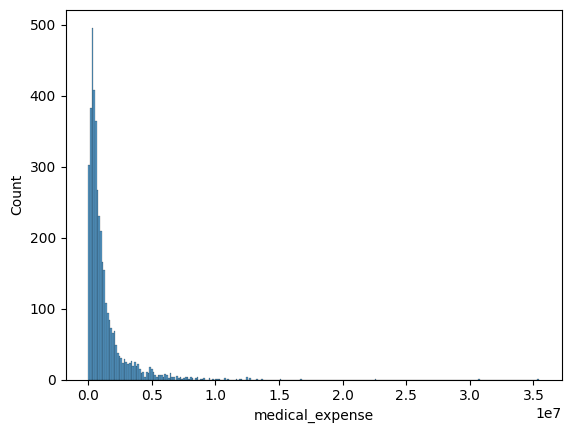

In [106]:
# y 변수 (medical_expense) 분포
# 비용 분포가 왼쪽으로 많이 치우치고, 꼬리가 긺.
sns.histplot(train.medical_expense)

### 4.2.1. 각 변수 타입 별 분리 및 시각화

In [107]:
print(f"ID 컬럼 = {idx_columns}")
print(f"수치형 - 연속형 변수 = {numeric_continuous_cols}")
print(f"수치형 - 이산형 변수 = {numeric_discrete_cols}")
print(f"범주형 - 명목형 변수 = {categorical_nominal_cols}")
print(f"범주형 - 순서형 변수 = {categorical_ordinal_cols}")

ID 컬럼 = ['HHIDWON', 'PIDWON', 'YEAR']
수치형 - 연속형 변수 = ['medical_expense', 'home_labor_income', 'home_asset_income', 'home_total_income', 'home_medical_expense', 'er_tot_expense', 'ou_expense_paid', 'ou_expense_insured', 'ou_expense_uninsured', 'ou_tot_expense', 'in_tot_expense']
수치형 - 이산형 변수 = ['num_years_since_diagnosis', 'age', 'num_years_since_med_pension', 'num_household_members', 'er_days', 'er_num', 'ou_num', 'subjective_health', 'bmi', 'in_num', 'in_num_days', 'avg_weekly_stting_hrs', 'avg_weekday_sleep_hrs', 'avg_weekend_sleep_hrs', 'avg_sleeping_hrs', 'num_bed_confined_days', 'num_diagnosed_household_members', 'ratio_diagnosed_household_members']
범주형 - 명목형 변수 = ['visited_facility_this_year', 'intake_medication_this_year', 'followed_prescription', 'had_medication_side_effects', 'reason_no_intake_involuntary', 'reason_no_intake_unknown', 'reason_no_intake_voluntary', 'medication_satisfaction_dissatisfied', 'medication_satisfaction_satisfied', 'medication_satisfaction_unknown', 'i

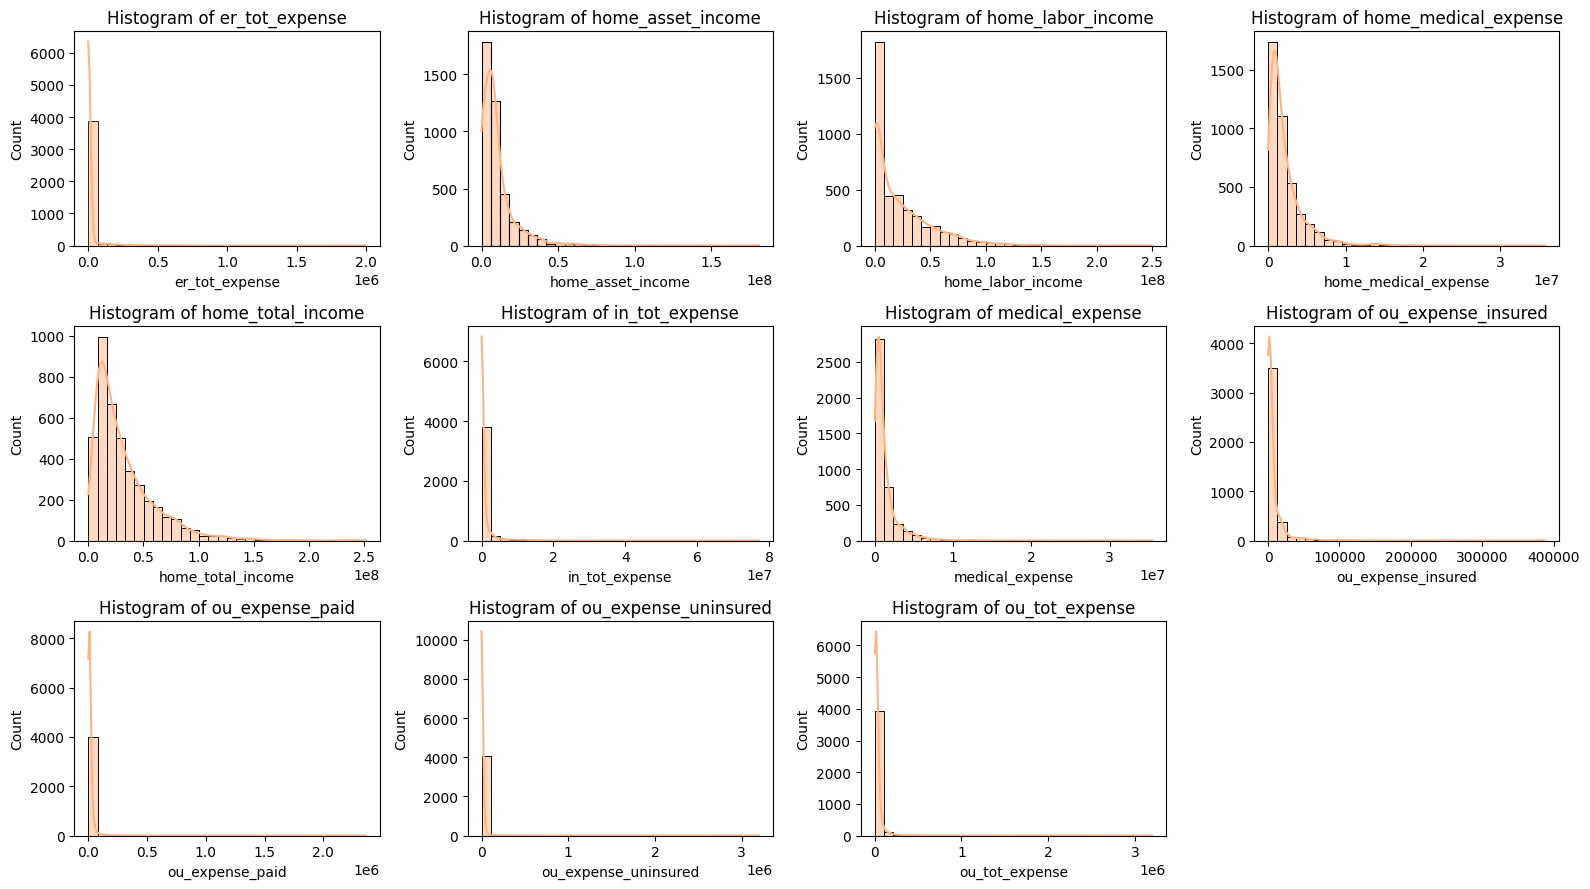

In [108]:
# 수치형 - 연속형 변수 히스토그램: 전체적으로 왼쪽으로 많이 치우치고, 꼬리가 긴 분포가 대다수.
# y변수 (meidcal_expense) 및 그 외 x 변수 모두 로그 변환 + 적용 필수.
draw_histogram(train, numeric_continuous_cols)

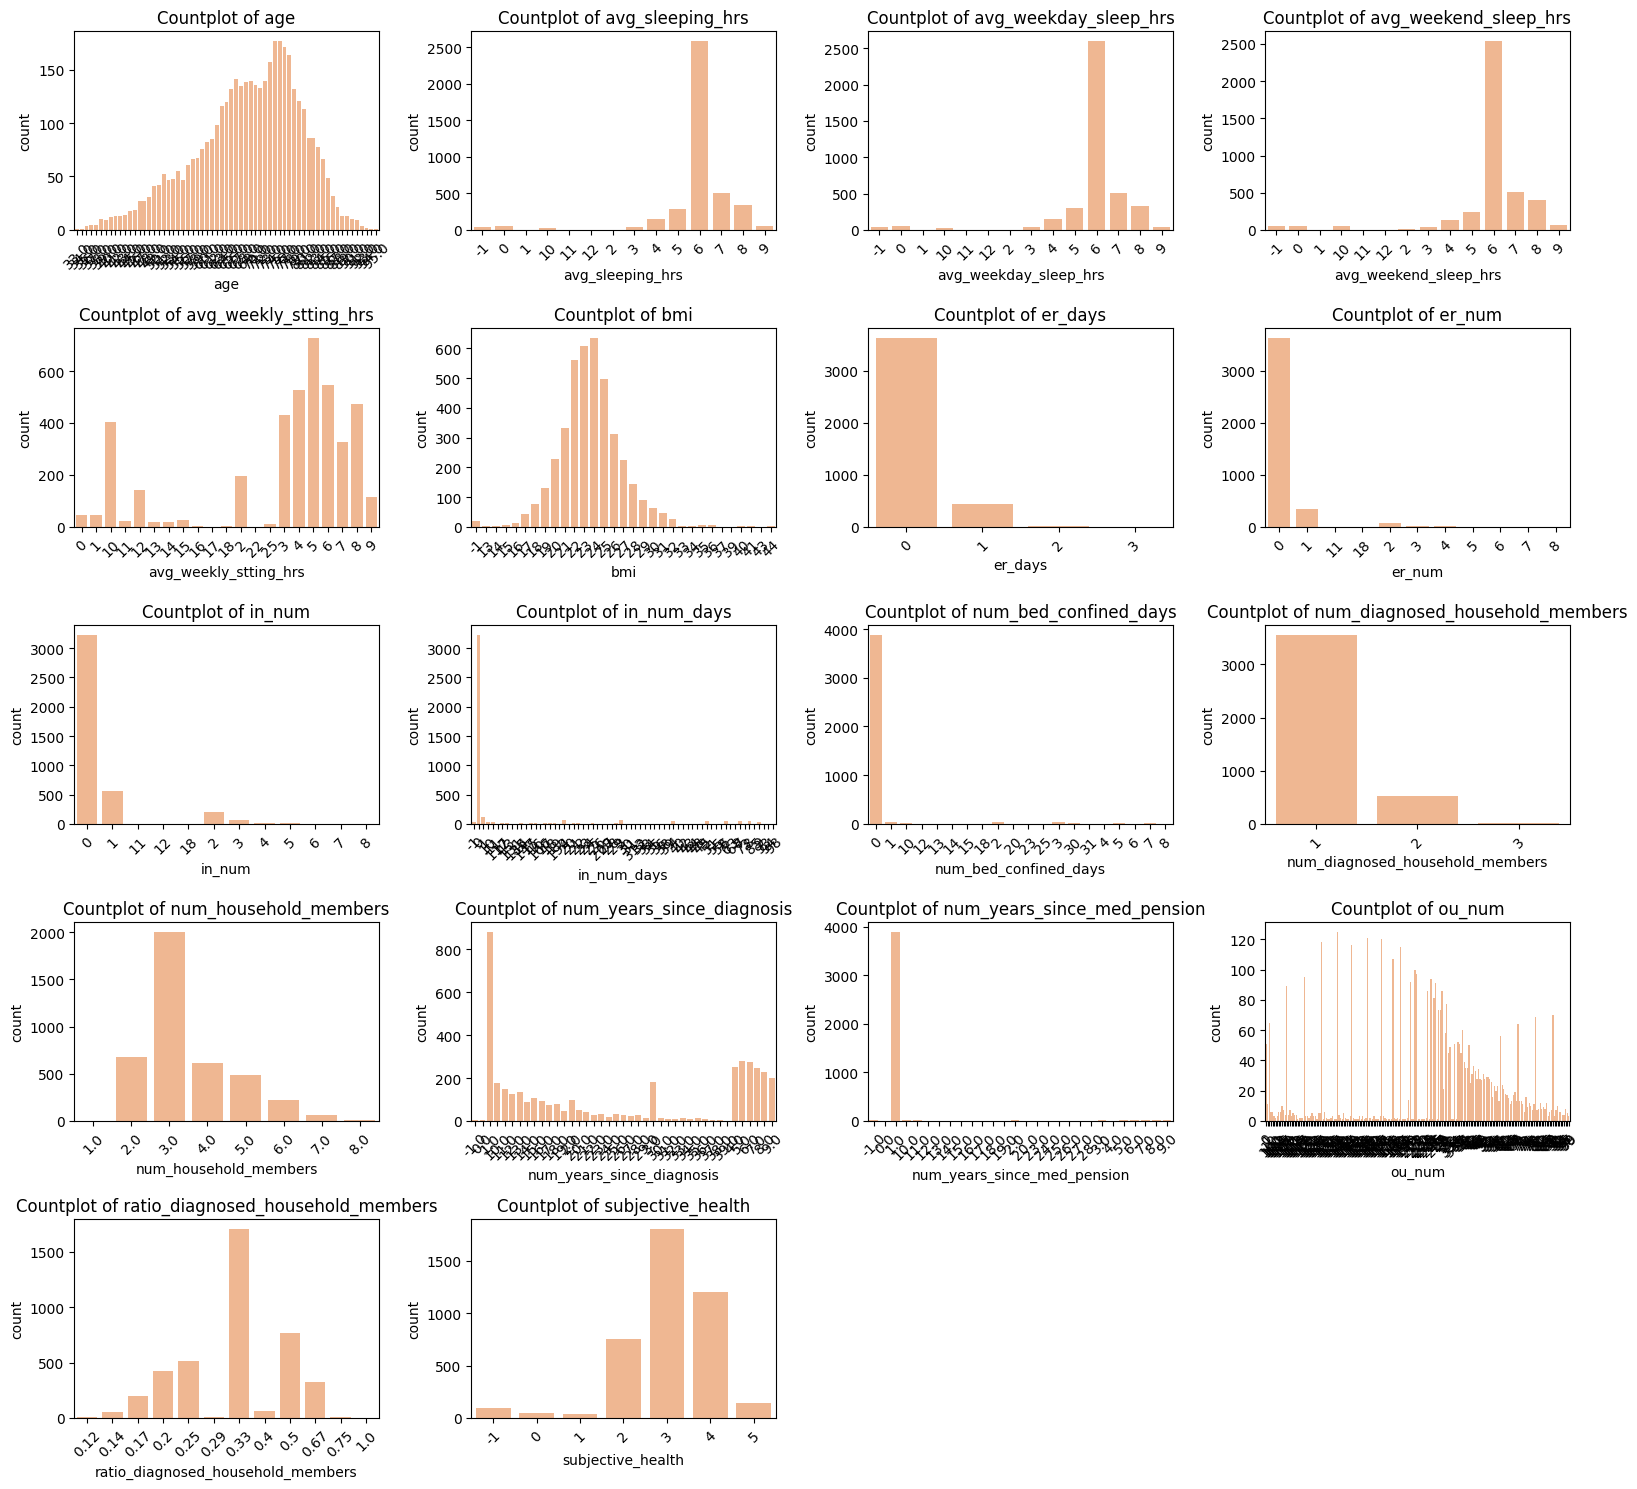

In [109]:
# 수치형 - 이산형 변수 히스토그램: 전체 변수 모두 뚜렷한 특징은 없음.
draw_countplot(X_train, numeric_discrete_cols)

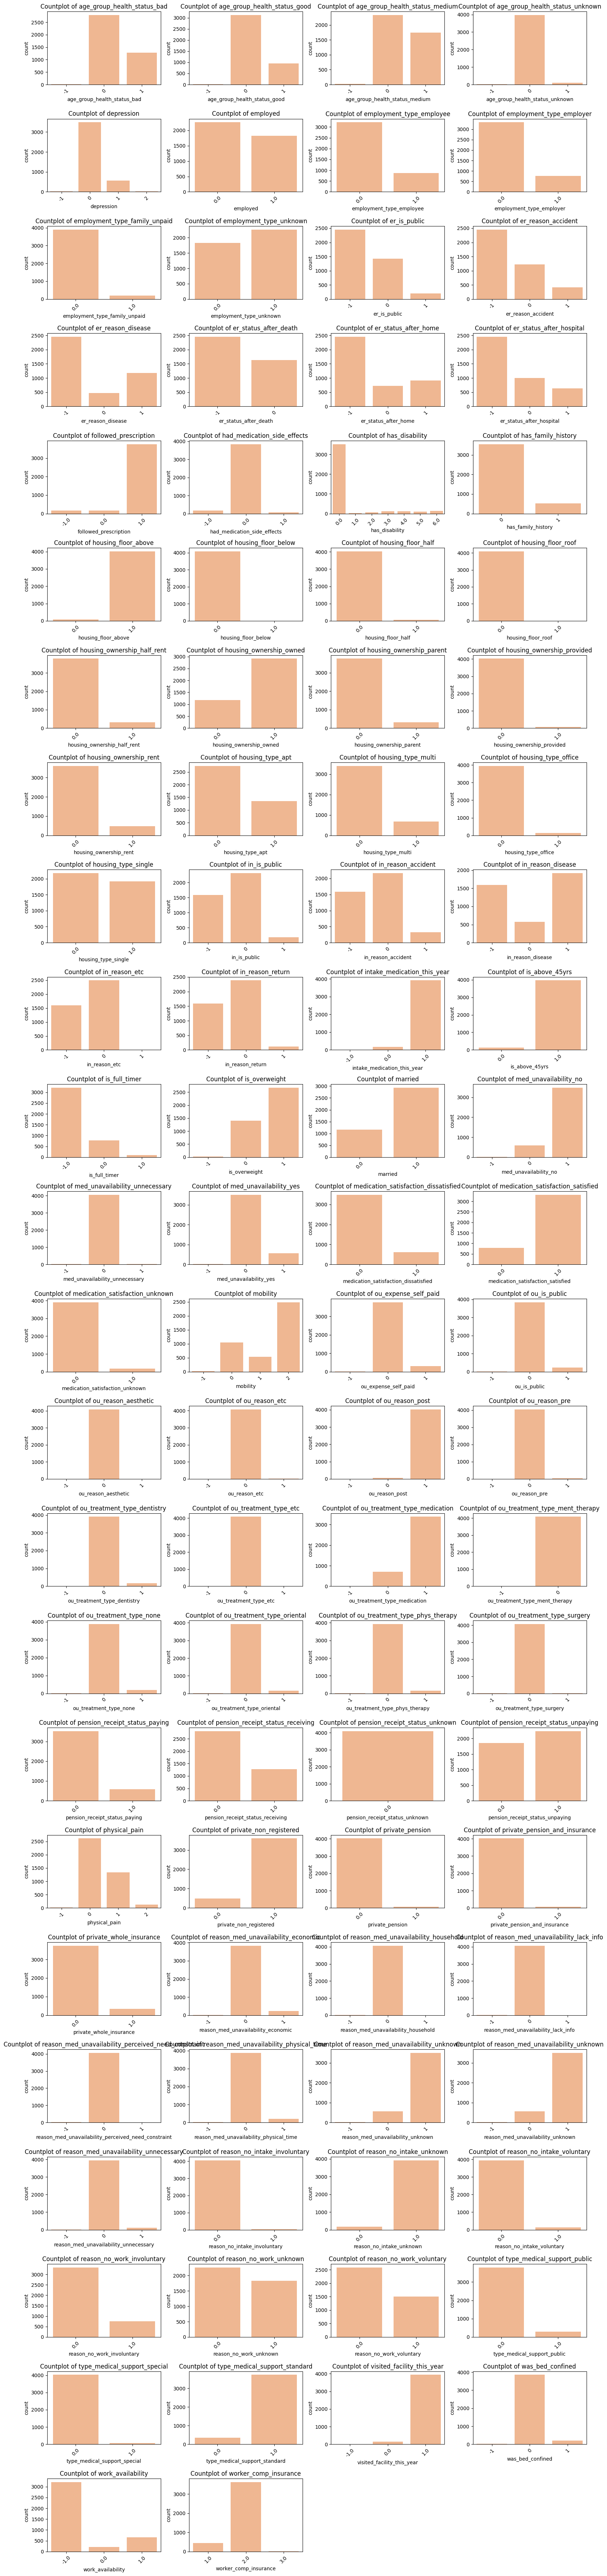

In [110]:
# 범주형 - 명목형 변수 카운트플롯
draw_countplot(X_train, categorical_nominal_cols)

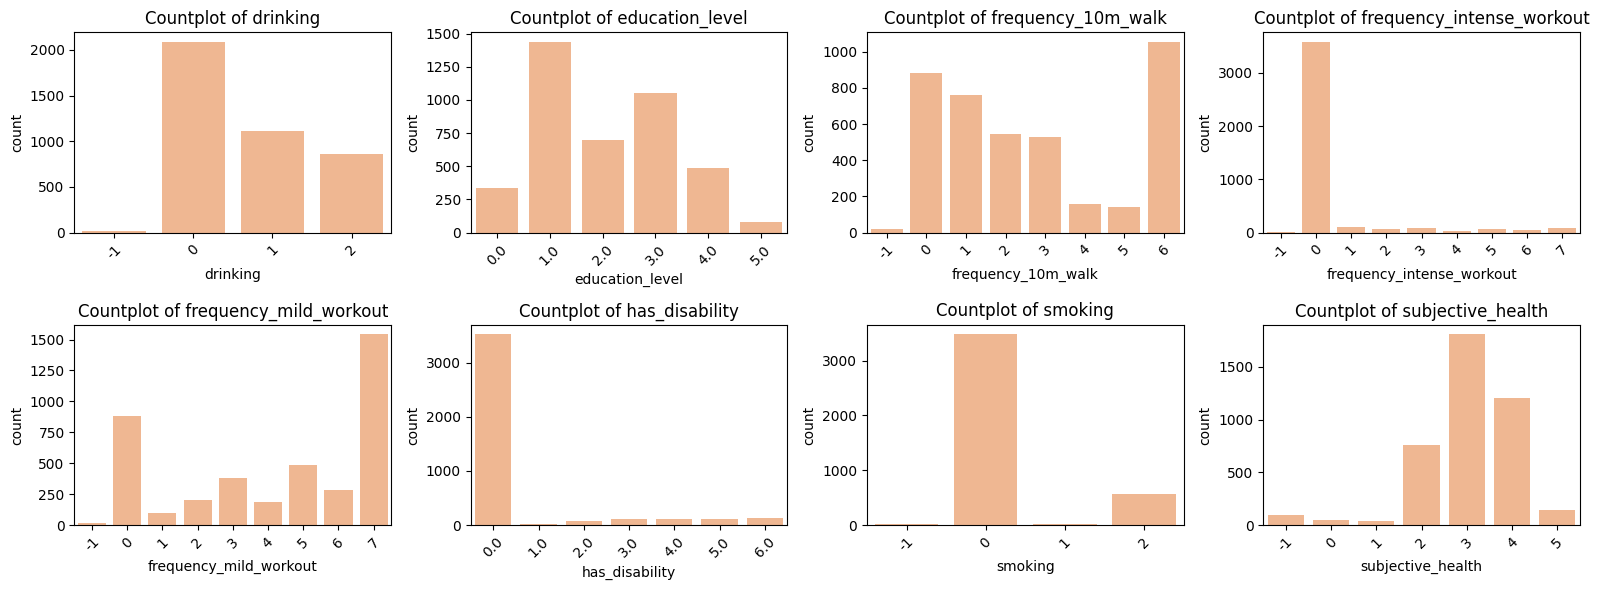

In [111]:
# 범주형 - 순서형 변수 카운트플롯
# 장애 등급, 흡연을 제외한 나머지 변수들에서 고른 비율 분포.
draw_countplot(X_train, categorical_ordinal_cols)

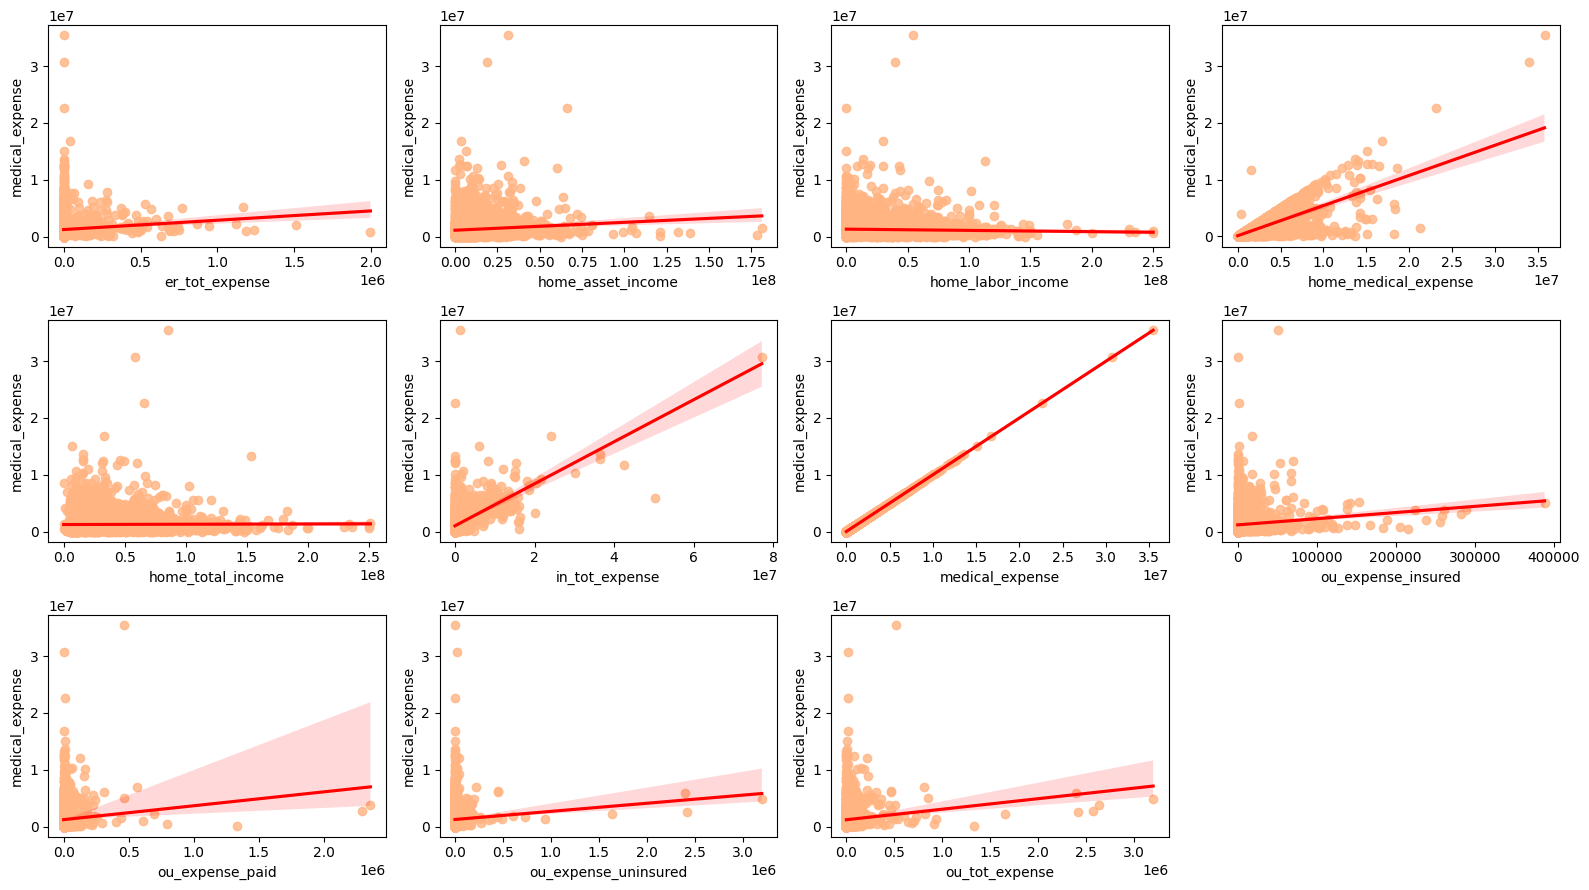

In [112]:
# 수치형 - 연속형 변수 산점도
# home_medical_expense (가구 의료 비용), in_tot_expense (입원 총 비용)에서 y 변수 (총 의료 비용)과 꽤 큰 양의 선형 상관관계 확인
# home_total_income (가구 총 소득), home_labor_income (가구 노동 소득)에서는 약한 음의 상관관계 확인. 
draw_scatterplot(train, numeric_continuous_cols)

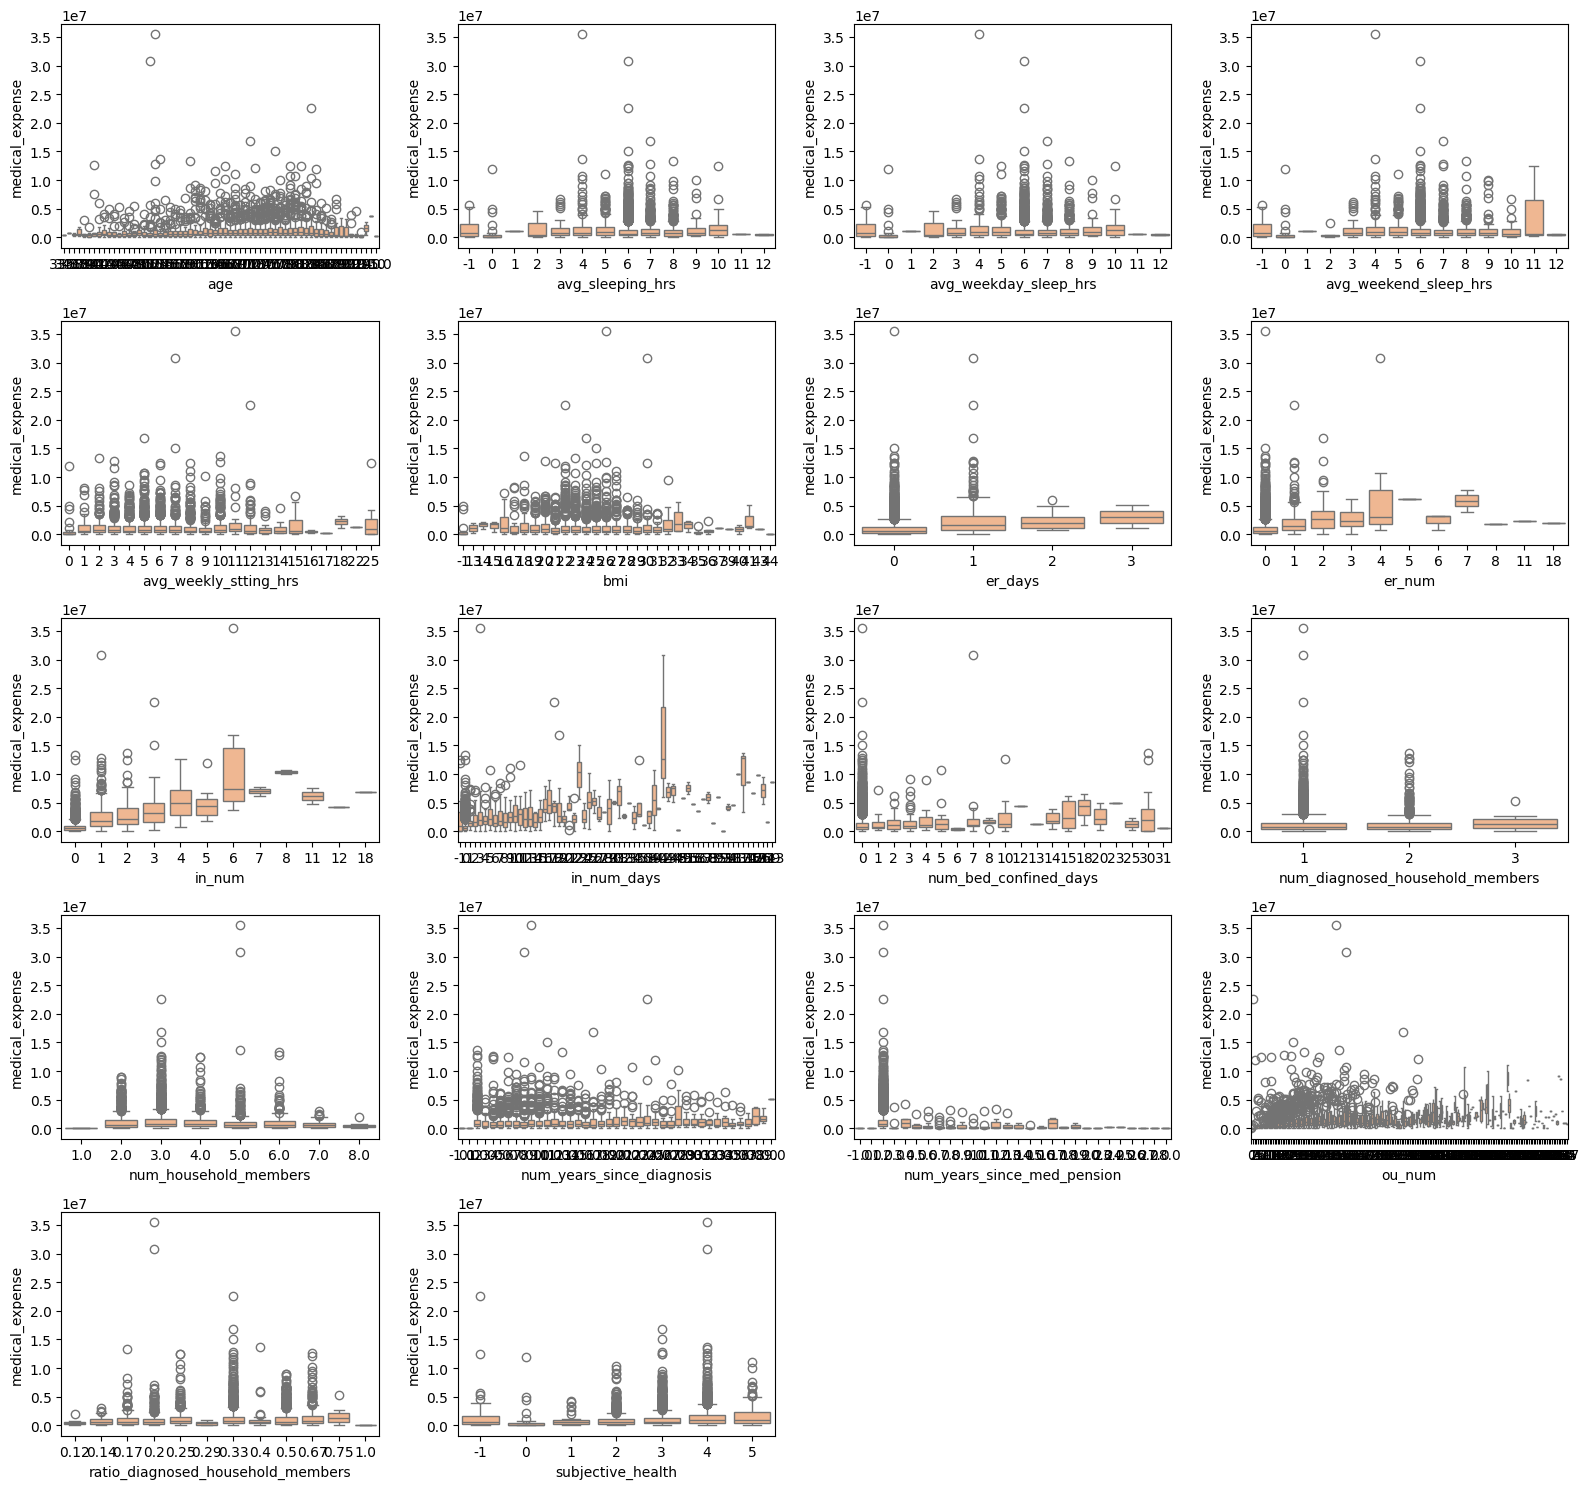

In [113]:
# 수치형 - 이산형 변수 박스플롯
# 각 범주 별 중위값은 의료 비용에 따라 큰 차이가 없으나, 몇몇 극단값들은 의료 비용 지출에 영향을 미칠 수 있음.
# subjective_health (주관적 건강 상태)가 높을수록, 의료 비용도 높은 경향.
draw_boxplot(train, numeric_discrete_cols, type = 'discrete')

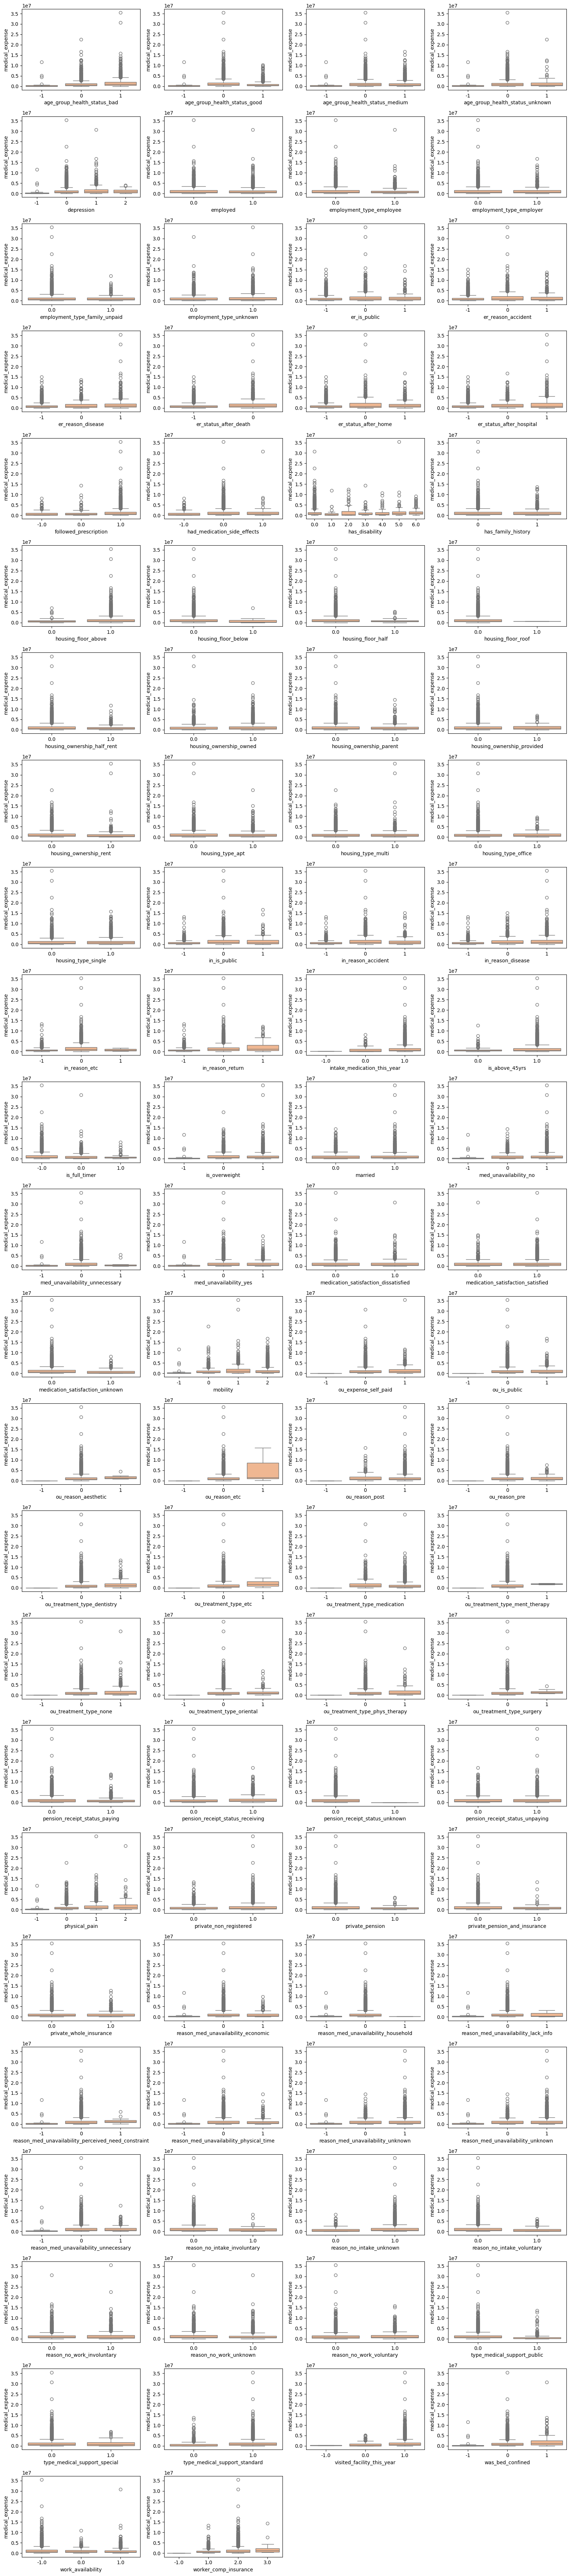

In [114]:
# 범주형 - 명목형 변수 박스플롯
# 마찬가지로, 전체 변수에서 각 범주 별 의료 비용의 중위값은 큰 차이가 없음.
# in_reason_return, is_above_45yrs, physical_pain, was_bed_confined
draw_boxplot(df_final, categorical_nominal_cols, type = 'nominal')

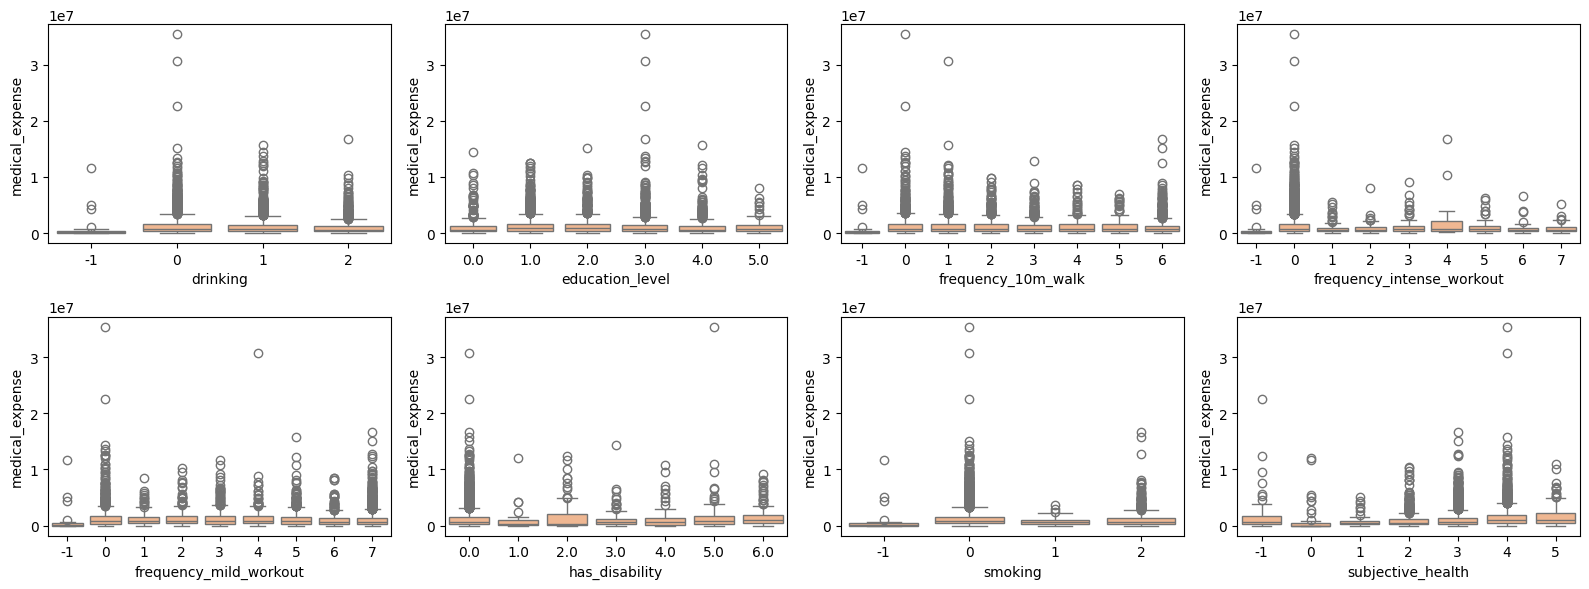

In [115]:
# 범주형 - 순서형 변수 박스플롯
# 명목형 변수에서와도 마찬가지로, 각 범주 별 의료 비용 중위값은 큰 차이가 없음.
# 다만, frequency_intense_workout (고강도 운동 빈도)에서는 전혀 안함 그룹의 의료 비용이 높은 경향
# 고강도 운동을 하지 않는 그룹의 사람들은 주로 고강도 운동이 불가한 노령층이나 환자일 가능성이 있음. 따라서, 전체 의료 비용도 높을 수도.
draw_boxplot(df_final, categorical_ordinal_cols, type = 'ordinal')

(0.0, 5000000.0)

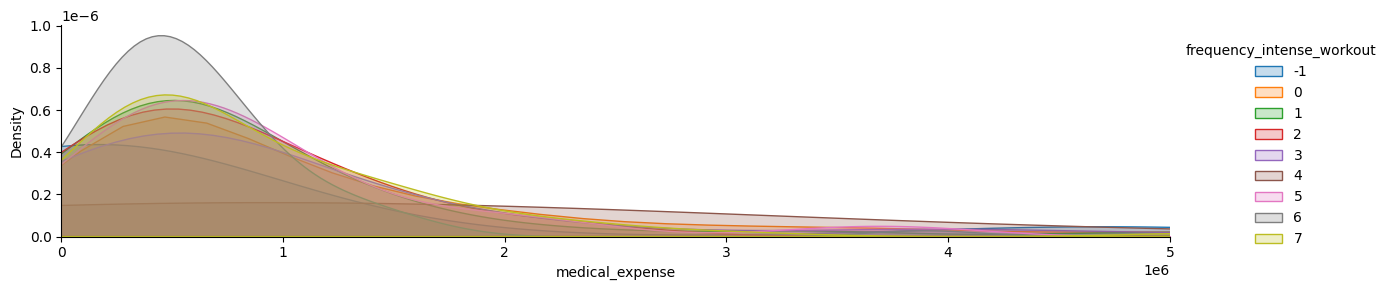

In [116]:
# frequnecy_intense_workout 과 medical_expense의 분포 비교
# boxplot에서도 확인하지 못한, 주 6회 고강도 운동 그룹의 의료 비용이 낮은 곳에 최대 분포.
facet = sns.FacetGrid(train, hue="frequency_intense_workout",aspect=4)
facet.map(sns.kdeplot,'medical_expense',shade= True)
facet.set(xlim=(0, train['medical_expense'].max()))
facet.add_legend()
plt.xlim(0, 5e6)

In [117]:
# 고강도 운동을 주 6회 이상 할수록, 중위 총 의료 비용은 적으나, 표본 수가 적어 신뢰하기 어려움.
train.groupby('frequency_intense_workout').agg(
    group_count = ('frequency_intense_workout', 'count'),
    median_medical_expense = ('medical_expense', 'median'),
    median_age = ('age', 'median'),
).reset_index()


frequency_intense_workout  group_count  median_medical_expense  median_age
0                         -1           20                126136.0        60.5
1                          0         3580                734107.0        71.0
2                          1          101                588200.0        60.0
3                          2           75                587720.0        65.0
4                          3           89                570070.0        63.0
5                          4           23                790900.0        63.0
6                          5           71                642150.0        65.0
7                          6           50                517215.0        66.5
8                          7           79                619500.0        66.0

(0.0, 5000000.0)

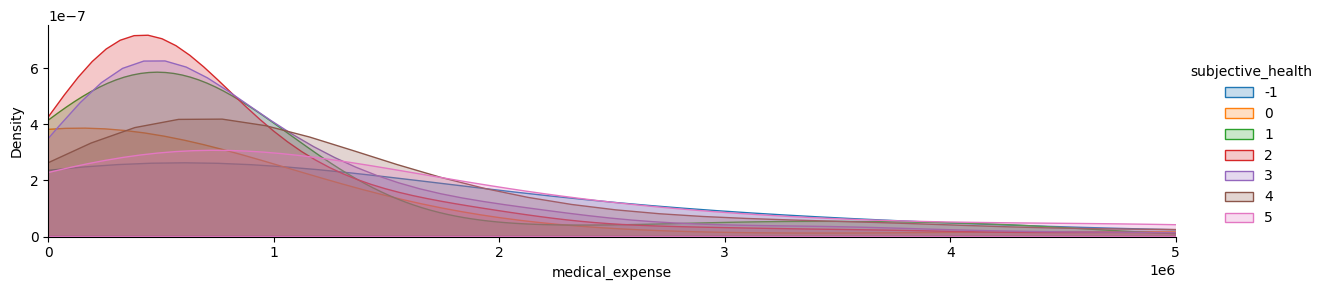

In [118]:
facet = sns.FacetGrid(train, hue="subjective_health",aspect=4)
facet.map(sns.kdeplot,'medical_expense',shade= True)
facet.set(xlim=(0, train['medical_expense'].max()))
facet.add_legend()
plt.xlim(0, 5e6)

In [119]:
train

HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0       10006  1000601                        4.0                         1.0   
1       10006  1000601                        5.0                         1.0   
2       10006  1000601                        6.0                         1.0   
3       10006  1000601                        7.0                         1.0   
5       10006  1000602                        2.0                         1.0   
...       ...      ...                        ...                         ...   
5118    33003  3300304                       10.0                         1.0   
5120    33006  3300603                       13.0                         1.0   
5121    33006  3300603                       14.0                         1.0   
5122    33006  3300603                       15.0                         1.0   
5123    33006  3300603                       16.0                         1.0   

      intake_medication_this_year  followed_prescription  \
0                             1.0                    0.0   
1                             1.0                    1.0   
2                             1.0                    1.0   
3                             1.0                    1.0   
5                             1.0                    0.0   
...                           ...                    ...   
5118                          1.0                    1.0   
5120                          1.0                    1.0   
5121                          1.0                    1.0   
5122                          1.0                    1.0   
5123                          1.0                    1.0   

      had_medication_side_effects  reason_no_intake_involuntary  \
0                             0.0                           0.0   
1                             0.0                           0.0   
2                             0.0                           0.0   
3                             0.0                           0.0   
5                             0.0                           0.0   
...                           ...                           ...   
5118                          0.0                           0.0   
5120                          0.0                           0.0   
5121                          0.0                           0.0   
5122                          0.0                           0.0   
5123                          0.0                           0.0   

      reason_no_intake_unknown  reason_no_intake_voluntary  ...  \
0                          1.0                         0.0  ...   
1                          1.0                         0.0  ...   
2                          1.0                         0.0  ...   
3                          1.0                         0.0  ...   
5                          1.0                         0.0  ...   
...                        ...                         ...  ...   
5118                       1.0                         0.0  ...   
5120                       1.0                         0.0  ...   
5121                       1.0                         0.0  ...   
5122                       1.0                         0.0  ...   
5123                       1.0                         0.0  ...   

      in_tot_expense  in_reason_accident  in_reason_disease  in_reason_etc  \
0                  0                   0                  1              0   
1                  0                   0                  1              0   
2                  0                   0                  1              0   
3                  0                   0                  1              0   
5                  0                  -1                 -1             -1   
...              ...                 ...                ...            ...   
5118          618457                   1                  0              0   
5120               0                   0                  1              0   


(0.0, 5000000.0)

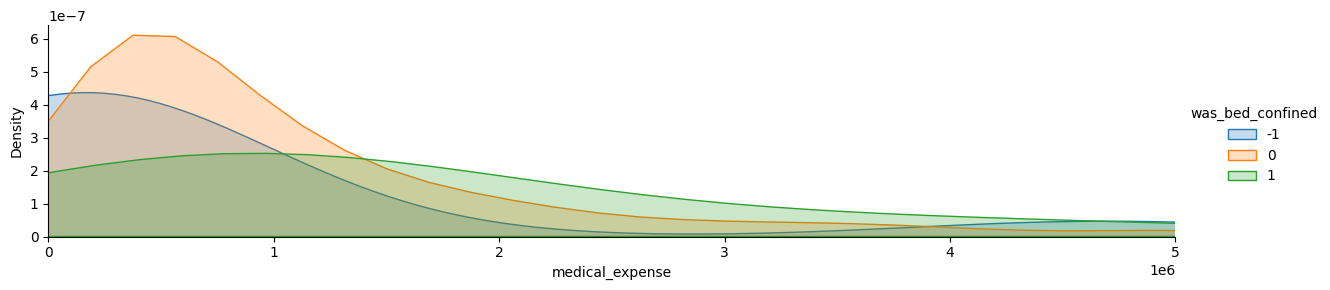

In [121]:
# was_bed_confied (와병 여부)에 따라, 의료 비용도 다르게 나타나는 양상.
facet = sns.FacetGrid(train, hue="was_bed_confined",aspect=4)
facet.map(sns.kdeplot,'medical_expense',shade= True)
facet.set(xlim=(0, train['medical_expense'].max()))
facet.add_legend()
plt.xlim(0, 5e6)

In [122]:
# 각 연도 별 중위 전체 의료 비용은 매해 꾸준히 상승하는 것을 확인할 수 있음.
# 평균은 연도 별 등락이 있으나, 17년도를 제외하고는 전체적으로 꾸준히 증가하는 트렌드.
check_y_by_year(df_final)

num_observations  median_med_exp  mean_med_exp   std_med_exp
YEAR                                                              
2014              1022        622650.0  1.060521e+06  1.387715e+06
2015              1022        677655.0  1.234180e+06  1.847384e+06
2016              1022        762080.0  1.380806e+06  2.019528e+06
2017              1022        783450.0  1.316569e+06  1.608689e+06
2018              1022        869058.0  1.462572e+06  1.786851e+06

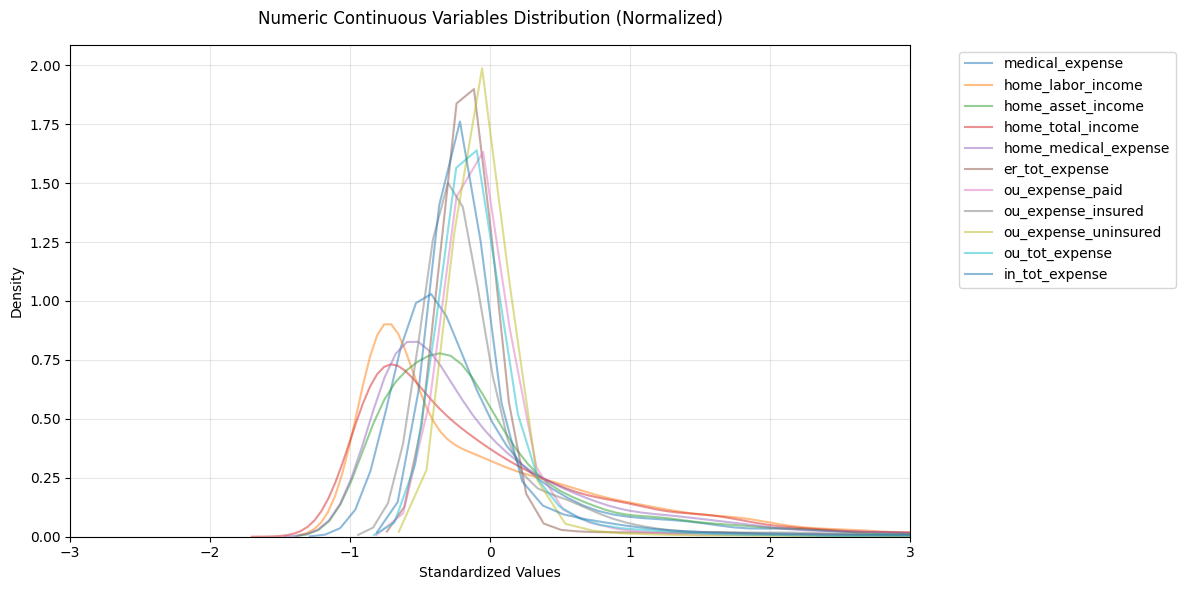

In [123]:
# 수치형 - 연속형 변수들 vs y 변수간의 분포 비교: scaled
# 정규화된 분포는 대체적으로 유사.
# 특히, in_tot_expense (입원 총 비용), er_tot_expense (응급실 총 비용), ou_expense_uninsured (본인 부담금 총 비용)가 종속변수와 분포 유사.
# 당연하게도, 전체 의료 비용과 각 의료 비용 간의 관계는 매우 유사할 수밖에 없음.
draw_kde_plot(train, numeric_continuous_cols)


## 4.3. 상관 분석

### 4.3.1. X (수치형 - 연속형) ~ Y (수치형 - 연속형)

- 정규성 가정 충족 시: Pearson
- 정규성 가종 불충족 시: Separman 상관분석 

1. home_medical_expense (상관계수: 0.713, p-value < 0.05)
    - 가구 의료비용과 매우 강한 양의 상관관계를 보이며, 가구 의료비용이 증가할수록 개인 의료비용도 함께 증가하는 경향이 있음
    - 이는 가구 단위의 의료비용이 개인 의료비용의 주요 결정 요인임을 시사

2. in_tot_expense (상관계수: 0.473, p-value < 0.05)
    - 입원 총비용과 중간 정도의 양의 상관관계를 보이며, 입원 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 입원이 의료비용에 상당한 영향을 미치는 요인임을 시사
    
3. ou_tot_expense (상관계수: 0.197, p-value < 0.05)
    - 외래 총비용과 약한 양의 상관관계를 보이며, 외래 진료 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 외래 진료가 의료비용에 일정한 영향을 미치는 요인임을 시사

4. ou_expense_insured (상관계수: 0.184, p-value < 0.05)
    - 보험 적용 외래비용과 약한 양의 상관관계를 보이며, 보험 적용 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 보험 적용 비용이 의료비용에 일정한 영향을 미치는 요인임을 시사

5. ou_expense_uninsured (상관계수: 0.180, p-value < 0.05)
    - 비보험 외래비용과 약한 양의 상관관계를 보이며, 비보험 비용이 높을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 비보험 비용이 의료비용에 일정한 영향을 미치는 요인임을 시사

6. er_tot_expense (상관계수: 0.169, p-value < 0.05)
    - 응급실 총비용과 약한 양의 상관관계를 보이며, 이는 개인 의료비용에 미치는 영향이 제한적임을 시사

7. home_asset_income (상관계수: 0.130, p-value < 0.05)
    - 가구 자산소득은 매우 약한 양의 상관관계를 보이며, 이는 자산소득이 의료비용에 미치는 영향이 제한적임을 시사

8. ou_expense_paid (상관계수: 0.097, p-value < 0.05)
    - 본인부담 외래비용은 매우 약한 양의 상관관계를 보이며, 이는 본인부담 비용이 의료비용에 미치는 영향이 제한적임을 시사

9. home_total_income (상관계수: 0.040, p-value < 0.05)
    - 가구 총소득은 매우 약한 양의 상관관계를 보이며, 이는 총소득이 의료비용에 미치는 영향이 제한적임을 시사

10. home_labor_income (상관계수: -0.034, p-value < 0.05)
    - 가구 노동소득은 매우 약한 음의 상관관계를 보이며, 이는 노동소득이 의료비용에 미치는 영향이 제한적임을 시사

In [124]:
continuous_correlation_test(train, numeric_continuous_cols, 'medical_expense')

medical_expense home_labor_income home_asset_income  \
type             continuous        continuous        continuous   
test               spearman          spearman          spearman   
correlation             1.0         -0.034114          0.129549   
p_value                 0.0          0.029174               0.0   

            home_total_income home_medical_expense er_tot_expense  \
type               continuous           continuous     continuous   
test                 spearman             spearman       spearman   
correlation          0.040324             0.713349       0.168641   
p_value              0.009924                  0.0            0.0   

            ou_expense_paid ou_expense_insured ou_expense_uninsured  \
type             continuous         continuous           continuous   
test               spearman           spearman             spearman   
correlation         0.09725           0.183959             0.180203   
p_value                 0.0                0.0                  0.0   

            ou_tot_expense in_tot_expense  
type            continuous     continuous  
test              spearman       spearman  
correlation       0.197049        0.47288  
p_value                0.0            0.0

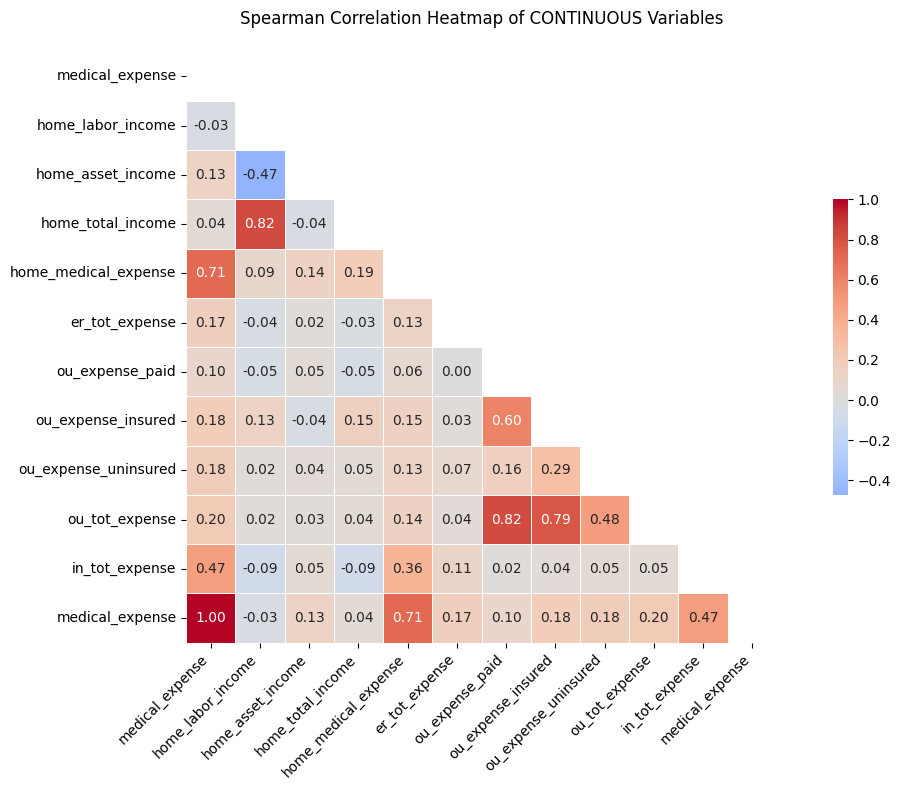

In [125]:
plot_correlation_matrix(train, numeric_continuous_cols, 'medical_expense', 'spearman', type = 'continuous')

### 4.3.2. X (수치형 - 이산형) ~ Y (수치형 - 연속형): Separman 상관분석 

1. in_num (상관계수: 0.469, p-value < 0.05)
    - 입원 횟수와 중간 정도의 양의 상관관계를 보이며, 입원 횟수가 많을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 입원이 의료비용에 상당한 영향을 미치는 요인임을 시사

2. in_num_days (상관계수: 0.466, p-value < 0.05)
입원 일수와 중간 정도의 양의 상관관계를 보이며, 입원 기간이 길수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 입원 기간이 의료비용에 상당한 영향을 미치는 요인임을 시사

3. ou_num (상관계수: 0.459, p-value < 0.05)
    - 외래 방문 횟수와 중간 정도의 양의 상관관계를 보이며, 외래 방문이 많을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 외래 진료가 의료비용에 상당한 영향을 미치는 요인임을 시사

4. er_num (상관계수: 0.261, p-value < 0.05)
    - 응급실 방문 횟수와 약한 양의 상관관계를 보이며, 응급실 방문이 많을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 응급실 이용이 의료비용에 일정한 영향을 미치는 요인임을 시사

5. er_days (상관계수: 0.258, p-value < 0.05)
    - 응급실 방문 일수와 약한 양의 상관관계를 보이며, 응급실 이용 기간이 길수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 응급실 이용 기간이 의료비용에 일정한 영향을 미치는 요인임을 시사

6. subjective_health (상관계수: 0.185, p-value < 0.05)
    - 주관적 건강상태와 약한 양의 상관관계를 보이며, 건강상태가 좋을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 주관적 건강상태가 의료비용에 일정한 영향을 미치는 요인임을 시사

7. num_years_since_med_pension (상관계수: -0.193, p-value < 0.05)
    - 의료급여 수급 기간과 약한 음의 상관관계를 보이며, 수급 기간이 길수록 개인 의료비용은 감소하는 경향이 있음
    - 이는 의료급여 수급이 의료비용에 일정한 영향을 미치는 요인임을 시사

8. num_diagnosed_household_members (상관계수: 0.093, p-value < 0.05)
    - 진단받은 가족원 수와 매우 약한 양의 상관관계를 보이며, 이는 가족의 진단 수가 의료비용에 미치는 영향이 제한적임을 시사

9. num_household_members (상관계수: -0.047, p-value < 0.05)
    - 가구원 수와 매우 약한 음의 상관관계를 보이며, 이는 가구원 수가 의료비용에 미치는 영향이 제한적임을 시사

10. age (상관계수: 0.077, p-value < 0.05)
age (상관계수: 0.077, p-value < 0.05)
    - 나이와 매우 약한 양의 상관관계를 보이며, 이는 나이가 의료비용에 미치는 영향이 제한적임을 시사

11. num_years_since_diagnosis (상관계수: 0.033, p-value < 0.05)
    - 진단 후 경과 기간과 매우 약한 양의 상관관계를 보이며, 이는 진단 후 경과 기간이 의료비용에 미치는 영향이 제한적임을 시사

12. ratio_diagnosed_household_members (상관계수: 0.039, p-value < 0.05)
    - 진단받은 가족원 비율과 매우 약한 양의 상관관계를 보이며, 이는 진단받은 가족원 비율이 의료비용에 미치는 영향이 제한적임을 시사

13. bmi (상관계수: 0.001, p-value = 0.925)
    - BMI와 거의 상관관계가 없으며, 이는 BMI가 의료비용에 미치는 영향이 거의 없음을 시사

14. avg_weekly_stting_hrs (상관계수: 0.021, p-value = 0.171)
    - 주간 평균 앉아있는 시간과 상관관계가 없으며, 이는 앉아있는 시간이 의료비용에 미치는 영향이 없음을 시사

15. avg_weekday_sleep_hrs (상관계수: 0.015, p-value = 0.352)
    - 평일 평균 수면시간과 상관관계가 없으며, 이는 평일 수면시간이 의료비용에 미치는 영향이 없음을 시사

16. avg_weekend_sleep_hrs (상관계수: 0.014, p-value = 0.379)
    - 주말 평균 수면시간과 상관관계가 없으며, 이는 주말 수면시간이 의료비용에 미치는 영향이 없음을 시사

17. avg_sleeping_hrs (상관계수: 0.014, p-value = 0.469)
    - 평균 수면시간과 상관관계가 없으며, 이는 수면시간이 의료비용에 미치는 영향이 없음을 시사

18. num_bed_confied_days (상관계수: 0.011, p-value = 0.470)
- 침상 제한 일수와 상관관계가 없으며, 이는 침상 제한이 의료비용에 미치는 영향이 없음을 시사

In [126]:
ordinal_correlation_test(train, numeric_discrete_cols, 'medical_expense')

num_years_since_diagnosis       age num_years_since_med_pension  \
type                          ordinal   ordinal                     ordinal   
test                         spearman  spearman                    spearman   
correlation                  0.033499   0.07676                   -0.193199   
p_value                      0.032213  0.000001                         0.0   

            num_household_members   er_days    er_num    ou_num  \
type                      ordinal   ordinal   ordinal   ordinal   
test                     spearman  spearman  spearman  spearman   
correlation             -0.047242  0.258444  0.260594  0.459077   
p_value                  0.002517       0.0       0.0       0.0   

            subjective_health       bmi    in_num in_num_days  \
type                  ordinal   ordinal   ordinal     ordinal   
test                 spearman  spearman  spearman    spearman   
correlation          0.185062  0.001466  0.469263    0.465945   
p_value                   0.0  0.925327       0.0         0.0   

            avg_weekly_stting_hrs avg_weekday_sleep_hrs avg_weekend_sleep_hrs  \
type                      ordinal               ordinal               ordinal   
test                     spearman              spearman              spearman   
correlation              0.021422              0.014569              0.013777   
p_value                  0.170862              0.351709              0.378523   

            avg_sleeping_hrs num_bed_confined_days  \
type                 ordinal               ordinal   
test                spearman              spearman   
correlation         0.011304              0.093223   
p_value             0.469955                   0.0   

            num_diagnosed_household_members ratio_diagnosed_household_members  
type                                ordinal                           ordinal  
test                               spearman                          spearman  
correlation                        0.006549                          0.039003  
p_value                            0.675511                          0.012634

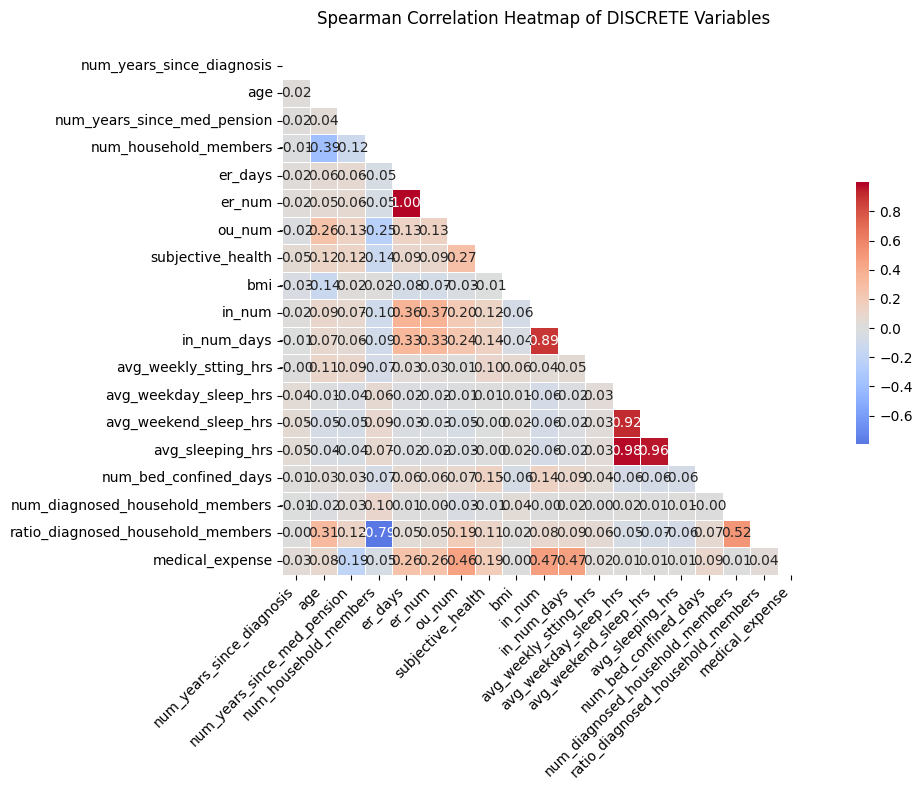

In [127]:
plot_correlation_matrix(train, numeric_discrete_cols, 'medical_expense', 'spearman', type = 'discrete')

### 4.3.2. X (범주형 - 순서형) ~ Y (수치형 - 연속형): Separman 상관분석 

1. subjective_health (상관계수: 0.185, p-value < 0.05)
    - 주관적 건강상태와 약한 양의 상관관계를 보이며, 건강상태가 좋을수록 개인 의료비용도 증가하는 경향이 있음
    - 이는 주관적 건강상태가 의료비용에 일정한 영향을 미치는 요인임을 시사

2. drinking (상관계수: -0.075, p-value < 0.05)
    - 음주와 약한 음의 상관관계를 보이며, 음주 빈도가 높을수록 개인 의료비용은 감소하는 경향이 있음
    - 이는 음주가 의료비용에 일정한 영향을 미치는 요인임을 시사

3. smoking (상관계수: -0.043, p-value < 0.05)
    - 흡연과 매우 약한 음의 상관관계를 보이며, 이는 흡연이 의료비용에 미치는 영향이 제한적임을 시사

4. education_level (상관계수: -0.014, p-value = 0.375)
    - 교육수준과 상관관계가 없으며, 이는 교육수준이 의료비용에 미치는 영향이 없음을 시사

5. frequency_intense_workout (상관계수: -0.024, p-value = 0.119)
    - 격렬한 운동 빈도와 상관관계가 없으며, 이는 격렬한 운동이 의료비용에 미치는 영향이 없음을 시사

6. frequency_mild_workout (상관계수: -0.023, p-value = 0.147)
    - 가벼운 운동 빈도와 상관관계가 없으며, 이는 가벼운 운동이 의료비용에 미치는 영향이 없음을 시사

7. frequency_10m_walk (상관계수: -0.019, p-value = 0.225)
    - 10분 이상 걷기 빈도와 상관관계가 없으며, 이는 걷기가 의료비용에 미치는 영향이 없음을 시사

8. has_disability (상관계수: -0.021, p-value = 0.181)
    - 장애 여부와 상관관계가 없으며, 이는 장애가 의료비용에 미치는 영향이 없음을 시사


In [128]:
ordinal_results = ordinal_correlation_test(train, categorical_ordinal_cols, 'medical_expense')
ordinal_results

education_level   smoking  drinking frequency_intense_workout  \
type                ordinal   ordinal   ordinal                   ordinal   
test               spearman  spearman  spearman                  spearman   
correlation       -0.026423  -0.06462 -0.090669                 -0.047562   
p_value            0.091184  0.000036       0.0                  0.002352   

            frequency_mild_workout frequency_10m_walk subjective_health  \
type                       ordinal            ordinal           ordinal   
test                      spearman           spearman          spearman   
correlation              -0.029439          -0.026287          0.185062   
p_value                   0.059824            0.09286               0.0   

            has_disability  
type               ordinal  
test              spearman  
correlation      -0.020911  
p_value           0.181307

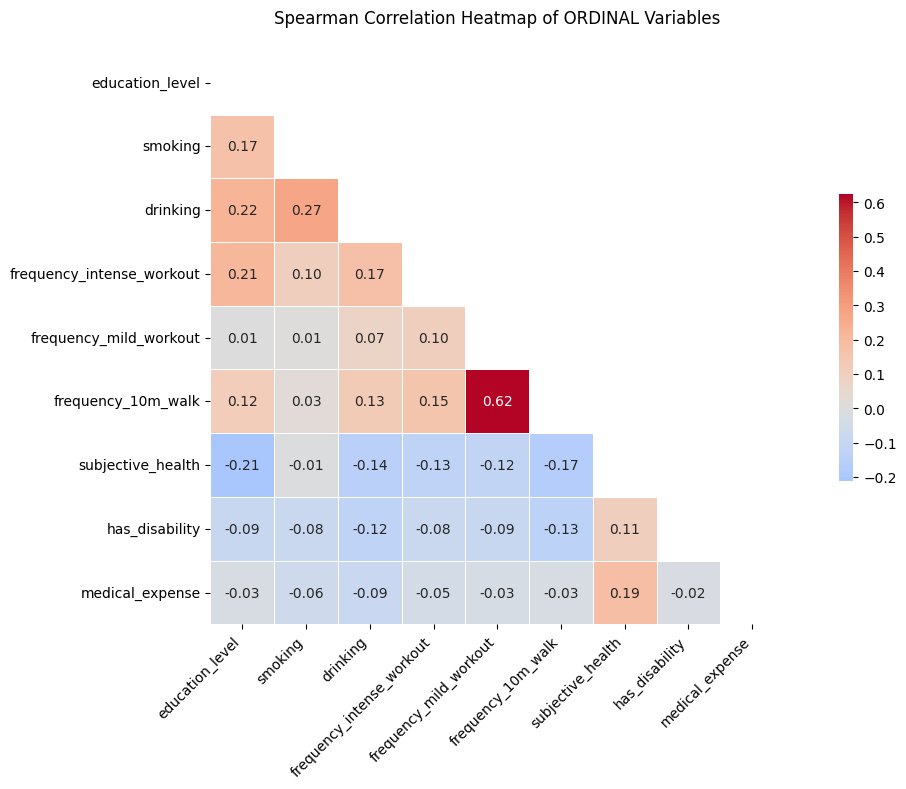

In [129]:
plot_correlation_matrix(train, categorical_ordinal_cols, 'medical_expense', 'spearman', type = 'ordinal')

### 4.1.3. X (범주형 - 명목형) ~ Y (수치형 - 연속형): ANOVA 상관분석 

- 그룹 2개인 경우: point_biserial

- 3개 이상 그룹 있는 경우
    - 정규성 가정 충족 시: ANOVA
    - 정규성 가정 불충족 시: kruskal-wallis

- 주로 입원, 응급실 등 의료 서비스 이유 / 종류에 따라 의료 비용 상관관계가 높아지는 양상.
- 하지만, 눈에 띄는 (선형) 상관관계는 마찬가지로 존재 X.

In [130]:
pd.set_option('display.max_rows', 150)


nominal_results = analyze_categorical_continuous_relationship(train, categorical_nominal_cols, 'medical_expense')#.sort_values('correlation', ascending=False)
nominal_results

visited_facility_this_year intake_medication_this_year  \
type                           nominal                     nominal   
test                           kruskal                     kruskal   
correlation                   0.088332                    0.086266   
effect_size                   0.007803                    0.007442   
p_value                            0.0                         0.0   
reason                             NaN                         NaN   

            followed_prescription had_medication_side_effects  \
type                      nominal                     nominal   
test                      kruskal                     kruskal   
correlation              0.107319                    0.088299   
effect_size              0.011517                    0.007797   
p_value                       0.0                         0.0   
reason                        NaN                         NaN   

            reason_no_intake_involuntary reason_no_intake_unknown  \
type                             nominal                  nominal   
test                      point_biserial           point_biserial   
correlation                    -0.015926                 0.045924   
effect_size                     0.236123                   0.2711   
p_value                         0.308683                 0.003315   
reason                               NaN                      NaN   

            reason_no_intake_voluntary medication_satisfaction_dissatisfied  \
type                           nominal                              nominal   
test                    point_biserial                       point_biserial   
correlation                  -0.042928                              0.01575   
effect_size                   0.274977                             0.041147   
p_value                       0.006049                             0.314035   
reason                             NaN                                  NaN   

            medication_satisfaction_satisfied medication_satisfaction_unknown  \
type                                  nominal                         nominal   
test                           point_biserial                  point_biserial   
correlation                          0.011628                       -0.048109   
effect_size                         -0.028585                        0.281474   
p_value                              0.457329                        0.002092   
reason                                    NaN                             NaN   

             ... in_reason_disease in_reason_etc in_reason_return  \
type         ...           nominal       nominal          nominal   
test         ...           kruskal       kruskal          kruskal   
correlation  ...          0.269755      0.265259         0.264295   
effect_size  ...          0.072768      0.070362         0.069852   
p_value      ...               0.0           0.0              0.0   
reason       ...               NaN           NaN              NaN   

            was_bed_confined  is_above_45yrs age_group_health_status_bad  \
type                 nominal         nominal                     nominal   
test                 kruskal  point_biserial                     kruskal   
correlation          0.11018        0.020599                    0.165167   
effect_size          0.01214        0.122188                     0.02728   
p_value                  0.0        0.187905                         0.0   
reason                   NaN             NaN                         NaN   

            age_group_health_status_good age_group_health_status_medium  \
type                             nominal                        nominal   
test                             kruskal                        kruskal   
correlation                     0.159323                       0.069016   
effect_size                     0.025384                       0.004763   
p_value                              0.0                       0.00

## 4.4. 다중공성성 체크

In [131]:
X_all_vif = add_constant(X_train.astype('float64'))
# X_all_vif

vif_df_all = pd.DataFrame()
vif_df_all["feature"] = X_all_vif.columns
vif_df_all["VIF"] = [variance_inflation_factor(X_all_vif.values, i) for i in range(X_all_vif.shape[1])]
vif_df_all = vif_df_all.sort_values(by='VIF', ascending=False)
multicolinear_cols = vif_df_all[vif_df_all['VIF'] > 10]['feature'].tolist()
print(f"다중공선성 문제가 있는 변수: {multicolinear_cols}")
print(f"총 제거한 다중공선성 변수의 수: {len(multicolinear_cols)}")
vif_df_all

다중공선성 문제가 있는 변수: ['housing_type_single', 'med_unavailability_yes', 'housing_type_multi', 'housing_type_apt', 'housing_ownership_parent', 'reason_no_work_unknown', 'employment_type_unknown', 'employment_type_employer', 'med_unavailability_no', 'reason_med_unavailability_unknown', 'employed', 'pension_receipt_status_receiving', 'housing_floor_above', 'med_unavailability_unnecessary', 'housing_ownership_owned', 'pension_receipt_status_unpaying', 'housing_type_office', 'housing_ownership_rent', 'private_whole_insurance', 'housing_floor_half', 'pension_receipt_status_paying', 'reason_no_intake_unknown', 'housing_ownership_half_rent', 'private_non_registered', 'reason_no_intake_voluntary', 'housing_floor_roof', 'employment_type_family_unpaid', 'private_pension', 'housing_ownership_provided', 'employment_type_employee', 'reason_no_intake_involuntary', 'private_pension_and_insurance', 'housing_floor_below', 'ou_tot_expense', 'ou_expense_uninsured', 'ou_expense_paid', 'home_total_income', 'home

feature           VIF
48                                 housing_type_single           inf
109                             med_unavailability_yes           inf
46                                  housing_type_multi           inf
45                                    housing_type_apt           inf
51                            housing_ownership_parent           inf
35                              reason_no_work_unknown           inf
29                             employment_type_unknown           inf
27                            employment_type_employer           inf
107                              med_unavailability_no           inf
115                  reason_med_unavailability_unknown           inf
16                                            employed           inf
23                    pension_receipt_status_receiving  9.007199e+15
54                                 housing_floor_above  9.007199e+15
108                     med_unavailability_unnecessary  9.007199e+15
50                             housing_ownership_owned  4.503600e+15
25                     pension_receipt_status_unpaying  4.503600e+15
47                                 housing_type_office  3.002400e+15
53                              housing_ownership_rent  3.002400e+15
33                             private_whole_insurance  2.251800e+15
56                                  housing_floor_half  1.801440e+15
22                       pension_receipt_status_paying  1.501200e+15
7                             reason_no_intake_unknown  1.501200e+15
49                         housing_ownership_half_rent  1.286743e+15
30                              private_non_registered  1.286743e+15
8                           reason_no_intake_voluntary  1.125900e+15
57                                  housing_floor_roof  1.000800e+15
28                       employment_type_family_unpaid  9.007199e+14
31                                     private_pension  9.007199e+14
52                          housing_ownership_provided  6.433714e+14
26                            employment_type_employee  5.004000e+14
6                         reason_no_intake_involuntary  3.336000e+14
32                       private_pension_and_insurance  7.036874e+13
55                                 housing_floor_below  5.298353e+13
72                                      ou_tot_expense  1.190643e+06
71                                ou_expense_uninsured  6.398340e+05
69                                     ou_expense_paid  3.773829e+05
43                                   home_total_income  2.906141e+05
41                                   home_labor_income  2.830604e+05
42                                   home_asset_income  5.497152e+04
70                                  ou_expense_insured  3.412296e+04
36                            reason_no_work_voluntary  1.144448e+03
39                       type_medical_support_standard  8.580384e+02
10                   medication_satisfaction_satisfied  7.826824e+02
34                          reason_no_work_involuntary  7.440956e+02
37                         type_medical_support_public  7.216467e+02
9                 medication_satisfaction_dissatisfied  6.411646e+02
11                     medication_satisfaction_unknown  2.814346e+02
110                 reason_med_unavailability_economic  2.600048e+02
64                               er_status_after_death  2.397790e+02
105                     age_group_health_status_medium  2.304132e+02
114            reason_med_unavailability_physical_time  2.215900e+02
103                        age_group_health_status_bad  2.073356e+02
102                                   avg_sleeping_hrs  1.978169e+02
104                       age_group_health_status_good  1.659341e+02
38                        type_medical_support_special  1.594044e+02
116              reason_med_unavailability_unnecessary  1.399546e+02
81                      ou_treatment_type_ment_therapy  9.919551e+01
80                        ou_treatment_type_m

In [132]:
pd.set_option('display.max_rows', 10)

In [133]:
train = train.drop(columns=multicolinear_cols)
test = test.drop(columns=multicolinear_cols)
train.columns

Index(['HHIDWON', 'PIDWON', 'num_years_since_diagnosis',
       'visited_facility_this_year', 'followed_prescription',
       'had_medication_side_effects', 'education_level', 'age',
       'num_years_since_med_pension', 'has_disability',
       'worker_comp_insurance', 'married', 'is_above_45yrs',
       'pension_receipt_status_unknown', 'num_household_members',
       'home_medical_expense', 'er_num', 'er_days', 'er_tot_expense', 'ou_num',
       'ou_is_public', 'ou_expense_self_paid', 'ou_reason_aesthetic',
       'ou_treatment_type_etc', 'ou_treatment_type_surgery', 'smoking',
       'drinking', 'frequency_intense_workout', 'frequency_mild_workout',
       'frequency_10m_walk', 'avg_weekly_stting_hrs', 'mobility',
       'physical_pain', 'depression', 'subjective_health', 'was_bed_confined',
       'num_bed_confined_days', 'bmi', 'is_overweight', 'in_num',
       'in_num_days', 'in_is_public', 'in_tot_expense', 'medical_expense',
       'YEAR'],
      dtype='object')

## 4.5. Log Transformation

=== 변환 전 통계량 ===
       er_tot_expense  in_tot_expense  medical_expense  home_medical_expense
count          4088.0          4088.0     4.088000e+03          4.088000e+03
mean     14246.173924   651384.543297     1.248019e+06          2.194270e+06
std       84416.60832  2719384.232501     1.735931e+06          2.434638e+06
min               0.0             0.0     0.000000e+00          0.000000e+00
25%               0.0             0.0     3.541000e+05          7.089750e+05
50%               0.0             0.0     7.111700e+05          1.409765e+06
75%               0.0             0.0     1.422710e+06          2.787476e+06
max         1994320.0      77113993.0     3.544678e+07          3.580368e+07

er_tot_expense 변환: log1p(x)

in_tot_expense 변환: log1p(x)

medical_expense 변환: log1p(x)

home_medical_expense 변환: log1p(x)

=== 변환 후 통계량 ===
       er_tot_expense  in_tot_expense  medical_expense  home_medical_expense
count          4088.0          4088.0      4088.000000           4088.00

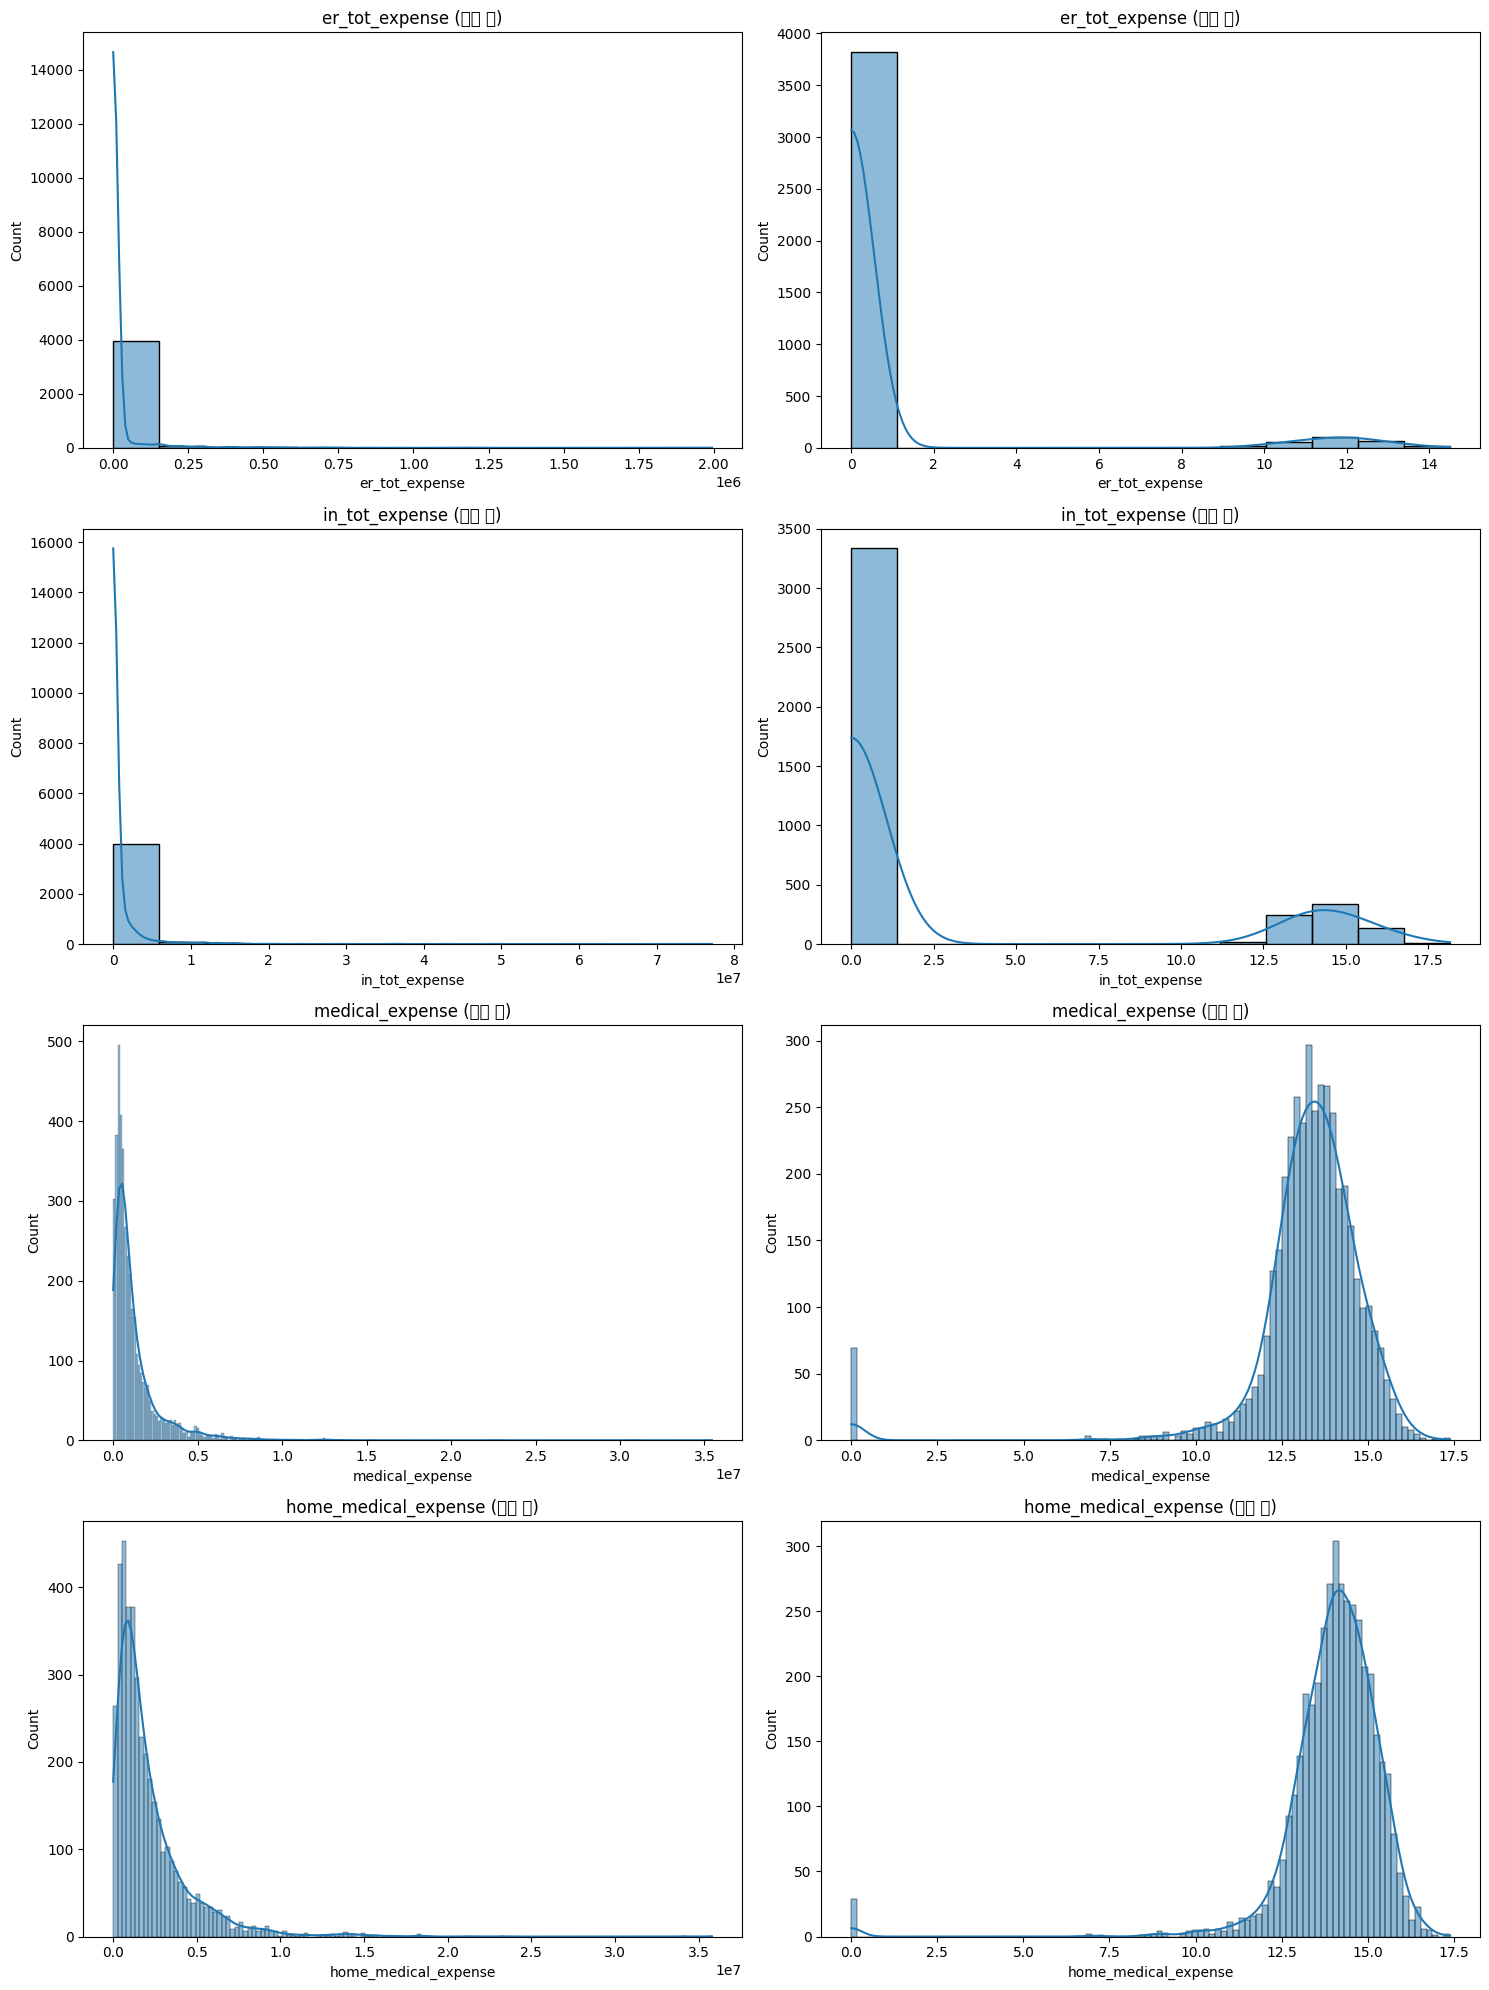

HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0       10006  1000601                        4.0                         1.0   
1       10006  1000601                        5.0                         1.0   
2       10006  1000601                        6.0                         1.0   
3       10006  1000601                        7.0                         1.0   
5       10006  1000602                        2.0                         1.0   
...       ...      ...                        ...                         ...   
5118    33003  3300304                       10.0                         1.0   
5120    33006  3300603                       13.0                         1.0   
5121    33006  3300603                       14.0                         1.0   
5122    33006  3300603                       15.0                         1.0   
5123    33006  3300603                       16.0                         1.0   

      followed_prescription  had_medication_side_effects  education_level  \
0                       0.0                          0.0              4.0   
1                       1.0                          0.0              4.0   
2                       1.0                          0.0              4.0   
3                       1.0                          0.0              4.0   
5                       0.0                          0.0              1.0   
...                     ...                          ...              ...   
5118                    1.0                          0.0              1.0   
5120                    1.0                          0.0              1.0   
5121                    1.0                          0.0              0.0   
5122                    1.0                          0.0              0.0   
5123                    1.0                          0.0              0.0   

       age  num_years_since_med_pension  has_disability  ...  \
0     60.0                          1.0             0.0  ...   
1     61.0                          1.0             0.0  ...   
2     62.0                          1.0             0.0  ...   
3     63.0                          1.0             0.0  ...   
5     59.0                          1.0             0.0  ...   
...    ...                          ...             ...  ...   
5118  68.0                          1.0             0.0  ...   
5120  69.0                          1.0             0.0  ...   
5121  70.0                          1.0             0.0  ...   
5122  71.0                          1.0             0.0  ...   
5123  72.0                          1.0             0.0  ...   

      was_bed_confined  num_bed_confined_days  bmi  is_overweight  in_num  \
0                    0                      0   28              1       0   
1                    0                      0   29              1       0   
2                    0                      0   27              1       0   
3                    0                      0   28              1       0   
5                    0                      0   24              1       0   
...                ...                    ...  ...            ...     ...   
5118                 0                      0   25              1       1   
5120                 0                      0   19              0       0   
5121                 0                      0   22              0       1   
5122                 0                      0   21              0       1   
5123                 0                      0   22              0       0   

      in_num_days  in_is_public  in_tot_expense  medical_expense  YEAR  
0               0             0             0.0        12.448042  2014  
1               0             0             0.0        12.950628  2015  
2               0             0             0.0        15.580536  2016  
3               0             0             0.0        13.413840  2017  
5               0            -1             0.0  

In [134]:
numeric_continuous_cols = list(set(numeric_continuous_cols) - set(multicolinear_cols))

train = log_transformation(train, numeric_continuous_cols, method='log1p')
train

=== 변환 전 통계량 ===
       er_tot_expense  in_tot_expense  medical_expense  home_medical_expense
count          1022.0          1022.0     1.022000e+03          1.022000e+03
mean     20489.262231  1044112.389432     1.462572e+06          2.489761e+06
std      95266.200016  3764896.927932     1.786851e+06          2.490879e+06
min               0.0             0.0     0.000000e+00          0.000000e+00
25%               0.0             0.0     4.428950e+05          8.451725e+05
50%               0.0             0.0     8.690580e+05          1.707028e+06
75%               0.0             0.0     1.727407e+06          3.330122e+06
max         1182426.0      50251782.0     1.578455e+07          1.608937e+07

er_tot_expense 변환: log1p(x)

in_tot_expense 변환: log1p(x)

medical_expense 변환: log1p(x)

home_medical_expense 변환: log1p(x)

=== 변환 후 통계량 ===
       er_tot_expense  in_tot_expense  medical_expense  home_medical_expense
count          1022.0          1022.0      1022.000000           1022.00

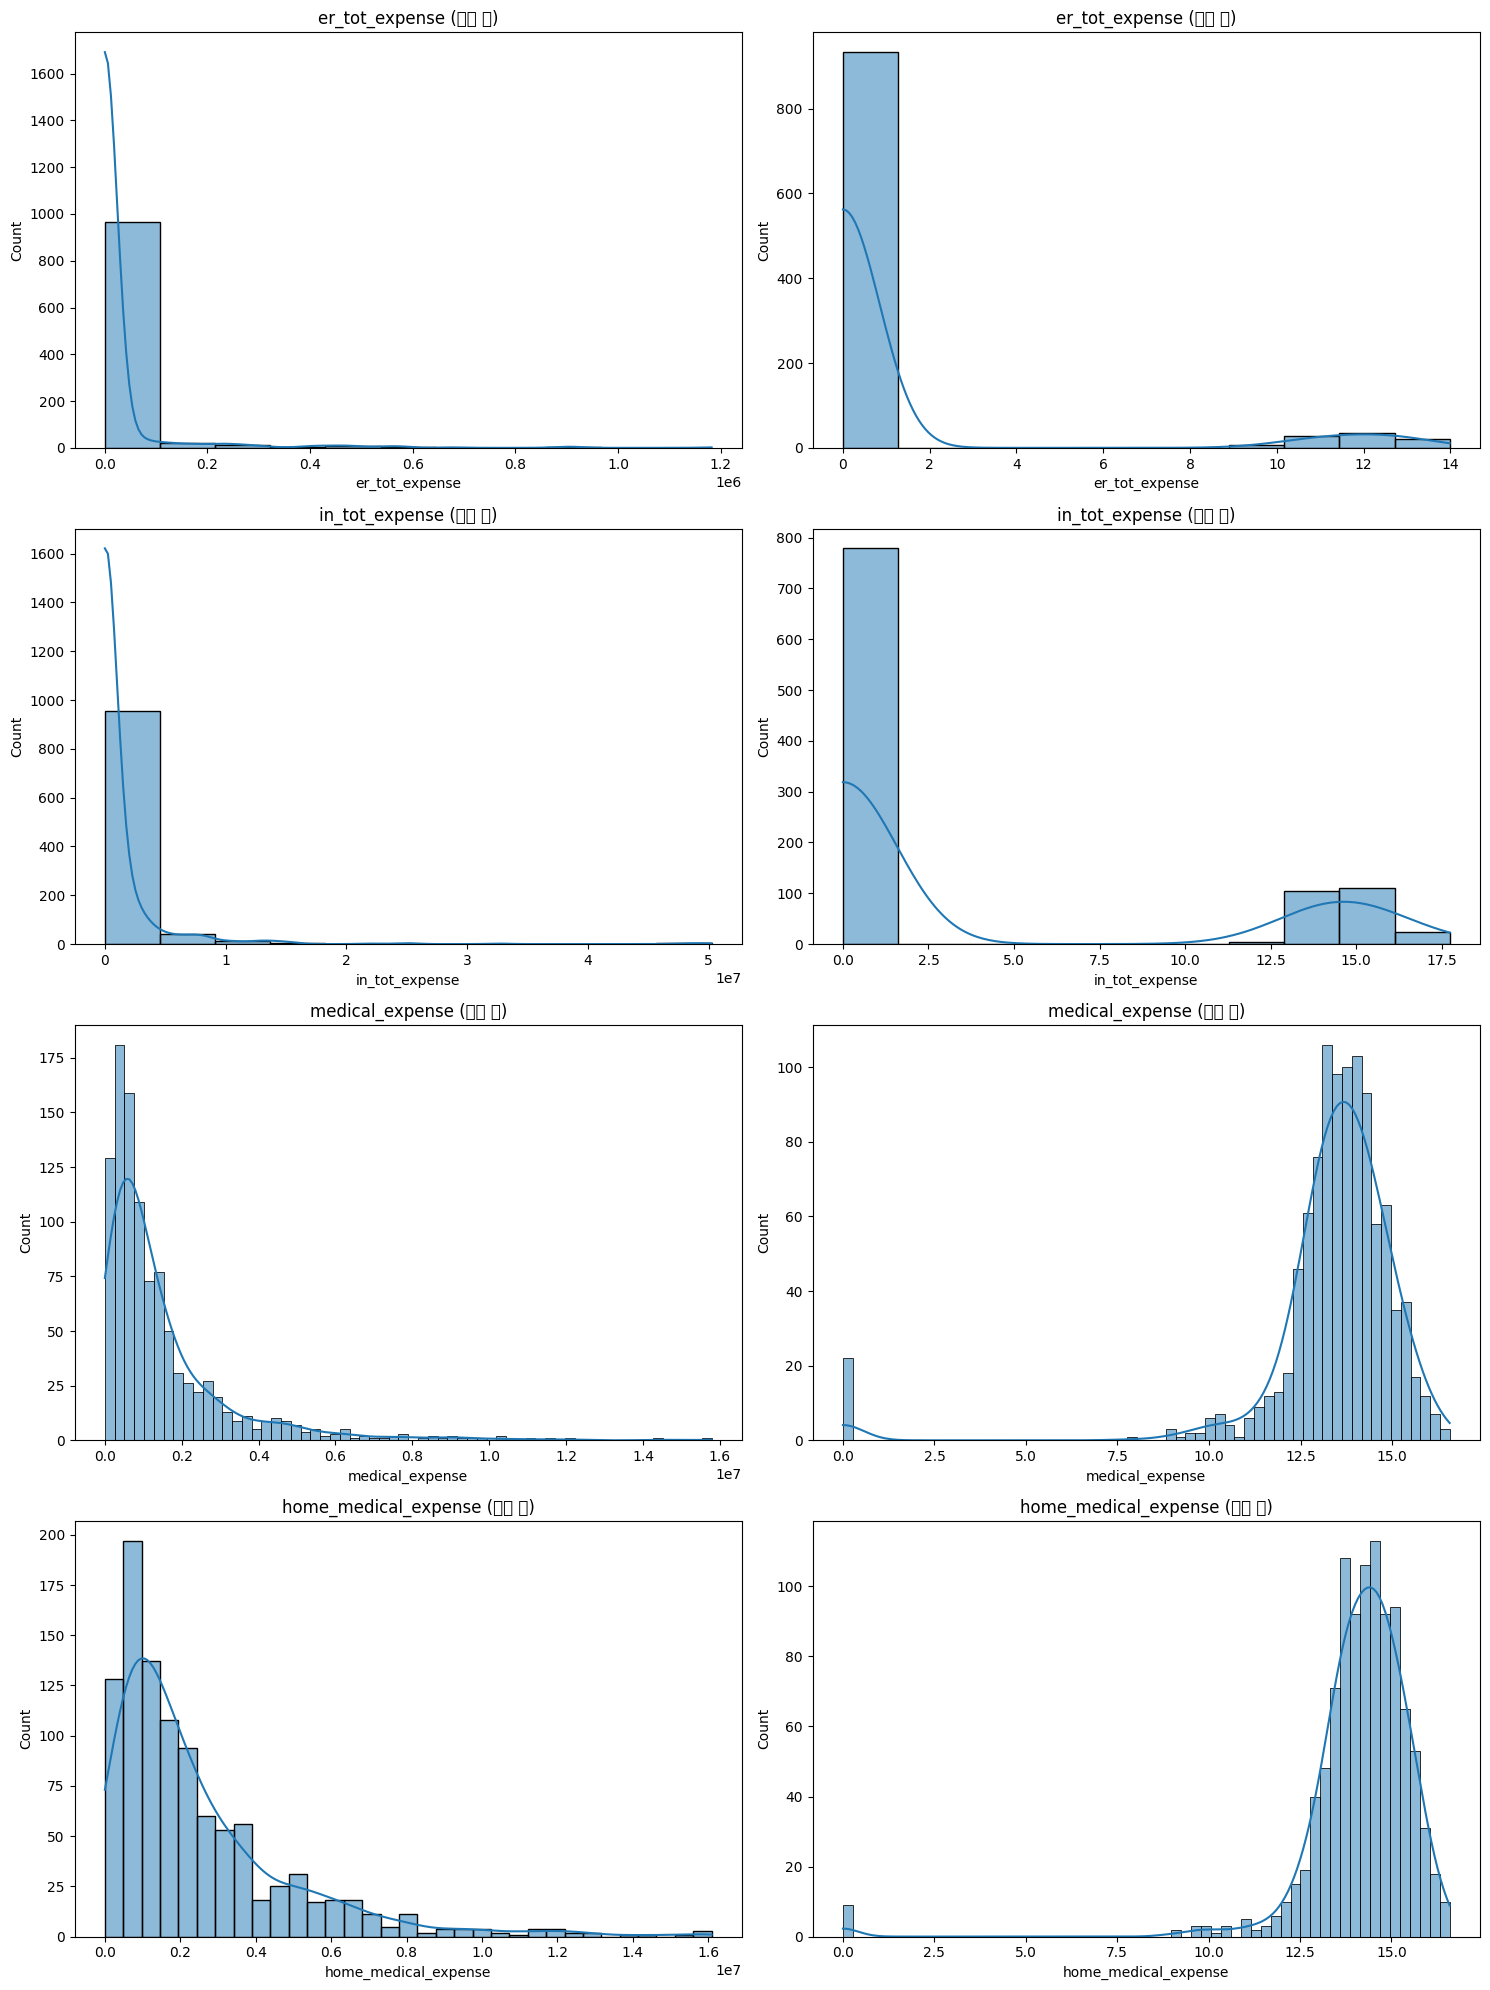

HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
4       10006  1000601                        8.0                         1.0   
9       10006  1000602                        6.0                         1.0   
14      10033  1003301                        7.0                         1.0   
19      10033  1003302                       16.0                         1.0   
24      10036  1003602                       12.0                         1.0   
...       ...      ...                        ...                         ...   
5104    32512  3251201                        7.0                         1.0   
5109    32516  3251601                        8.0                         1.0   
5114    32517  3251706                       19.0                         1.0   
5119    33003  3300304                       11.0                         1.0   
5124    33006  3300603                       17.0                         1.0   

      followed_prescription  had_medication_side_effects  education_level  \
4                       1.0                          0.0              4.0   
9                       1.0                          0.0              1.0   
14                      1.0                          0.0              3.0   
19                      1.0                          0.0              3.0   
24                      1.0                          0.0              3.0   
...                     ...                          ...              ...   
5104                    1.0                          0.0              1.0   
5109                    0.0                          0.0              4.0   
5114                    1.0                          0.0              0.0   
5119                    1.0                          0.0              1.0   
5124                    1.0                          0.0              0.0   

       age  num_years_since_med_pension  has_disability  ...  \
4     64.0                          1.0             0.0  ...   
9     63.0                          1.0             0.0  ...   
14    58.0                          1.0             0.0  ...   
19    52.0                          1.0             0.0  ...   
24    44.0                          1.0             0.0  ...   
...    ...                          ...             ...  ...   
5104  67.0                          1.0             0.0  ...   
5109  71.0                          1.0             0.0  ...   
5114  87.0                          1.0             0.0  ...   
5119  69.0                          1.0             0.0  ...   
5124  73.0                          1.0             0.0  ...   

      was_bed_confined  num_bed_confined_days  bmi  is_overweight  in_num  \
4                    0                      0   25              1       1   
9                    0                      0   25              1       0   
14                   0                      0   24              1       0   
19                   0                      0   29              1       0   
24                   0                      0   21              0       0   
...                ...                    ...  ...            ...     ...   
5104                 0                      0   26              1       0   
5109                 0                      0   22              0       0   
5114                 0                      0   20              0       4   
5119                 0                      0   24              1       0   
5124                 0                      0   27              1       0   

      in_num_days  in_is_public  in_tot_expense  medical_expense  YEAR  
4               6             0       15.282039        14.519573  2018  
9               0            -1             0.0        13.698877  2018  
14              0            -1             0.0        13.930981  2018  
19              0             1             0.0        13.831469  2018  
24              0             0             0.0  

In [135]:
test = log_transformation(test, numeric_continuous_cols, method='log1p')
test

# 4. 모델링

## 4.2. Outlier Detection and Removal on Train Data

In [136]:
# train, removed_count, removed_ratio = remove_outliers_iqr(train, column='medical_expense')
# # train, replaced_count, replaced_ratio = winsorize_data(train, 'medical_expense', 5, 95)

# # 이상치 제거 전후 통계량 비교
# print("\n이상치 제거 전후 통계량 비교:")
# print("\n원본 데이터 통계량:")
# print(train['medical_expense'].describe())
# print("\n이상치 제거 후 통계량:")
# print(train['medical_expense'].describe())

## 4.3. Feature Selection: LASSO

In [137]:
X_train, X_test, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = False)

Train data shape: (4088, 44)
Test data shape: (1022, 44)


LASSO Feature Selection Results:

Top 10 most important features:
                        Feature  Coefficient  Abs_Coefficient
13         home_medical_expense     0.827749         0.827749
20          ou_reason_aesthetic     0.511217         0.511217
21        ou_treatment_type_etc     0.472411         0.472411
2         followed_prescription     0.392437         0.392437
1    visited_facility_this_year     0.204801         0.204801
12        num_household_members    -0.197111         0.197111
32            subjective_health     0.169953         0.169953
9                       married    -0.144792         0.144792
6   num_years_since_med_pension    -0.132626         0.132626
29                     mobility     0.055774         0.055774


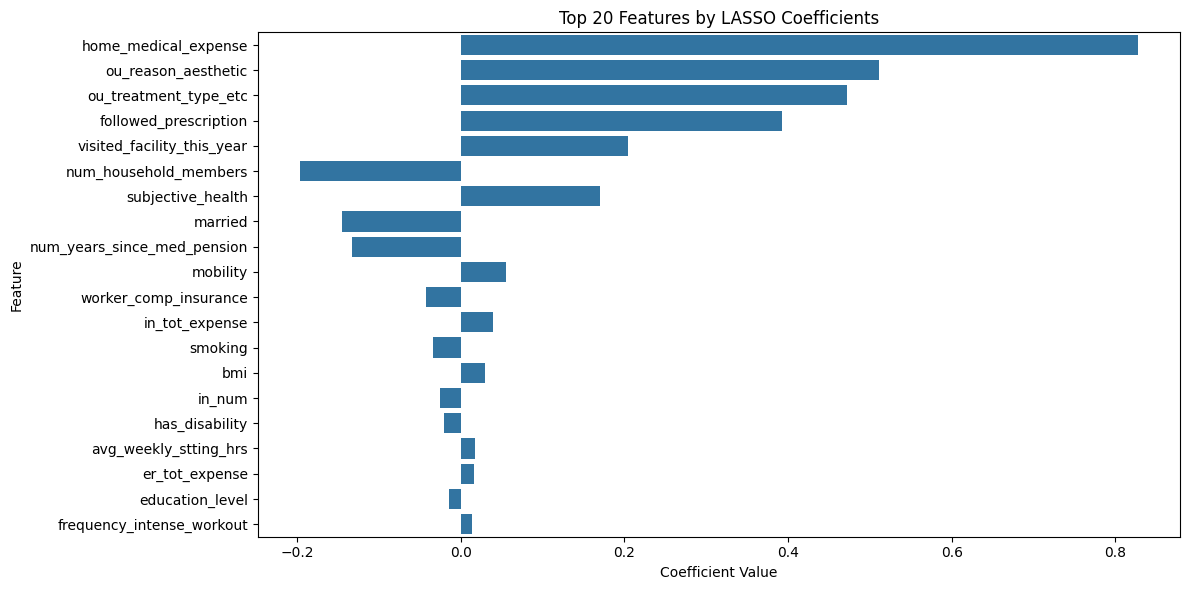


Features removed by LASSO (coefficient = 0):
Number of removed features: 9
['had_medication_side_effects', 'was_bed_confined', 'ou_treatment_type_surgery', 'ou_expense_self_paid', 'is_overweight', 'ou_is_public', 'er_days', 'in_is_public', 'pension_receipt_status_unknown']


num_years_since_diagnosis  visited_facility_this_year  \
0                        4.0                         1.0   
1                        5.0                         1.0   
2                        6.0                         1.0   
3                        7.0                         1.0   
4                        2.0                         1.0   

   followed_prescription  education_level   age  num_years_since_med_pension  \
0                    0.0              4.0  60.0                          1.0   
1                    1.0              4.0  61.0                          1.0   
2                    1.0              4.0  62.0                          1.0   
3                    1.0              4.0  63.0                          1.0   
4                    0.0              1.0  59.0                          1.0   

   has_disability  worker_comp_insurance  married  is_above_45yrs  ...  \
0             0.0                    2.0      1.0             1.0  ...   
1             0.0                    2.0      1.0             1.0  ...   
2             0.0                    2.0      1.0             1.0  ...   
3             0.0                    2.0      1.0             1.0  ...   
4             0.0                    2.0      1.0             1.0  ...   

   avg_weekly_stting_hrs  mobility  physical_pain  depression  \
0                     17         0              0           0   
1                     10         2              1           0   
2                     12         2              0           0   
3                      9         2              0           0   
4                      5         0              0           0   

   subjective_health  num_bed_confined_days  bmi  in_num  in_num_days  \
0                  4                      0   28       0            0   
1                  4                      0   29       0            0   
2                  2                      0   27       0            0   
3                  3                      0   28       0            0   
4                  4                      0   24       0            0   

   in_tot_expense  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 32 columns]

In [138]:
zero_features = apply_lasso_feature_selection(X_train, y_train, alpha= 0.01)

X_train = X_train.drop(zero_features, axis=1)
X_test = X_test.drop(zero_features, axis=1)
X_train.head()

In [139]:
# X_train.columns

## 4.3. Baseline Models

### 4.3.0. Linear Regression


In [140]:
# Linear Regression 모델 초기화
lr = LinearRegression()

# 모델 학습
lr.fit(X_train, y_train)

LinearRegression()

### 4.3.1. Linear Model via Hausman Test

- $H_0$ = 변동효과 모형 선정
- $H_\alpha$ = 고정효과 모형 선정

In [141]:
# 1. MultiIndex 설정
train_indexed = train.set_index(['PIDWON', 'YEAR']).drop(columns=['HHIDWON'])
test_indexed = test.set_index(['PIDWON', 'YEAR']).drop(columns=['HHIDWON'])

# 2. X와 y 분리
X_train_indexed = train_indexed.drop('medical_expense', axis=1)
y_train_indexed = train_indexed['medical_expense']
X_test_indexed = test_indexed.drop('medical_expense', axis=1)
y_test_indexed = test_indexed['medical_expense']

X_train_indexed.head()


num_years_since_diagnosis  visited_facility_this_year  \
PIDWON  YEAR                                                          
1000601 2014                        4.0                         1.0   
        2015                        5.0                         1.0   
        2016                        6.0                         1.0   
        2017                        7.0                         1.0   
1000602 2014                        2.0                         1.0   

              followed_prescription  had_medication_side_effects  \
PIDWON  YEAR                                                       
1000601 2014                    0.0                          0.0   
        2015                    1.0                          0.0   
        2016                    1.0                          0.0   
        2017                    1.0                          0.0   
1000602 2014                    0.0                          0.0   

              education_level   age  num_years_since_med_pension  \
PIDWON  YEAR                                                       
1000601 2014              4.0  60.0                          1.0   
        2015              4.0  61.0                          1.0   
        2016              4.0  62.0                          1.0   
        2017              4.0  63.0                          1.0   
1000602 2014              1.0  59.0                          1.0   

              has_disability  worker_comp_insurance  married  ...  depression  \
PIDWON  YEAR                                                  ...               
1000601 2014             0.0                    2.0      1.0  ...           0   
        2015             0.0                    2.0      1.0  ...           0   
        2016             0.0                    2.0      1.0  ...           0   
        2017             0.0                    2.0      1.0  ...           0   
1000602 2014             0.0                    2.0      1.0  ...           0   

              subjective_health  was_bed_confined  num_bed_confined_days  bmi  \
PIDWON  YEAR                                                                    
1000601 2014                  4                 0                      0   28   
        2015                  4                 0                      0   29   
        2016                  2                 0                      0   27   
        2017                  3                 0                      0   28   
1000602 2014                  4                 0                      0   24   

              is_overweight  in_num  in_num_days  in_is_public  in_tot_expense  
PIDWON  YEAR                                                                    
1000601 2014              1       0            0             0             0.0  
        2015              1       0            0             0             0.0  
        2016              1       0            0             0             0.0  
        2017              1       0            0             0             0.0  
1000602 2014              1       0            0            -1             0.0  

[5 rows x 41 columns]

In [142]:
# 1. 모든 수치형으로 강제 변환
X_train_indexed = X_train_indexed.astype(float)
X_test_indexed = X_test_indexed.astype(float)

# 2. 상수값 컬럼 제거
cols_to_drop = X_train_indexed.columns[X_train_indexed.nunique() <= 1]
X_train_indexed = X_train_indexed.drop(columns=cols_to_drop)
X_test_indexed = X_test_indexed.drop(columns=cols_to_drop)

# 3. 더미 변수 trap 회피용 첫 dummy 제거
X_train_indexed = pd.get_dummies(X_train_indexed, drop_first=True)
X_test_indexed = pd.get_dummies(X_test_indexed, drop_first=True)


In [143]:
# 4. 다시 고정효과 모형 적합
fe_model = PanelOLS(y_train_indexed, X_train_indexed, entity_effects=True,
                    check_rank=False, drop_absorbed=True)
fe_results = fe_model.fit()
print(fe_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:        medical_expense   R-squared:                        0.6042
Estimator:                   PanelOLS   R-squared (Between):              0.3882
No. Observations:                4088   R-squared (Within):               0.6042
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.4758
Time:                        14:06:42   Log-likelihood                   -5051.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      118.47
Entities:                        1022   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                 F(39,3027)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):          1.976e+04
                            

In [144]:
# # 3. 변동 효과 모형 적합
# 무작위 효과 모델 적합
# 불필요한 인자 제거
re_model = RandomEffects(y_train_indexed, X_train_indexed, check_rank=False)

# 모델 학습
re_results = re_model.fit()

# 결과 출력
print(re_results.summary)


                        RandomEffects Estimation Summary                        
Dep. Variable:        medical_expense   R-squared:                        0.5984
Estimator:              RandomEffects   R-squared (Between):              0.6199
No. Observations:                4088   R-squared (Within):               0.5900
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.6078
Time:                        14:06:42   Log-likelihood                   -5758.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      154.69
Entities:                        1022   P-value                           0.0000
Avg Obs:                       4.0000   Distribution:                 F(39,4048)
Min Obs:                       4.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             5132.8
                            

In [145]:
from scipy import stats
import numpy as np

# 1. 공통 파라미터만 비교
common_params = fe_results.params.index.intersection(re_results.params.index)

# 2. 차이 및 공분산 계산
coef_diff = fe_results.params[common_params] - re_results.params[common_params]
cov_diff = fe_results.cov.loc[common_params, common_params] - re_results.cov.loc[common_params, common_params]

# 3. 통계량 계산
hausman_stat = coef_diff.T @ np.linalg.pinv(cov_diff) @ coef_diff
df = len(coef_diff)
hausman_pval = 1 - stats.chi2.cdf(hausman_stat, df)

# 4. 출력
print(f"\nHausman 검정 결과:")
print(f"통계량: {hausman_stat:.4f}")
print(f"p-value: {hausman_pval:.4f}")

if hausman_pval < 0.05:
    print("\n❗ 고정효과 모형을 선택해야 합니다 (p-value < 0.05)")
else:
    print("\n✅ 무작위효과 모형을 선택할 수 있습니다 (p-value >= 0.05)")


Hausman 검정 결과:
통계량: 321.8764
p-value: 0.0000

❗ 고정효과 모형을 선택해야 합니다 (p-value < 0.05)


### 4.3.2 Boosting

In [146]:
xgb = XGBRegressor(
        n_estimators=100,  # 트리 개수 (예시)
        learning_rate=0.1,
        random_state=42    # 재현성
    )
xgb.fit(X_train, y_train)

# LightGBM
lgb = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
lgb.fit(X_train, y_train)

# CatBoost
cat = CatBoostRegressor(
    iterations=100,
    learning_rate=0.1,
    random_state=42,
    verbose=False  # 학습 진행 상황 출력 끄기
)
cat.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1092
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 30
[LightGBM] [Info] Start training from score 13.245536


### 4.3.3 Bagging (Random Forest)

In [147]:
# Random Forest 모델 학습
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# 5. 성능 평가

In [148]:
log_tansformed = True

models = [fe_results, lr, xgb, lgb, cat, rf]
fe_pred, lr_pred, xgb_pred, lgb_pred, cat_pred, rf_pred = predict_model(X_test_indexed, X_test, models, log_transformed = log_tansformed)

y_test = transform_y(y_test, log_transformed = log_tansformed)
y_test_indexed = transform_y(y_test_indexed, log_transformed = log_tansformed)

In [149]:
# 각 모델의 성능 평가
fe_metrics = evaluate_model(y_test_indexed.squeeze(), fe_pred, "Fixed Effects", X_test_indexed)
lr_metrics = evaluate_model(y_test, lr_pred, "Linear Regression", X_test)
xgb_metrics = evaluate_model(y_test, xgb_pred, "XGBoost", X_test)
lgb_metrics = evaluate_model(y_test, lgb_pred, "LightGBM", X_test)
cat_metrics = evaluate_model(y_test, cat_pred, "CatBoost", X_test)
rf_metrics = evaluate_model(y_test, rf_pred, "Random Forest", X_test)


Fixed Effects 모델 성능 평가:
RMSE: 2,377,280.8
MAE: 925,776.3
MAPE: 460263.82%
Adjusted R2 Score: -0.844

Linear Regression 모델 성능 평가:
RMSE: 12,720,848.3
MAE: 1,436,814.5
MAPE: 132628.67%
Adjusted R2 Score: -51.373

XGBoost 모델 성능 평가:
RMSE: 1,026,956.6
MAE: 476,322.5
MAPE: 813.25%
Adjusted R2 Score: 0.659

LightGBM 모델 성능 평가:
RMSE: 1,031,958.8
MAE: 485,207.2
MAPE: 307.67%
Adjusted R2 Score: 0.655

CatBoost 모델 성능 평가:
RMSE: 1,102,692.4
MAE: 546,203.3
MAPE: 578.86%
Adjusted R2 Score: 0.606

Random Forest 모델 성능 평가:
RMSE: 911,110.5
MAE: 463,532.9
MAPE: 92.81%
Adjusted R2 Score: 0.731


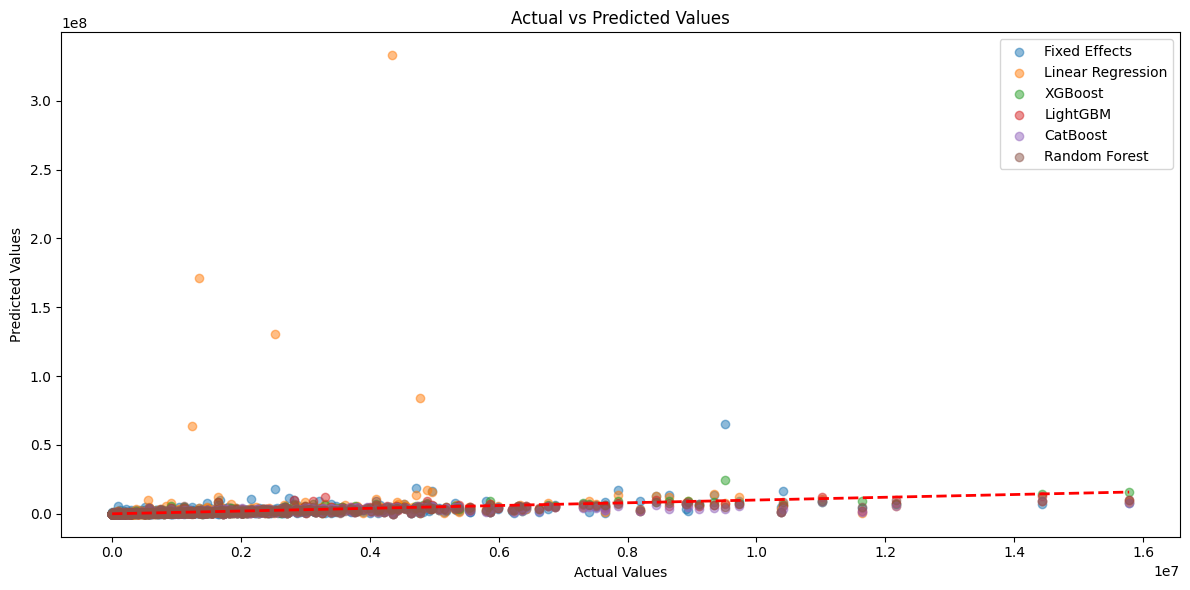

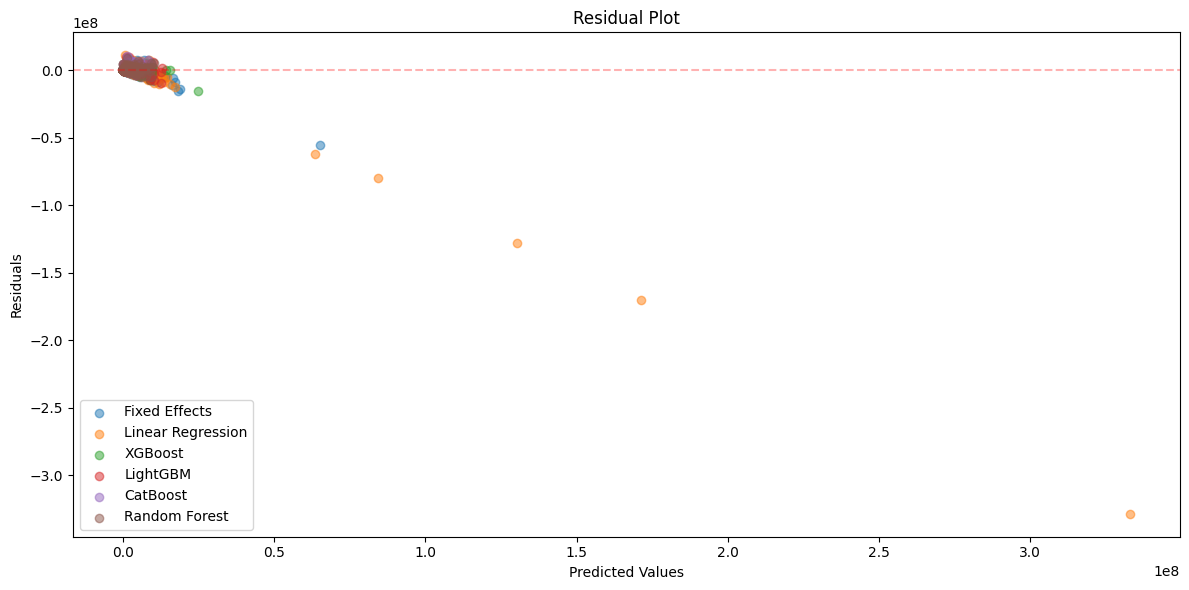

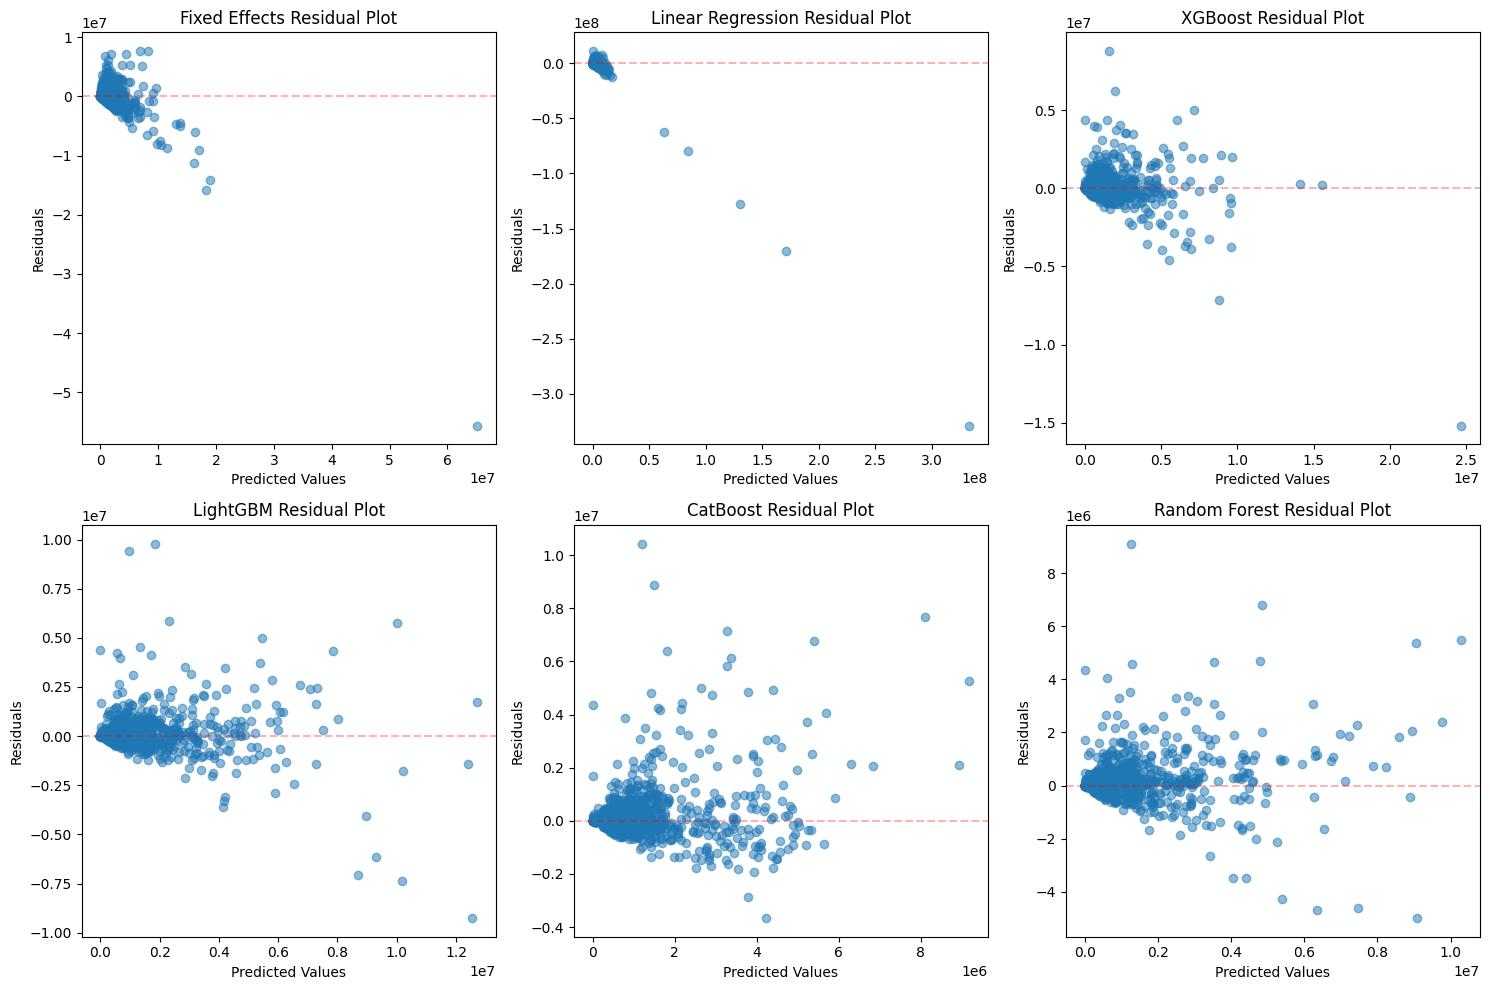

In [150]:
# 결과 비교를 위한 시각화
metrics_df = pd.DataFrame({
    'Model': ['Fixed Effects','Linear Regression','XGBoost', 'LightGBM', 'CatBoost', 'Random Forest'],
    'RMSE': [fe_metrics[1], lr_metrics[1], xgb_metrics[1], lgb_metrics[1], cat_metrics[1], rf_metrics[1]],
    'MAE': [fe_metrics[2], lr_metrics[2], xgb_metrics[2], lgb_metrics[2], cat_metrics[2], rf_metrics[2]],
    # 'MAPE': [fe_metrics[3], lr_metrics[3], xgb_metrics[3], lgb_metrics[3], cat_metrics[3], rf_metrics[3]],
    'Adjusted R2': [fe_metrics[5], lr_metrics[5], xgb_metrics[5], lgb_metrics[5], cat_metrics[5], rf_metrics[5]]
})

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test_indexed, fe_pred, alpha=0.5, label='Fixed Effects')
plt.scatter(y_test, lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(y_test, lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(y_test, cat_pred, alpha=0.5, label='CatBoost')
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest')
# plt.scatter(y_test, tabnet_pred, alpha=0.5, label='TabNet')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.savefig(f'plots/result_plot_actual_vs_predicted_v1.png')
plt.show()

# Residual plot 추가
plt.figure(figsize=(12, 6))
plt.scatter(fe_pred, y_test_indexed - fe_pred, alpha=0.5, label='Fixed Effects')
plt.scatter(lr_pred, y_test - lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(xgb_pred, y_test - xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(lgb_pred, y_test - lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(cat_pred, y_test - cat_pred, alpha=0.5, label='CatBoost')
plt.scatter(rf_pred, y_test - rf_pred, alpha=0.5, label='Random Forest')

# y=0 기준선 추가
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.savefig(f'plots/result_plot_residual_v1.png')
plt.show()

# 각 모델별 개별 residual plot
models = {
    'Fixed Effects': (fe_pred, y_test_indexed.squeeze()),
    'Linear Regression': (lr_pred, y_test),
    'XGBoost': (xgb_pred, y_test),
    'LightGBM': (lgb_pred, y_test),
    'CatBoost': (cat_pred, y_test),
    'Random Forest': (rf_pred, y_test)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, (pred, true)) in enumerate(models.items()):
    residuals = true - pred
    axes[idx].scatter(pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{model_name} Residual Plot')

plt.tight_layout()
plt.savefig(f'plots/result_plot_residual_by_model_v1.png')
plt.show()

In [151]:
# feature_importance_df = analyze_feature_importance(rf, X_train.columns)
# feature_importance_df

# 6. 성능 개선

## 6.1. Feature Engineering

In [152]:
df_lag = pd.concat([train, test], axis = 0).sort_values(['PIDWON', 'YEAR'])

# 여러 time-based features 생성
target_columns = ['medical_expense', 'home_medical_expense', 'in_tot_expense']

# Lag features
df_lag = create_lag_columns(df_lag, target_columns)

# Rolling features
df_lag = create_rolling_features(df_lag, target_columns)

# Cumulative features
# df_lag = create_cumulative_features(df_lag, target_columns)

# Year-over-Year features
# df_lag = create_yoy_features(df_lag, target_columns)

# Time-based aggregations
# df_lag = move_y_column(create_time_aggregations(df_lag, target_columns))

df_lag

HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0       10006  1000601                        4.0                         1.0   
1       10006  1000601                        5.0                         1.0   
2       10006  1000601                        6.0                         1.0   
3       10006  1000601                        7.0                         1.0   
4       10006  1000601                        8.0                         1.0   
...       ...      ...                        ...                         ...   
5120    33006  3300603                       13.0                         1.0   
5121    33006  3300603                       14.0                         1.0   
5122    33006  3300603                       15.0                         1.0   
5123    33006  3300603                       16.0                         1.0   
5124    33006  3300603                       17.0                         1.0   

      followed_prescription  had_medication_side_effects  education_level  \
0                       0.0                          0.0              4.0   
1                       1.0                          0.0              4.0   
2                       1.0                          0.0              4.0   
3                       1.0                          0.0              4.0   
4                       1.0                          0.0              4.0   
...                     ...                          ...              ...   
5120                    1.0                          0.0              1.0   
5121                    1.0                          0.0              0.0   
5122                    1.0                          0.0              0.0   
5123                    1.0                          0.0              0.0   
5124                    1.0                          0.0              0.0   

       age  num_years_since_med_pension  has_disability  ...  \
0     60.0                          1.0             0.0  ...   
1     61.0                          1.0             0.0  ...   
2     62.0                          1.0             0.0  ...   
3     63.0                          1.0             0.0  ...   
4     64.0                          1.0             0.0  ...   
...    ...                          ...             ...  ...   
5120  69.0                          1.0             0.0  ...   
5121  70.0                          1.0             0.0  ...   
5122  71.0                          1.0             0.0  ...   
5123  72.0                          1.0             0.0  ...   
5124  73.0                          1.0             0.0  ...   

      home_medical_expense_rolling_max_3  home_medical_expense_rolling_min_3  \
0                              14.532355                           14.532355   
1                              15.213508                           14.532355   
2                              15.724585                           14.532355   
3                              15.724585                           13.806673   
4                              15.724585                           13.806673   
...                                  ...                                 ...   
5120                           13.924034                           13.924034   
5121                           14.153277                           13.924034   
5122                           14.736784                           13.924034   
5123                           15.035688                           14.153277   
5124                           15.035688                           14.736784   

      in_tot_expense_rolling_mean_2  in_tot_expense_rolling_std_2  \
0                          0.000000                           NaN   
1                          0.000000                      0.000000   
2                          0.000000                      0.000000   
3                          0.000000                      0.000000   
4                          7.6410

In [153]:
train, test = train_test_split_by_year(df_lag)
X_train, X_test, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = False)
X_train_indexed, X_test_indexed, y_train, y_test = X_y_split_by_year(train, test, 'medical_expense', is_panel = True)
X_train_indexed.head()

Train data years: [2014 2015 2016 2017]
Test data years: [2018]
Train data shape: (4088, 80)
Test data shape: (1022, 80)
Train data shape: (4088, 80)
Test data shape: (1022, 80)


HHIDWON   PIDWON  num_years_since_diagnosis  visited_facility_this_year  \
0    10006  1000601                        4.0                         1.0   
1    10006  1000601                        5.0                         1.0   
2    10006  1000601                        6.0                         1.0   
3    10006  1000601                        7.0                         1.0   
4    10006  1000602                        2.0                         1.0   

   followed_prescription  had_medication_side_effects  education_level   age  \
0                    0.0                          0.0              4.0  60.0   
1                    1.0                          0.0              4.0  61.0   
2                    1.0                          0.0              4.0  62.0   
3                    1.0                          0.0              4.0  63.0   
4                    0.0                          0.0              1.0  59.0   

   num_years_since_med_pension  has_disability  ...  \
0                          1.0             0.0  ...   
1                          1.0             0.0  ...   
2                          1.0             0.0  ...   
3                          1.0             0.0  ...   
4                          1.0             0.0  ...   

   home_medical_expense_rolling_min_3  in_tot_expense_rolling_mean_2  \
0                           14.532355                            0.0   
1                           14.532355                            0.0   
2                           14.532355                            0.0   
3                           13.806673                            0.0   
4                           14.532355                            0.0   

   in_tot_expense_rolling_std_2  in_tot_expense_rolling_max_2  \
0                           NaN                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           NaN                           0.0   

   in_tot_expense_rolling_min_2  in_tot_expense_rolling_mean_3  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2                           0.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            0.0   

   in_tot_expense_rolling_std_3  in_tot_expense_rolling_max_3  \
0                           NaN                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           NaN                           0.0   

   in_tot_expense_rolling_min_3  YEAR  
0                           0.0  2014  
1                           0.0  2015  
2                           0.0  2016  
3                           0.0  2017  
4                           0.0  2014  

[5 rows x 80 columns]

In [154]:
X_train = handle_abnormal_values(X_train)
X_test = handle_abnormal_values(X_test)

X_train_indexed = handle_abnormal_values(X_train_indexed)
X_test_indexed = handle_abnormal_values(X_test_indexed)

X_train.head()

num_years_since_diagnosis  visited_facility_this_year  \
0                        4.0                         1.0   
1                        5.0                         1.0   
2                        6.0                         1.0   
3                        7.0                         1.0   
4                        2.0                         1.0   

   followed_prescription  had_medication_side_effects  education_level   age  \
0                    0.0                          0.0              4.0  60.0   
1                    1.0                          0.0              4.0  61.0   
2                    1.0                          0.0              4.0  62.0   
3                    1.0                          0.0              4.0  63.0   
4                    0.0                          0.0              1.0  59.0   

   num_years_since_med_pension  has_disability  worker_comp_insurance  \
0                          1.0             0.0                    2.0   
1                          1.0             0.0                    2.0   
2                          1.0             0.0                    2.0   
3                          1.0             0.0                    2.0   
4                          1.0             0.0                    2.0   

   married  ...  home_medical_expense_rolling_max_3  \
0      1.0  ...                           14.532355   
1      1.0  ...                           15.213508   
2      1.0  ...                           15.724585   
3      1.0  ...                           15.724585   
4      1.0  ...                           14.532355   

   home_medical_expense_rolling_min_3  in_tot_expense_rolling_mean_2  \
0                           14.532355                            0.0   
1                           14.532355                            0.0   
2                           14.532355                            0.0   
3                           13.806673                            0.0   
4                           14.532355                            0.0   

   in_tot_expense_rolling_std_2  in_tot_expense_rolling_max_2  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   in_tot_expense_rolling_min_2  in_tot_expense_rolling_mean_3  \
0                           0.0                            0.0   
1                           0.0                            0.0   
2                           0.0                            0.0   
3                           0.0                            0.0   
4                           0.0                            0.0   

   in_tot_expense_rolling_std_3  in_tot_expense_rolling_max_3  \
0                           0.0                           0.0   
1                           0.0                           0.0   
2                           0.0                           0.0   
3                           0.0                           0.0   
4                           0.0                           0.0   

   in_tot_expense_rolling_min_3  
0                           0.0  
1                           0.0  
2                           0.0  
3                           0.0  
4                           0.0  

[5 rows x 77 columns]

## 6.2. 성능 비교

In [155]:
# 각 모델의 성능 평가
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_metrics = evaluate_model(transform_y(y_test, log_transformed = True), np.exp(lr_pred), "Linear Regression", X_test)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_metrics = evaluate_model(transform_y(y_test, log_transformed = True), np.exp(rf_pred), "RandomForest", X_test)

xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_metrics = evaluate_model(transform_y(y_test, log_transformed = True), np.exp(xgb_pred), "XGBoost", X_test)

cat.fit(X_train, y_train)
cat_pred = cat.predict(X_test)
cat_metrics = evaluate_model(transform_y(y_test, log_transformed = True), np.exp(cat_pred), "CatBoost", X_test)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)
lgb_metrics = evaluate_model(transform_y(y_test, log_transformed = True), np.exp(lgb_pred), "LightGBM", X_test)


Linear Regression 모델 성능 평가:
RMSE: 358,902.4
MAE: 150,492.7
MAPE: 29.39%
Adjusted R2 Score: 0.956

RandomForest 모델 성능 평가:
RMSE: 207,407.6
MAE: 68,011.6
MAPE: 8.41%
Adjusted R2 Score: 0.985

XGBoost 모델 성능 평가:
RMSE: 403,786.3
MAE: 101,708.8
MAPE: 7.70%
Adjusted R2 Score: 0.945

CatBoost 모델 성능 평가:
RMSE: 556,089.3
MAE: 225,967.0
MAPE: 27.08%
Adjusted R2 Score: 0.895
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8815
[LightGBM] [Info] Number of data points in the train set: 4088, number of used features: 70
[LightGBM] [Info] Start training from score 13.245536

LightGBM 모델 성능 평가:
RMSE: 352,968.9
MAE: 102,546.2
MAPE: 9.11%
Adjusted R2 Score: 0.958


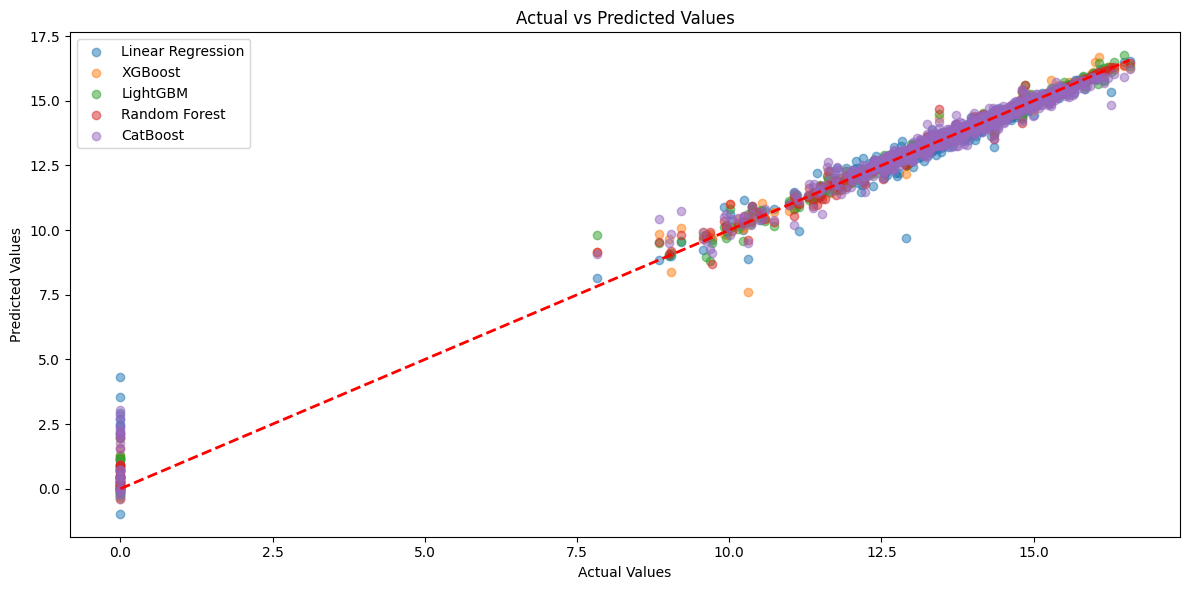

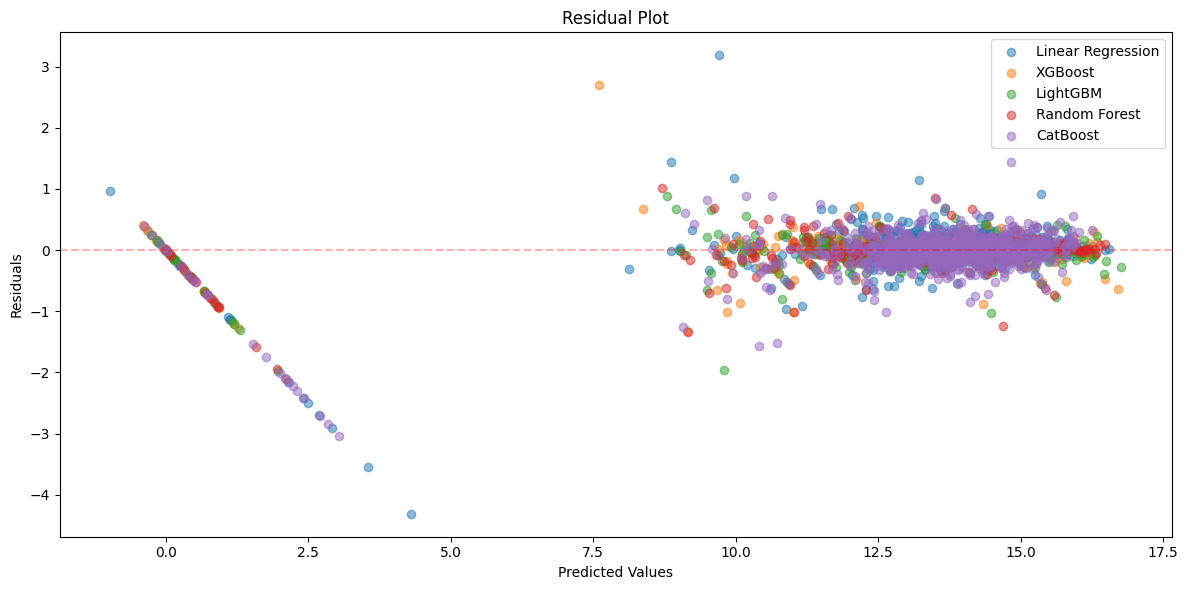

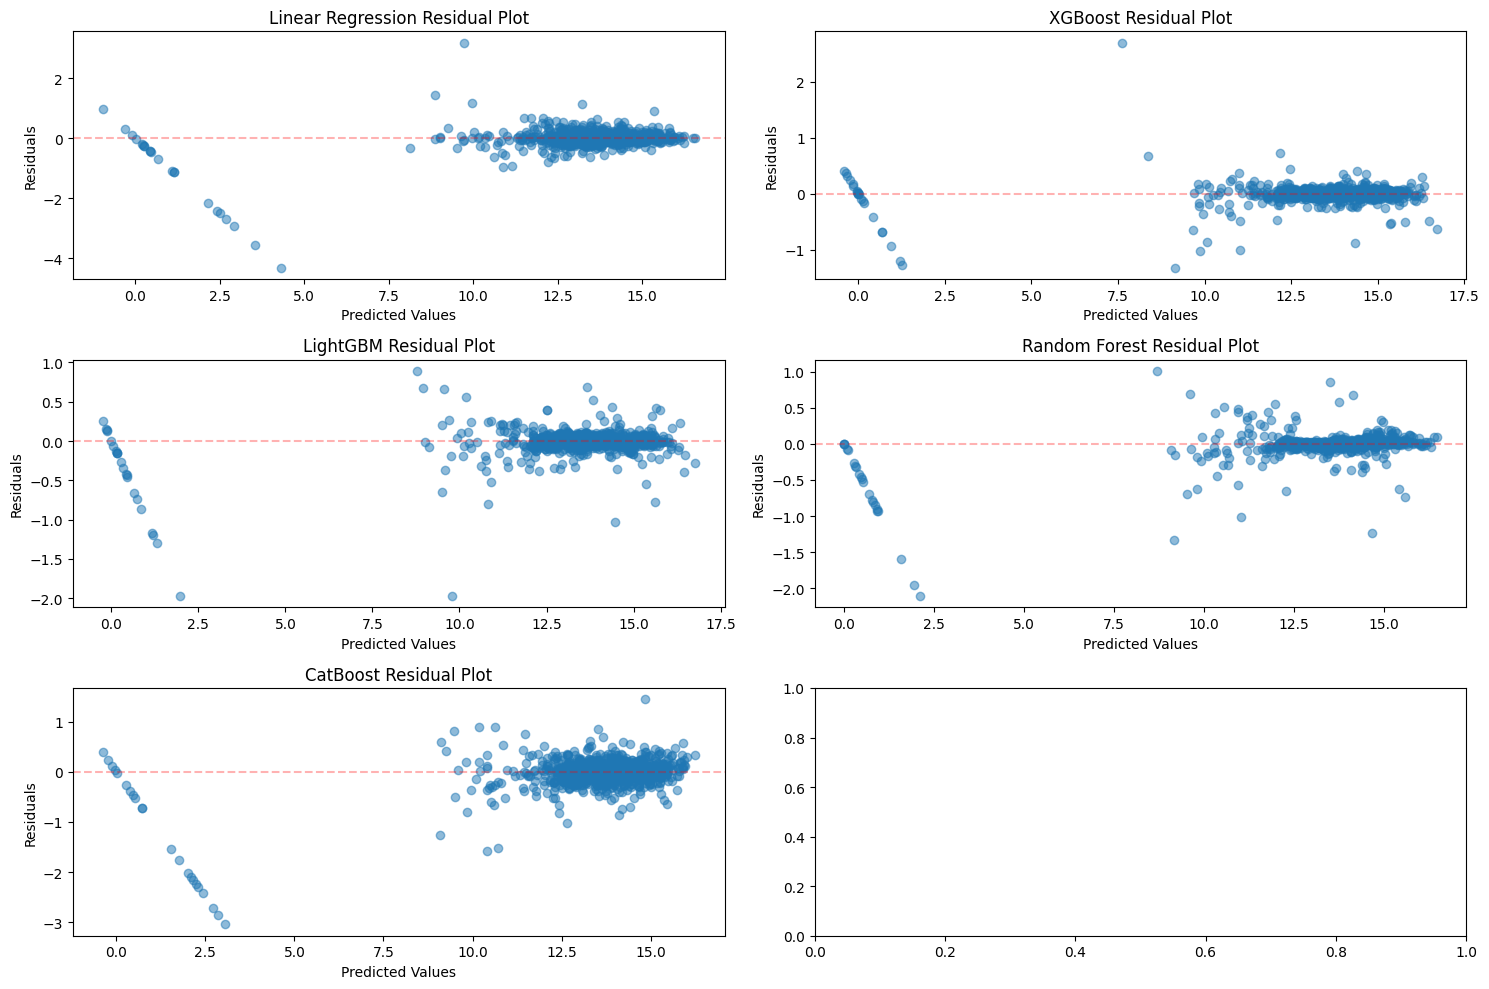

In [156]:
# 결과 비교를 위한 시각화
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression','XGBoost', 'LightGBM', 'Random Forest', 'CatBoost'],
    'RMSE': [lr_metrics[1], xgb_metrics[1], lgb_metrics[1], rf_metrics[1], cat_metrics[1]],
    'MAE': [lr_metrics[2], xgb_metrics[2], lgb_metrics[2], rf_metrics[2], cat_metrics[2]],
    'MAPE': [lr_metrics[3], xgb_metrics[3], lgb_metrics[3], rf_metrics[3], cat_metrics[3]],
    'Adjusted R2': [lr_metrics[5], xgb_metrics[5], lgb_metrics[5], rf_metrics[5], cat_metrics[5]]
})

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(y_test, lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(y_test, rf_pred, alpha=0.5, label='Random Forest')
plt.scatter(y_test, cat_pred, alpha=0.5, label='CatBoost')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

# Residual plot 추가
plt.figure(figsize=(12, 6))
plt.scatter(lr_pred, y_test - lr_pred, alpha=0.5, label='Linear Regression')
plt.scatter(xgb_pred, y_test - xgb_pred, alpha=0.5, label='XGBoost')
plt.scatter(lgb_pred, y_test - lgb_pred, alpha=0.5, label='LightGBM')
plt.scatter(rf_pred, y_test - rf_pred, alpha=0.5, label='Random Forest')
plt.scatter(cat_pred, y_test - cat_pred, alpha=0.5, label='CatBoost')

# y=0 기준선 추가
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)

plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.tight_layout()
plt.show()

# 각 모델별 개별 residual plot
models = {
    'Linear Regression': (lr_pred, y_test),
    'XGBoost': (xgb_pred, y_test),
    'LightGBM': (lgb_pred, y_test),
    'Random Forest': (rf_pred, y_test),
    'CatBoost': (cat_pred, y_test)
}

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, (pred, true)) in enumerate(models.items()):
    residuals = true - pred
    axes[idx].scatter(pred, residuals, alpha=0.5)
    axes[idx].axhline(y=0, color='r', linestyle='--', alpha=0.3)
    axes[idx].set_xlabel('Predicted Values')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{model_name} Residual Plot')

plt.tight_layout()
plt.show()

## 6.3. 예측 구간 (Prediction intervals) 비교

In [157]:
lr_pred, lr_lower, lr_upper = calculate_pi(lr, X_train, y_train, X_test)
rf_pred, rf_lower, rf_upper = calculate_pi(rf, X_train, y_train, X_test)
xgb_pred, xgb_lower, xgb_upper = calculate_pi(xgb, X_train, y_train, X_test)
lgb_pred, lgb_lower, lgb_upper = calculate_pi(lgb, X_train, y_train, X_test)
cat_pred, cat_lower, cat_upper = calculate_pi(cat, X_train, y_train, X_test)
# 모델 딕셔너리
model_dict = {'rf': rf, 'lgb': lgb, 'xgb': xgb, 'cat': cat}

# PI 계산
ensemble_point, ensemble_lower, ensemble_upper = calculate_ensemble_pi(model_dict, X_test)

# 로그변환된 경우 역변환
results = pd.DataFrame({
    'lr_prediction': np.exp(lr_pred),
    'lr_lower_pi': np.exp(lr_lower),
    'lr_upper_pi': np.exp(lr_upper),
    'rf_prediction': np.exp(rf_pred),
    'rf_lower_pi': np.exp(rf_lower),
    'rf_upper_pi': np.exp(rf_upper),
    'xgb_prediction': np.exp(xgb_pred),
    'xgb_lower_pi': np.exp(xgb_lower),
    'xgb_upper_pi': np.exp(xgb_upper),
    'lgb_prediction': np.exp(lgb_pred),
    'lgb_lower_pi': np.exp(lgb_lower),
    'lgb_upper_pi': np.exp(lgb_upper),
    'cat_prediction': np.exp(cat_pred),
    'cat_lower_pi': np.exp(cat_lower),
    'cat_upper_pi': np.exp(cat_upper),
    # 'ensemble_prediction': np.exp(ensemble_point),
    # 'ensemble_lower_pi': np.exp(ensemble_lower),
    # 'ensemble_upper_pi': np.exp(ensemble_upper),
    'actual': np.exp(y_test)
})
results

lr_prediction   lr_lower_pi   lr_upper_pi  rf_prediction   rf_lower_pi  \
0      1.792221e+06  8.802283e+05  3.649117e+06   2.016921e+06  1.604338e+06   
1      7.582464e+05  3.724038e+05  1.543855e+06   8.896340e+05  7.076496e+05   
2      7.211040e+05  3.541618e+05  1.468230e+06   1.136242e+06  9.038113e+05   
3      1.066726e+06  5.239097e+05  2.171946e+06   1.018619e+06  8.102490e+05   
4      9.800789e+05  4.813542e+05  1.995525e+06   1.112347e+06  8.848039e+05   
...             ...           ...           ...            ...           ...   
1017   4.423663e+05  2.172630e+05  9.006961e+05   4.702870e+05  3.740846e+05   
1018   2.211083e+05  1.085947e+05  4.501956e+05   2.149564e+05  1.709847e+05   
1019   5.231738e+06  2.569506e+06  1.065227e+07   5.341053e+06  4.248482e+06   
1020   7.818793e+05  3.840108e+05  1.591974e+06   8.760498e+05  6.968441e+05   
1021   2.736713e+06  1.344105e+06  5.572185e+06   2.676333e+06  2.128859e+06   

       rf_upper_pi  xgb_prediction  xgb_lower_pi  xgb_upper_pi  \
0     2.535607e+06    2.147268e+06  2.005713e+06  2.298815e+06   
1     1.118419e+06    8.968006e+05  8.376802e+05  9.600933e+05   
2     1.428447e+06    1.185462e+06  1.107312e+06  1.269128e+06   
3     1.280574e+06    9.446094e+05  8.823374e+05  1.011276e+06   
4     1.398406e+06    1.211143e+06  1.131300e+06  1.296621e+06   
...            ...             ...           ...           ...   
1017  5.912294e+05    4.758100e+05  4.444429e+05  5.093909e+05   
1018  2.702362e+05    2.165670e+05  2.022901e+05  2.318514e+05   
1019  6.714598e+06    5.720515e+06  5.343398e+06  6.124247e+06   
1020  1.101341e+06    8.142118e+05  7.605361e+05  8.716758e+05   
1021  3.364598e+06    2.564496e+06  2.395436e+06  2.745489e+06   

      lgb_prediction  lgb_lower_pi  lgb_upper_pi  cat_prediction  \
0       2.094394e+06  1.750381e+06  2.506019e+06    2.400739e+06   
1       9.020790e+05  7.539087e+05  1.079370e+06    7.844085e+05   
2       1.144475e+06  9.564904e+05  1.369406e+06    7.920678e+05   
3       1.037236e+06  8.668657e+05  1.241090e+06    1.184797e+06   
4       1.098045e+06  9.176864e+05  1.313851e+06    1.265004e+06   
...              ...           ...           ...             ...   
1017    4.691598e+05  3.920983e+05  5.613667e+05    4.464208e+05   
1018    2.213081e+05  1.849573e+05  2.648032e+05    2.195832e+05   
1019    5.613509e+06  4.691467e+06  6.716767e+06    4.585700e+06   
1020    8.480269e+05  7.087349e+05  1.014695e+06    7.533802e+05   
1021    2.471209e+06  2.065302e+06  2.956890e+06    2.549813e+06   

      cat_lower_pi  cat_upper_pi     actual  
0     1.597369e+06  3.608152e+06  2021951.0  
1     5.219183e+05  1.178914e+06   889911.0  
2     5.270145e+05  1.190425e+06  1122401.0  
3     7.883230e+05  1.780671e+06  1016086.0  
4     8.416899e+05  1.901217e+06  1067074.0  
...            ...           ...        ...  
1017  2.970329e+05  6.709407e+05   467401.0  
1018  1.461031e+05  3.300189e+05   220161.0  
1019  3.051167e+06  6.892003e+06  5384291.0  
1020  5.012732e+05  1.132280e+06   918231.0  
1021  1.696558e+06  3.832200e+06  2631881.0  

[1022 rows x 16 columns]

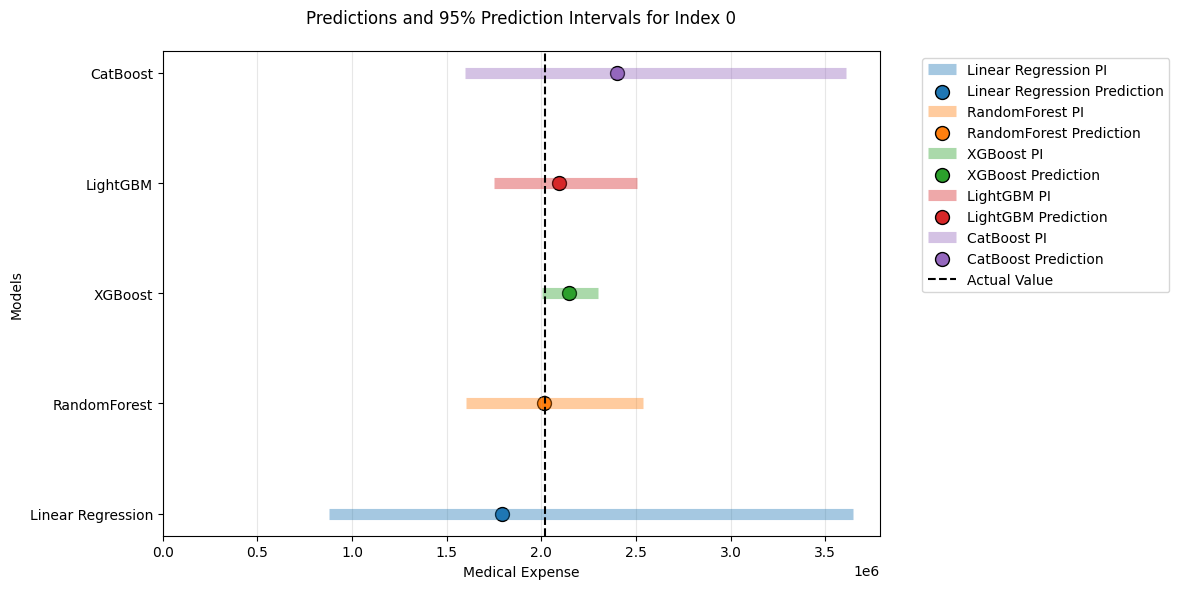

In [158]:
'''
- 예측 구간
  - 미래의 개별 관측치 (Observation)가 포함될 것으로 예상되는 범위
  - 신뢰 구간보다 넓게 산출됨.
  - 예측 구간 = 예측치 $\pm$ 오차 한계 (Margin of Error)
  - 예측 구간은 모델의 잔차 표준편차 (Residual Standard Deviation) 등을 반영함.
'''

plot_prediction_pi(results, 0)  # 첫 번째 행 시각화
# plt.show()

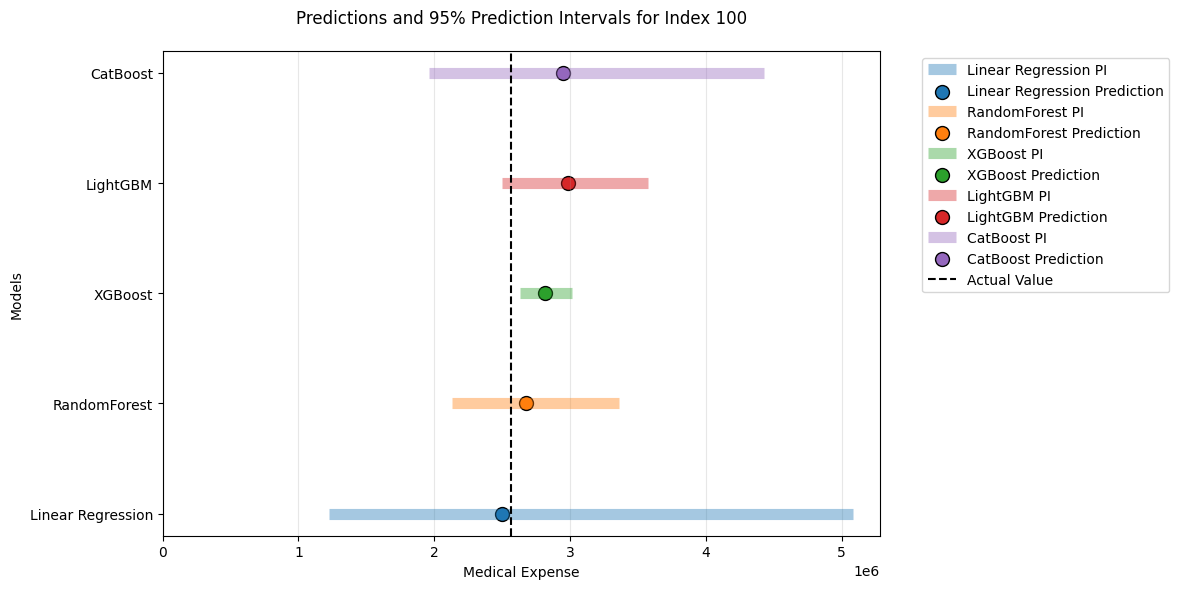

In [159]:
plot_prediction_pi(results, 100)

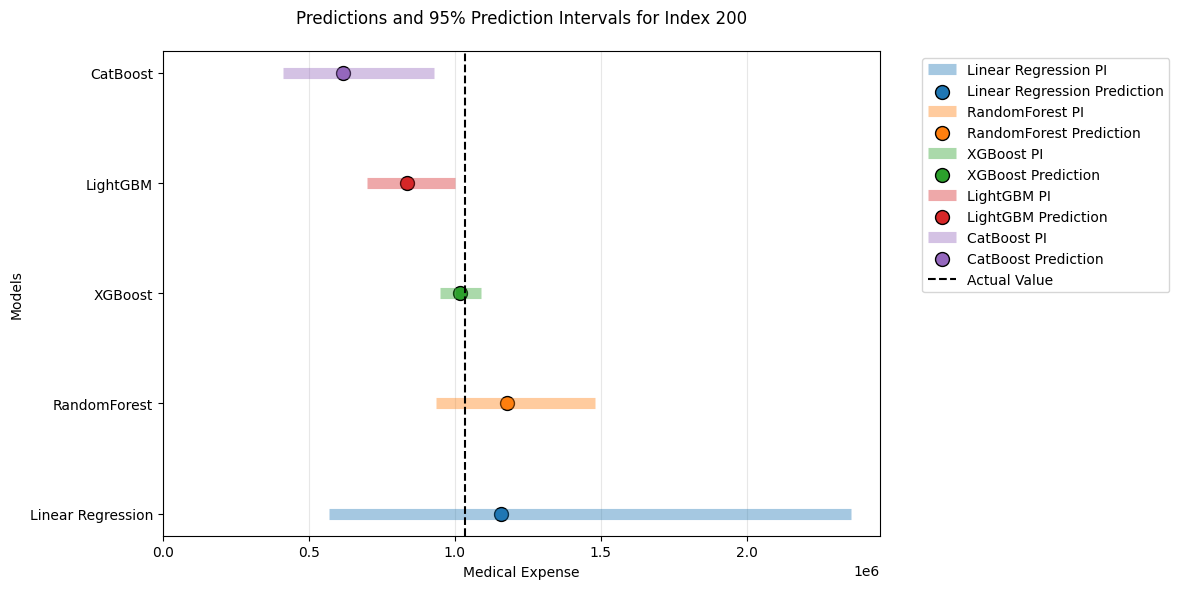

In [160]:
plot_prediction_pi(results, 200)

In [161]:
# 통계 계산 및 시각화 데이터 준비
stats_df, plot_df = calculate_pi_statistics(results)
stats_df

Mean PI Width  Std PI Width  Min PI Width  Max PI Width  \
Linear Regression     2173688.06    2617221.41          0.59   23952887.45   
RandomForest           665969.36     799364.01          0.46    6598808.16   
XGBoost                201043.77     251385.08          0.09    2450192.78   
LightGBM               530511.46     662045.04          0.28    6862081.61   
CatBoost              1162159.36    1272828.24          0.57    9483339.64   

                   Median PI Width  
Linear Regression       1296727.23  
RandomForest             401104.56  
XGBoost                  118559.25  
LightGBM                 308187.04  
CatBoost                 716146.37

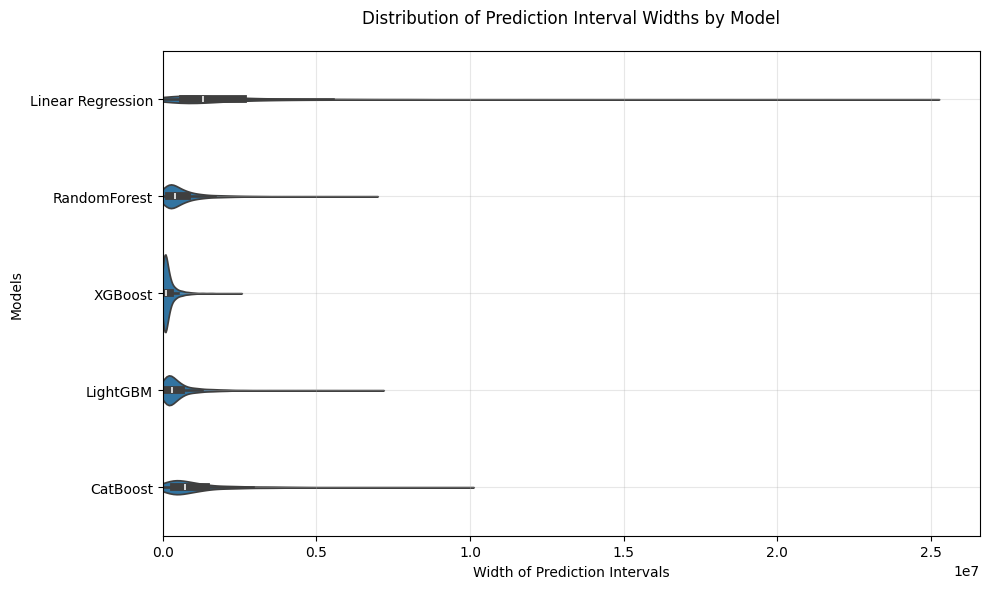

In [162]:
# 분포 시각화
plot_pi_distribution(plot_df)
plt.show()

# 7. 결과 해석

## 7.1. (Tree-based) Feature Importance

- 직전 단계의 Feature Engineering, 성능 평가를 통해 XGBoost를 최종 모델로 선정.

- XGBoost의 Feature Importance 기능을 활용하여, 개인별 총 의료비 예측에 중요한 변수들 분석.

    - 의료 비용 관련 항목이 전체적으로 높은 변수 중요도 형성.
        - 특히, **medical_expense_rolling_mean_2 (직전 2개년도 총 의료비용)**의 변수 중요도가 약 **0.61**로, 압도적으로 형성.
        - 이외에도, medical_expense_lag_1 (직전년도 총 의료비용), meidcal_expense_rolilng_std_2 (직전 2개년도 총 의료비용 표준 편차), medical_expense_rolling_max_2 (직전 2개년도 총 의료비용 최댓값) 등, 의료비용 중에서도 '직전 n개년도 총 의료비용'의 트렌드를 보는 것이 핵심.

    - 비의료 비용 관련 변수들 중에서는, num_bed_confined_days (총 침상에 누워있는 일 수), ou_num (외래 진료 횟수), er_num(응급실 방문 횟수)와 같은 간접적인 의료 서비스 이용 횟수 순으로 중요도가 생성.

- 해당 프로젝트는, 당뇨병 환자 (당뇨 보유자 / 미보유자)를 예측하는 것이 아닌, **이미 당뇨병을 진단받은 환자의 의료비를 예측하는 것**이 목적.
    - 따라서, 기존의 당뇨병과 밀접한 인자로 알려진, 비가역적 (나이, 유전력, 출산력) 및 생활습관 (bmi, 운동 부족, 흡연, 과음, 수면) 인자가 의료비와는 (선형) 상관관계 및 변수 중요도가 낮은 것으로 파악됨. 

In [163]:
# lin_coef_df = analyze_linear_coefficients(lr, X_train.columns.tolist(), top_n=30)
# lin_coef_df

In [164]:
# feature_importance_rf = analyze_feature_importance(rf, X_train.columns)
# feature_importance_rf

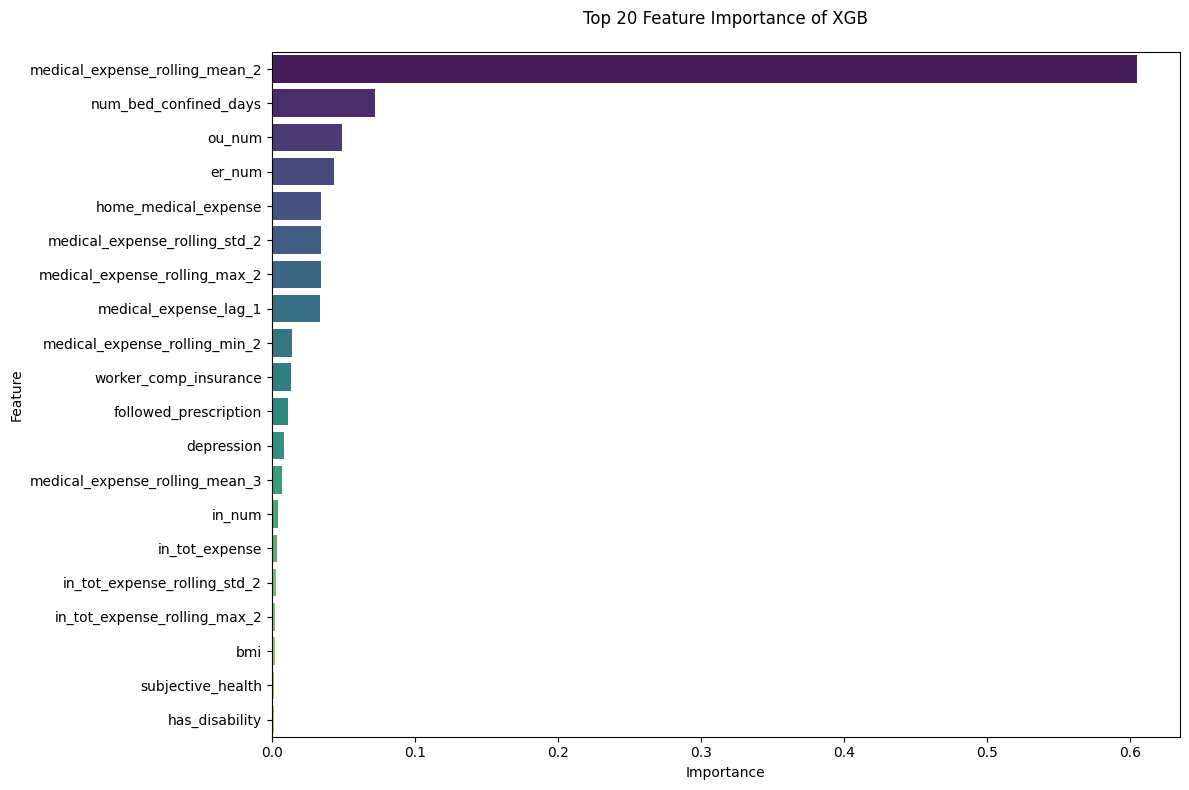


중요도가 0인 특성 개수: 9

Feature Importance 통계:
count    77.000000
mean      0.012987
std       0.069546
min       0.000000
25%       0.000081
50%       0.000413
75%       0.001617
max       0.604680
Name: importance, dtype: float64


feature  importance
53       medical_expense_rolling_mean_2    0.604680
34                num_bed_confined_days    0.072367
17                               ou_num    0.048882
14                               er_num    0.043432
13                 home_medical_expense    0.034562
54        medical_expense_rolling_std_2    0.034544
55        medical_expense_rolling_max_2    0.034298
41                medical_expense_lag_1    0.033876
56        medical_expense_rolling_min_2    0.014116
8                 worker_comp_insurance    0.013587
2                 followed_prescription    0.011190
31                           depression    0.008569
57       medical_expense_rolling_mean_3    0.006932
37                               in_num    0.004345
40                       in_tot_expense    0.003769
70         in_tot_expense_rolling_std_2    0.003002
71         in_tot_expense_rolling_max_2    0.002585
35                                  bmi    0.002182
32                    subjective_health    0.001902
7                        has_disability    0.001617
49                 in_tot_expense_lag_1    0.001608
19                 ou_expense_self_paid    0.001565
66   home_medical_expense_rolling_std_3    0.001431
9                               married    0.001130
62   home_medical_expense_rolling_std_2    0.001083
30                        physical_pain    0.001021
46           home_medical_expense_lag_2    0.000981
64   home_medical_expense_rolling_min_2    0.000884
60        medical_expense_rolling_min_3    0.000750
59        medical_expense_rolling_max_3    0.000691
42                medical_expense_lag_2    0.000635
39                         in_is_public    0.000601
47           home_medical_expense_lag_3    0.000581
45           home_medical_expense_lag_1    0.000506
76         in_tot_expense_rolling_min_3    0.000484
61  home_medical_expense_rolling_mean_2    0.000475
0             num_years_since_diagnosis    0.000450
58        medical_expense_rolling_std_3    0.000431
23                              smoking    0.000413
5                                   age    0.000367
12                num_household_members    0.000346
18                         ou_is_public    0.000325
27                   frequency_10m_walk    0.000297
65  home_medical_expense_rolling_mean_3    0.000210
6           num_years_since_med_pension    0.000200
50                 in_tot_expense_lag_2    0.000195
68   home_medical_expense_rolling_min_3    0.000190
1            visited_facility_this_year    0.000167
63   home_medical_expense_rolling_max_2    0.000160
69        in_tot_expense_rolling_mean_2    0.000146
29                             mobility    0.000123
74         in_tot_expense_rolling_std_3    0.000119
26               frequency_mild_workout    0.000115
67   home_medical_expense_rolling_max_3    0.000103
4                       education_level    0.000100
28                avg_weekly_stting_hrs    0.000093
25            frequency_intense_workout    0.000088
73        in_tot_expense_rolling_mean_3    0.000081
43                medical_expense_lag_3    0.000074
75         in_tot_expense_rolling_max_3    0.000069
24                             drinking    0.000061
38                          in_num_days    0.000055
72         in_tot_expense_rolling_min_2    0.000039
51                 in_tot_expense_lag_3    0.000036
16                       er_tot_expense    0.000033
22            ou_treatment_type_surgery    0.000024
33                     was_bed_confined    0.000015
3           had_medication_side_effects    0.000010
10                       is_above_45yrs    0.000000
11       pension_receipt_status_unknown    0.000000
15                              er_days    0.000000
20                  ou_reason_aesthetic    0.000000
21                ou_treatment_type_etc    0.000000
52                 in_tot_expense_lag_4    0.000000
48           home_medical_expense_lag_4    0.000000
44                medical_expense_lag_4    0.000000
36                        is

In [165]:
pd.set_option('display.max_rows', 100)
feature_importance_xgb = analyze_feature_importance(xgb, X_train.columns, type = 'xgb')
feature_importance_xgb

In [166]:
# feature_importance_lgb = analyze_feature_importance(lgb, X_train.columns)
# feature_importance_lgb

## 7.2. LIME (Local Interpretable Model-Agnostic Explanations)

In [167]:
# 샘플 인덱스 출력하여 LIME 분석.
random.seed(44)
np.random.seed(44)
sample_idx = np.random.choice(len(X_test), size=1, replace=False)
print(f"인덱스 {sample_idx}=> 예측 값: {int(np.exp(xgb_pred[sample_idx][0]))}, 실제 값: {int(np.exp(y_test[sample_idx].values[0]))}")

explainer, exp = implement_lime(xgb, X_train, X_test, sample_idx)

인덱스 [774]=> 예측 값: 398529, 실제 값: 433691


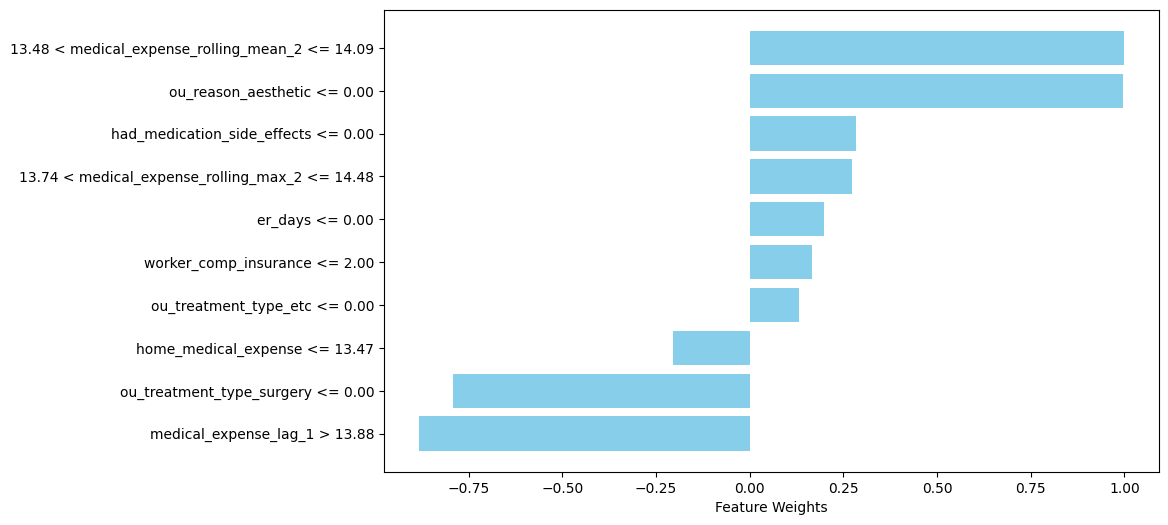

In [168]:
plot_lime(exp)

In [169]:
for i, idx in enumerate(sample_idx):
    print(f"\n🎯 샘플 {i+1} (인덱스: {idx})의 예측 해석 결과:")
    instance = X_test.iloc[idx].values
    explanation_texts = explain_instance_text(explainer, instance, xgb.predict, top_k=10)
    for line in explanation_texts:
        print(line)


🎯 샘플 1 (인덱스: 774)의 예측 해석 결과:
- 조건 [13.48 < medical_expense_rolling_mean_2 <= 14.09] 은(는) 예측값을 약 168.4% 증가시키는 데 기여했습니다.
- 조건 [medical_expense_lag_1 > 13.88] 은(는) 예측값을 약 -58.6% 감소시키는 데 기여했습니다.
- 조건 [worker_comp_insurance <= 2.00] 은(는) 예측값을 약 55.2% 증가시키는 데 기여했습니다.
- 조건 [ou_reason_aesthetic <= 0.00] 은(는) 예측값을 약 -30.9% 감소시키는 데 기여했습니다.
- 조건 [ou_treatment_type_etc <= 0.00] 은(는) 예측값을 약 43.1% 증가시키는 데 기여했습니다.
- 조건 [num_years_since_med_pension <= 1.00] 은(는) 예측값을 약 -25.8% 감소시키는 데 기여했습니다.
- 조건 [home_medical_expense <= 13.47] 은(는) 예측값을 약 -22.0% 감소시키는 데 기여했습니다.
- 조건 [had_medication_side_effects <= 0.00] 은(는) 예측값을 약 25.1% 증가시키는 데 기여했습니다.
- 조건 [13.74 < medical_expense_rolling_max_2 <= 14.48] 은(는) 예측값을 약 23.3% 증가시키는 데 기여했습니다.
- 조건 [frequency_intense_workout <= 0.00] 은(는) 예측값을 약 -16.5% 감소시키는 데 기여했습니다.
